# Signac vignette on TDR118 multiome dataset (the first pilot dataset)


The goal is to recapitulate the Signac paper figures by following the vignette.
https://stuartlab.org/signac/articles/pbmc_multiomic.html

Here, instead of just following the original vignettes, we will modify the workflow such that we can use this as a template for future zebrafish single-cell multiome dataests. The new workflow will be the following.

- Import the cellranger-arc output files into a Seurat object (both RNA and ATAC)
- (Modification) Add the reference genome information using a GTF file (used for the alignment) 
- Minimal QC on the RNA object
- (Modification) cell type label transfer from a reference dataset (using RNA modality)
- (Modification) cell type specific peak-calling using the transferred label
- Basic QC and dim.reduction (this can be done more rigorously - see the other vignette)
- (optional) Curate the annotation using the ATAC modality, or joint embedding (weighted nearest neighbor) - exCellxgene

- Linking peaks to genes (this can probably be done with other packages)
- Identifying differentially accessible peaks (DA peaks)
- Computing enriched TF motifs in DA peaks


## Additional assessments/evaluation
- Comparison of called peaks at different resolutions (Cellranger-arc, Cellranger-arc aggr, MACS2-bulk, MACS2-cell type (coarse/fine), MACS2-leiden cluster, etc.)

- Dissection of linked gene/peak relationship: identifying the DA peaks and TF motif enrichment within those DA peaks -> there can be different algorithms for this other than ones used in the Signac paper.

## Notes

- genome annotation: Make sure to use the latest and best genome annotation. (This can also be done outside of the R Bioconductor.)

- Fragments file contains all the raw mapped reads, thus can be used over and over for peak-calling purposes (with different grouping parameters).

- When the fragment file path is changed, then we need to manually update the Fragment filepath in the Seurat/Signac object by the following command


# Computing environment setup (parallelization)

link to the vignette: https://stuartlab.org/signac/articles/future.html



# Step 0. Load the dataset


### Pre-processing workflow
When pre-processing chromatin data, Signac uses information from two related input files, both of which can be created using CellRanger:

Peak/Cell matrix. This is analogous to the gene expression count matrix used to analyze single-cell RNA-seq. However, instead of genes, each row of the matrix represents a region of the genome (a peak), that is predicted to represent a region of open chromatin. Each value in the matrix represents the number of Tn5 integration sites for each single barcode (i.e. a cell) that map within each peak. You can find more detail on the 10X Website.

Fragment file. This represents a full list of all unique fragments across all single cells. It is a substantially larger file, is slower to work with, and is stored on-disk (instead of in memory). However, the advantage of retaining this file is that it contains all fragments associated with each single cell, as opposed to only fragments that map to peaks. More information about the fragment file can be found on the 10x Genomics website or on the sinto website.

We start by creating a Seurat object using the peak/cell matrix and cell metadata generated by cellranger-atac, and store the path to the fragment file on disk in the Seurat object:

CreateChromatinAssay: https://stuartlab.org/signac/reference/createchromatinassay

- counts (unnormalized data, raw counts)
- (or data, normalized data)
- min.cells/ min.features (max.cells)
- ranges: a set of "GRanges" corresponding to the rows of the input matrix
- fragments: filepath for the fragments file -> for multiple fragment files, we can create a new fragment object, or a list of Fragment objects.
- genome: A "Seqinfo" object containing basic information about the genome used. Alternatively, the name of a UCSC genome can be provided and the sequence information will be downloaded from UCSC.
- annotation: a set of "GRanges" containing annotations for the genome used.

In [1]:
# download the sample pbmc dataset (Run the following in the linux terminal)
# wget https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5
# wget https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz
# wget https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz.tbi

In [1]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
library(ggplot2)
library(patchwork)
library(anndata)
library(stringr)
# library(EnsDb.Hsapiens.v86) # for human genome annotation
# library(BSgenome.Hsapiens.UCSC.hg38
library(BSgenome.Drerio.UCSC.danRer11)

Loading required package: BSgenome

Loading required package: GenomicRanges

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [2]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.0                         
year           2023                        
month          04                          
day            21                          
svn rev        84292                       
language       R                           
version.string R version 4.3.0 (2023-04-21)
nickname       Already Tomorrow            

In [4]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")

In [5]:
getwd()

[1] "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/notebooks/multiome_zebrahub_analysis"

In [6]:
# load the RNA and ATAC data
# data_path = "/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/signac_examples/pbmc_multiome/"
counts <- Read10X_h5("/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/filtered_feature_bc_matrix.h5")
fragpath <- "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Genome matrix has multiple modalities, returning a list of matrices for this genome



## Step 0-1. Add the Genome Annotation

- There are two options to add the Genome Annotation
- 1) Use the GenGRangesFromEnsDb function when there is a reference genome listed in EnsDb library.
- 2) If this is not the case (or if we have the GTF file used for the alignment), we can use a more customized version.

In [9]:
# # Option 1 - Signac vignette
# # get gene annotations for hg38
# annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
# seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

# # create a Seurat object containing the RNA assay
# pbmc <- CreateSeuratObject(
#   counts = counts$`Gene Expression`,
#   assay = "RNA"
# )

# # create ATAC assay and add it to the object
# pbmc[["ATAC"]] <- CreateChromatinAssay(
#   counts = counts$Peaks,
#   sep = c(":", "-"),
#   fragments = fragpath,
#   annotation = annotation
# )

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [5]:
# Option 2 - neurips 2021 data processing
# path to the GTF file
# gref_path = "/data/yangjoon.kim/bruno/projects/sequencing_alignment/gff_files/Danio.rerio.gtf"
gref_path = "/hpc/reference/sequencing_alignment/alignment_references/zebrafish_genome_GRCz11/genes/genes.gtf.gz"
gtf_zf <- rtracklayer::import(gref_path)

In [6]:
gtf_zf

GRanges object with 1153784 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1153780]       MT 16449-16520      + |   RefSeq transcript        NA
  [1153781]       MT 16449-16520      + |   RefSeq exon              NA
  [1153782]       MT 16527-16596      - |   RefSeq gene              NA
  [1153783]       MT 16527-16596      - |   RefSeq transcript        NA
  [1153784]       MT 16527-16596      - |   RefSeq exon              NA
    

In [50]:
unique(gtf_zf$type)

[1] gene            transcript      exon            CDS            
[5] start_codon     stop_codon      five_prime_utr  three_prime_utr
[9] Selenocysteine 
9 Levels: gene transcript exon CDS start_codon stop_codon ... Selenocysteine

In [7]:
gene.coords.zf <- gtf_zf
# gene.coords.zf <- gtf_zf[gtf_zf$type == 'gene']
gene.coords.zf <- gene.coords.zf[! is.na(gene.coords.zf$gene_name),]
gene.coords.zf

GRanges object with 1152211 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

In [427]:
gene.coords.zf[gene.coords.zf$gene_name == "phtf2"]

GRanges object with 86 ranges and 20 metadata columns:
       seqnames      ranges strand |   source        type     score     phase
          <Rle>   <IRanges>  <Rle> | <factor>    <factor> <numeric> <integer>
   [1]        4 31259-45642      + |  ensembl gene               NA      <NA>
   [2]        4 31259-45642      + |  ensembl transcript         NA      <NA>
   [3]        4 31259-31303      + |  ensembl exon               NA      <NA>
   [4]        4 31259-31303      + |  ensembl CDS                NA         0
   [5]        4 31259-31261      + |  ensembl start_codon        NA         0
   ...      ...         ...    ... .      ...         ...       ...       ...
  [82]        4 44864-44959      + |  ensembl  exon              NA      <NA>
  [83]        4 44864-44959      + |  ensembl  CDS               NA         0
  [84]        4 45166-45396      + |  ensembl  exon              NA      <NA>
  [85]        4 45166-45393      + |  ensembl  CDS               NA         0
  [86]   

In [40]:
gene.coords.zf@seqnames

factor-Rle of length 1152211 with 26 runs
  Lengths: 58625 62606 61693 53310 51875 ... 41619 33431 39002 35275   147
  Values :    4     7     5     3     6  ...    10    24    22    25    MT
Levels(26): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 MT

In [41]:
gene.coords.zf

GRanges object with 1152211 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

In [429]:
gene.coords.zf <- keepStandardChromosomes(gene.coords.zf, pruning.mode = 'coarse')
gene.coords.zf

genome(gene.coords.zf) <- 'GRCz11'

GRanges object with 1152211 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

In [58]:
# create a Seurat object containing the RNA assay
TDR118 <- CreateSeuratObject(
  counts = counts$`Gene Expression`,
  assay = "RNA"
)

# create a ChromatinAssay object
TDR118[["ATAC"]] <- CreateChromatinAssay(
    counts = counts$Peaks,
    sep = c(":", "-"),
    genome = 'GRCz11', # we will manually add the genome version
    fragments = fragpath, # fragment file is saved using the filepath, so if the file is moved to another location, we need to update this.
    annotation = gene.coords.zf# we will manually add the genome annotation
#     min.cells = 15
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Computing hash



In [59]:
TDR118@assays$ATAC

ChromatinAssay data with 248320 features for 14430 cells
Variable features: 0 
Genome: GRCz11 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [431]:
Annotation(TDR118) <- gene.coords.zf

In [432]:
TDR118@assays$ATAC@annotation

GRanges object with 1152211 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

# Step 1. Basic Quality Control 

- This is to filter out obvious low quanlity cells
- This can be done for the RNA modality using RNA QC metrics (See the other vignettes in Seurat webpage).


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



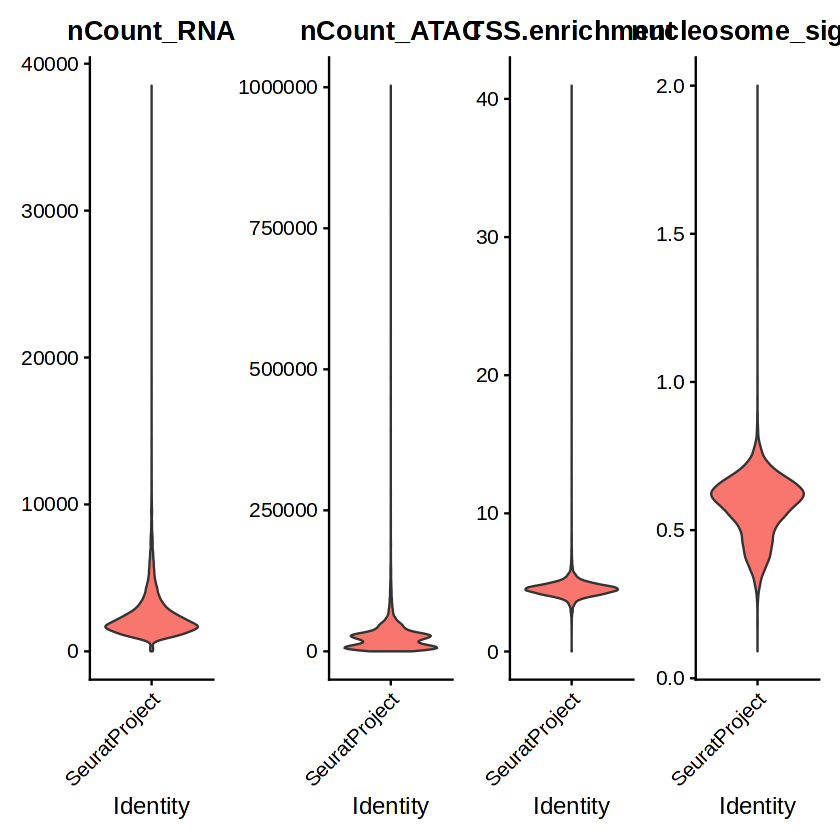

In [60]:
DefaultAssay(TDR118) <- "ATAC"

TDR118 <- NucleosomeSignal(TDR118)
TDR118 <- TSSEnrichment(TDR118)

VlnPlot(
  object = TDR118,
  features = c("nCount_RNA", "nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0
)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 76 rows containing non-finite values (stat_ydensity).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 1489 rows containing non-finite values (stat_ydensity).”


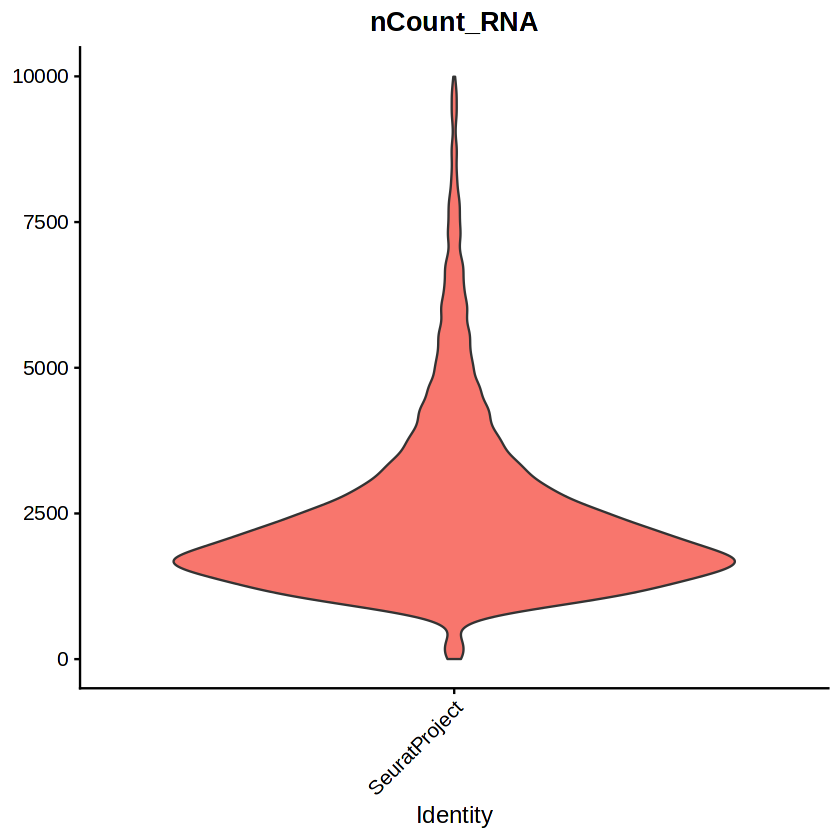

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 31 rows containing non-finite values (stat_ydensity).”


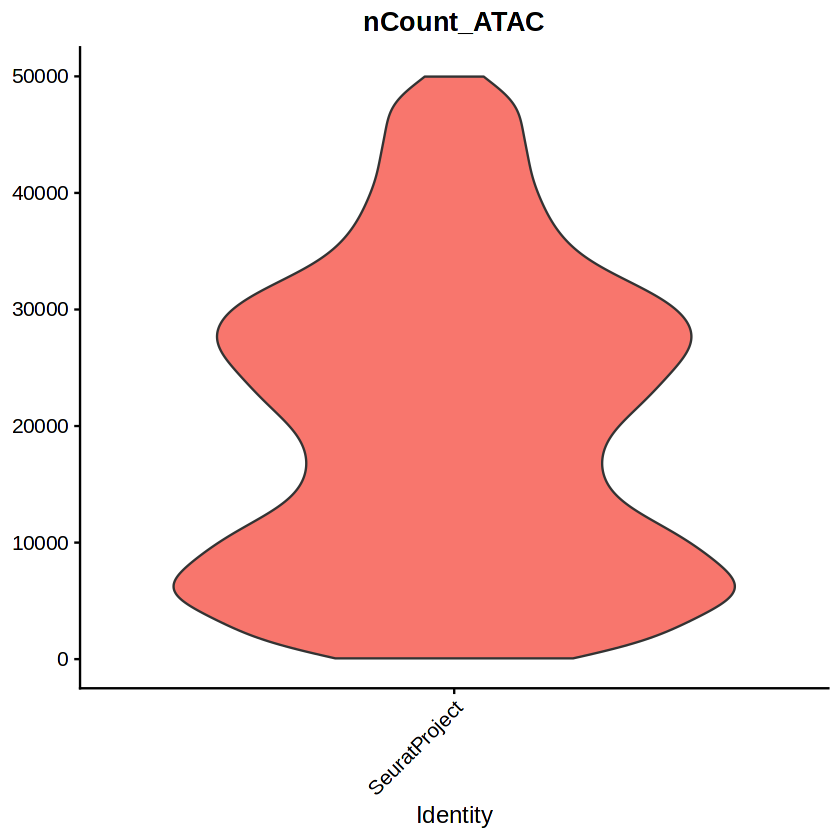

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 10 rows containing non-finite values (stat_ydensity).”


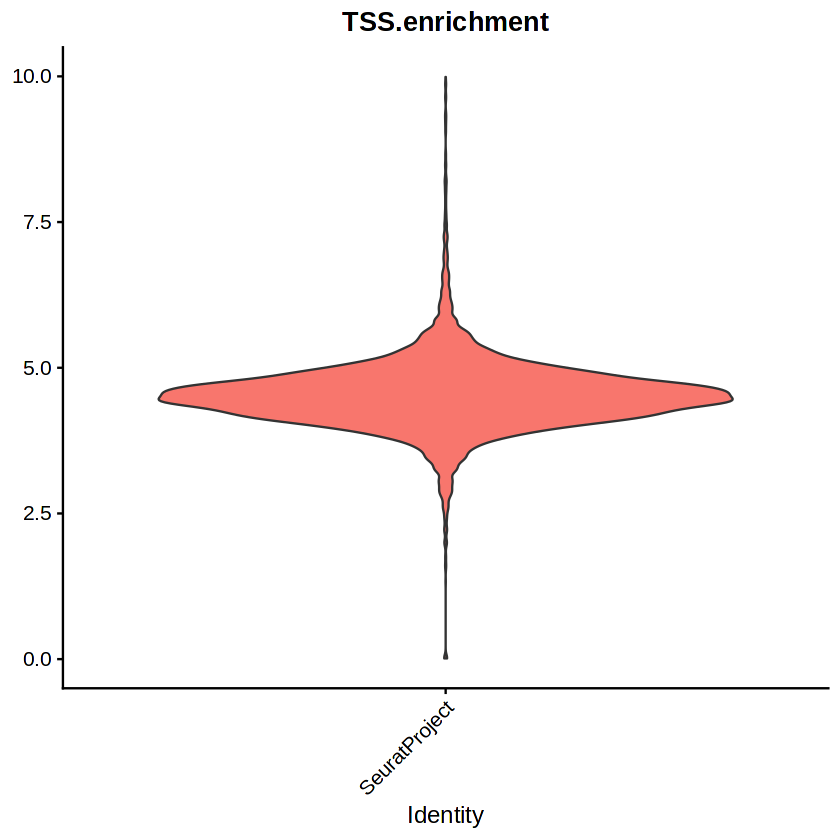

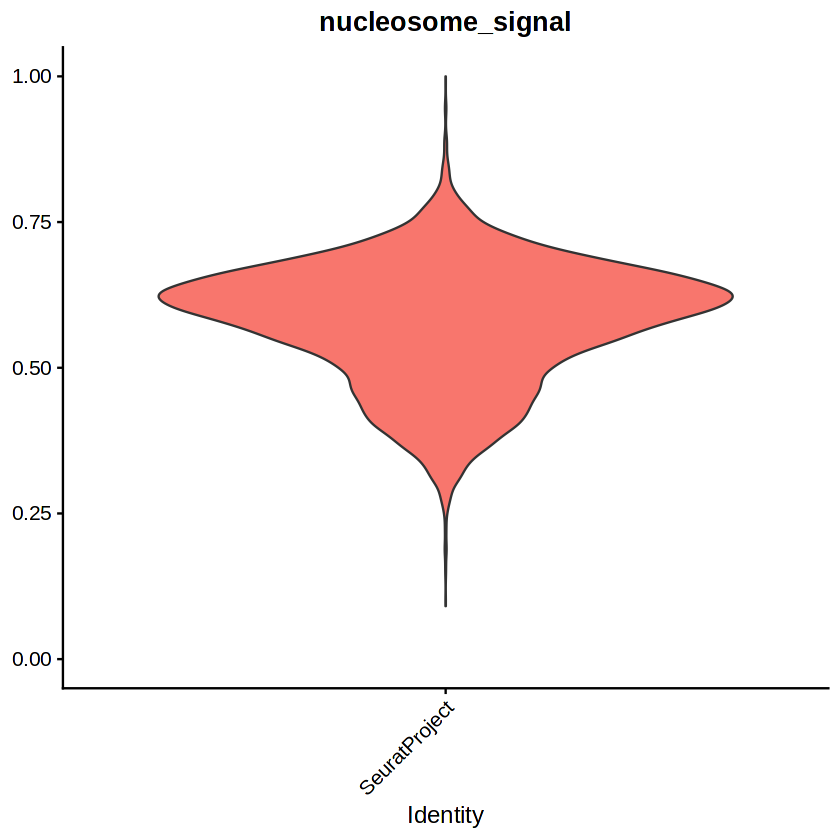

In [73]:
vln <- VlnPlot(
  object = TDR118,
  features = c("nCount_RNA", "nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0
)

# Adjust the y-axis limits for each feature
vln[[1]] + ylim(0, 10000)              # y-axis limits for "nCount_RNA"
vln[[2]] + ylim(0, 50000)              # y-axis limits for "nCount_ATAC"
vln[[3]] + ylim(0, 10)                 # y-axis limits for "TSS.enrichment"
vln[[4]] + ylim(0, 1)                  # y-axis limits for "nucleosome_signal"


In [74]:
# filter out low quality cells
# NOTE that we're not being meticulous about the thresholds here, especially the lower limits for RNA/ATAC fragment counts.

# define the unfiltered object
TDR118_unfiltered <- TDR118

# filter out the low quality cells
TDR118 <- subset(
  x = TDR118,
  subset = nCount_ATAC < 100000 &
    nCount_RNA < 25000 &
    nCount_ATAC > 1000 &
    nCount_RNA > 1000 &
    nucleosome_signal < 2 &
    TSS.enrichment > 1
)
TDR118

An object of class Seurat 
280377 features across 13022 samples within 2 assays 
Active assay: ATAC (248320 features, 0 variable features)
 1 other assay present: RNA

## Gene expression (RNA) data processing

- log-normalization, dimensionality reduction, etc.

We can normalize the gene expression data using SCTransform, and reduce the dimensionality using PCA.

In [78]:
DefaultAssay(TDR118) <- "RNA"
TDR118 <- SCTransform(TDR118)
TDR118 <- RunPCA(TDR118)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22693 by 13022

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 135 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22693 genes



  |======================================================================| 100%


Computing corrected count matrix for 22693 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.57794 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  ttn.2, ttn.1, tspan9a, ryr1b, txlnba, neb, smyhc1, mef2d, musk, ldb3a 
	   rbm24a, nexn, cacna1ha, tns2b, flncb, rbfox1l, mef2cb, si:ch1073-268j14.1, myh7bb, efemp2a 
	   mybphb, trdn, ryr1a, myom1b, akap6, tnni2b.1, cdh15, srl, chrng, BX571827.3 
Negative:  hsp90ab1, ncam1a, nova2, zbtb16a, ptmab, hmga1a, zbtb16b, eef1a1l1, rplp1, sox13 
	   rfx4, efna2a, rplp0, tenm4, rps12, BX571942.1, pax6a, msi1, epb41a, rps8a 
	   rpl17, rps2, rps20, marcksl1b, ncam1b, rpl7a, pax5, negr1, rpl19, rpl23 
PC_ 2 
Positive:  lama5, col28a2a, cldni, col7a1, tp63, bcam, col14a1a, slit3, col11a1a, actn1 
	   plekha6, tfap2c, apoeb, ank3a, kremen1, col12a1b, epcam, col7a1l, flrt2, CR383676.2 
	   col18a1a, palm3, cdh1, adamts6, pcdh7b, igsf9bb, pawr, dock5, rpe65b, edil3a 
Negative:  ttn

# Step 2.  Annotation transfer from a reference dataset 

This is for rough annotation and cell-type specific peak calling

To annotate cell types in the dataset we can transfer cell labels from an existing PBMC reference dataset using tools in the Seurat package. See the Seurat reference mapping vignette for more information.

We’ll use an annotated PBMC reference dataset from Hao et al. (2020), available for download here: https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat

Note that the SeuratDisk package is required to load the reference dataset. Installation instructions for SeuratDisk can be found here.

In [3]:
library(SeuratData)
library(SeuratDisk)

ERROR: Error in library(SeuratData): there is no package called ‘SeuratData’


In [5]:
reference <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/ZF_atlas_v01/ZF_atlas_v01_15somite.h5Seurat")
reference

ERROR: Error in readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/ZF_atlas_v01/ZF_atlas_v01_15somite.h5Seurat"): unknown input format


In [134]:
setwd("/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/ZF_atlas_v01_r_files/")
source("/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/github_repos/single-cell-utilities/read_matrix.R")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca to Xpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umap to Xumap_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumap_”


In [161]:
library(Matrix)

# read from .mtx (better)
counts = readMM('sparse_matrix.mtx')
counts

# obs data.frame
obs = read.csv('obs.csv', header = T)
# var data.frame
vars = read.csv('var.csv', row.names = 1)
# obsm UMAP coords
obsm = read.csv('obsm.csv', header = T)

38189 x 27877 sparse Matrix of class "dgTMatrix"
                                                                                     
   [1,] . . 1 . 1 . . 1 . . . . . . . . . . .   . 22  4 1 .  . 138 . . . . 2 . ......
   [2,] . . 1 . . . . . 1 . . . . 3 . . . . .   2 21  2 . .  . 159 . . . . 2 1 ......
   [3,] . . 1 . . . . 1 . . 1 . . 1 . . . . .   2 26 10 2 2  . 302 . . . . 2 1 ......
   [4,] . . . . . . . . 1 . . . . . . . . . .   1  8  7 . 1  . 130 . . . . 3 . ......
   [5,] . . . . . . . . . . . . . . . . . . 1   . 15  . . .  . 155 . . . . 1 . ......
   [6,] . . . . . . . . . 1 1 . 1 1 . . . . .   . 18  5 . 1  1 132 . . . . 2 . ......
   [7,] . . . . . . . . . 2 . . . . . . . . .   . 23 11 1 1  . 139 . . . . 6 1 ......
   [8,] . . . . . . . . . . . . . 1 . . . . .   2 22  3 . .  . 180 . . . . 2 . ......
   [9,] 1 . . . . . . . . . . . . . . . . . . 211  5  . . .  .  63 . . . . 1 . ......
  [10,] . . 1 . . . . . . 3 . . . . . . . . .   2 12  4 1 .  . 161 . . . . 1 . ......
  [11

In [163]:
# create the seurat object
# name rows and cols
# take the vars' index: should be the gene symbol! 
colnames(counts) <- row.names(vars)
# take obs' index: should correspond to a unique cell_id! 
row.names(counts) <- obs[,1]

row.names(obs) <- obs[,1]
row.names(obsm) <- obs[,1]

# Make Seurat object
seurat_obj = CreateSeuratObject(counts = t(counts), meta.data = obs)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [177]:
reference <- seurat_obj

In [178]:
unique(reference$timepoint)

[1] "10somite"   "0 budstage" "20somite"   "30somite"   "5somite"   
[6] "15somite"

In [183]:
reference_15somite <- reference[, reference@meta.data$timepoint=="15somite"]
reference_15somite

An object of class Seurat 
27877 features across 6297 samples within 1 assay 
Active assay: RNA (27877 features, 0 variable features)

In [184]:
unique(reference_15somite$cell_annotation)

[1] "LateralPlate_cxcl12a.hand2"    "Macrophages_rhogb.spi1b"      
 [3] "NeuralCrest_ednrab.slc1a3a"    "Somites_msgn1"                
 [5] "Periderme_foxi3a"              "OpticCup_rx1"                 
 [7] "Midbrain_her8.zfhx4"           "OticPlacode_cldna.eya1"       
 [9] "Hindbrain_zic2b.olig3"         "PronephricDuct_hnf1ba.prxl12b"
[11] "PSN_msgn1"                     "Telencephalon_fezf2.sox1b"    
[13] "EpidermAnterior_six4b.pitx3"   "Periderm_krt5.anxa1c"         
[15] "SpinalCord.ldlrad2.hoxc3a"     "DifferentiatingNeurons_elavl3"
[17] "FloorPlate_shha.foxj1a"        "AdaxialCells_apobec2a"        
[19] "PharyngealArch.prrx1a.fibina"  "Erythroid_cpox.hbae1.3"       
[21] "unassigned"                    "Notochord_tbxta"              
[23] "Muscle_myod1"                  "Endothelial_sox7"             
[25] "NMPs_sox2.tbxta"

In [4]:
annotations <- c("cell_annotation", "global_annotation")
annotations

[1] "cell_annotation"   "global_annotation"

In [5]:
annotations[1]

[1] "cell_annotation"

In [185]:
unique(reference_15somite$global_annotation)

[1] "Lateral_Mesoderm"        "Neural_Crest"           
 [3] "Somites"                 "Epidermal"              
 [5] "Neural_Anterior"         "Neural_Posterior"       
 [7] "Endoderm"                "PSM"                    
 [9] "Differentiating_Neurons" "Adaxial_Cells"          
[11] "NMPs"                    "Notochord"              
[13] "Muscle"                  "unassigned"

In [315]:
reference_15somite

An object of class Seurat 
50886 features across 6297 samples within 2 assays 
Active assay: SCT (23009 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

In [186]:
# preprocess the reference datasets
reference_15somite <- SCTransform(reference_15somite)
reference_15somite <- RunPCA(reference_15somite)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23009 by 6297

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 84 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23009 genes



  |======================================================================| 100%


Computing corrected count matrix for 23009 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.649798 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  krt4, pfn1, cyt1, cfl1l, epcam, tmsb1, cldni, cyt1l, myh9a, tagln2 
	   actb1, tmsb4x, apoeb, tp63, krt8, cdh1, pak2a, zgc:171775, gpa33a, fermt1 
	   ecrg4b, ywhaz, bcam, sult2st1, krt92, dnase1l4.1, spaca4l, lgals3b, cnn2, apoc1 
Negative:  nova2, hsp90aa1.1, meox1, fn1b, BX001014.2, unc45b, efemp2b, efemp2a, si:ch211-137a8.4, tcf15 
	   ttn.1, si:dkey-56m19.5, sox3, sox19a, pcna, myod1, fabp3, tuba1c, tubb2b, ttn.2 
	   rbm24a, npm1a, hist1h4l-16, hspb1, zgc:92429, rps20, hmgb2a, cldn5a, si:ch211-286o17.1, cdh2 
PC_ 2 
Positive:  si:ch211-222l21.1, hsp90ab1, nova2, sox3, pcna, hist1h4l-16, si:ch211-137a8.4, sox19a, hist1h4l-6, marcksl1b 
	   ptmab, tubb2b, hist1h4l-11, tuba1c, hmgb2a, zgc:153409, cldn5a, zbtb16a, zgc:110425, fabp3 
	   gfap, rrm2-1, hmga1a, si:dke

In [324]:
reference_15somite <- RunUMAP(reference_15somite, reduction = "pca", dims = 1:50)

13:48:19 UMAP embedding parameters a = 0.9922 b = 1.112

13:48:19 Read 6297 rows and found 50 numeric columns

13:48:19 Using Annoy for neighbor search, n_neighbors = 30

13:48:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:48:20 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07e6c6dd16d

13:48:20 Searching Annoy index using 10 threads, search_k = 3000

13:48:20 Annoy recall = 100%

13:48:23 Commencing smooth kNN distance calibration using 10 threads

13:48:28 Initializing from normalized Laplacian + noise

13:48:28 Commencing optimization for 500 epochs, with 249542 positive edges

13:48:36 Optimization finished



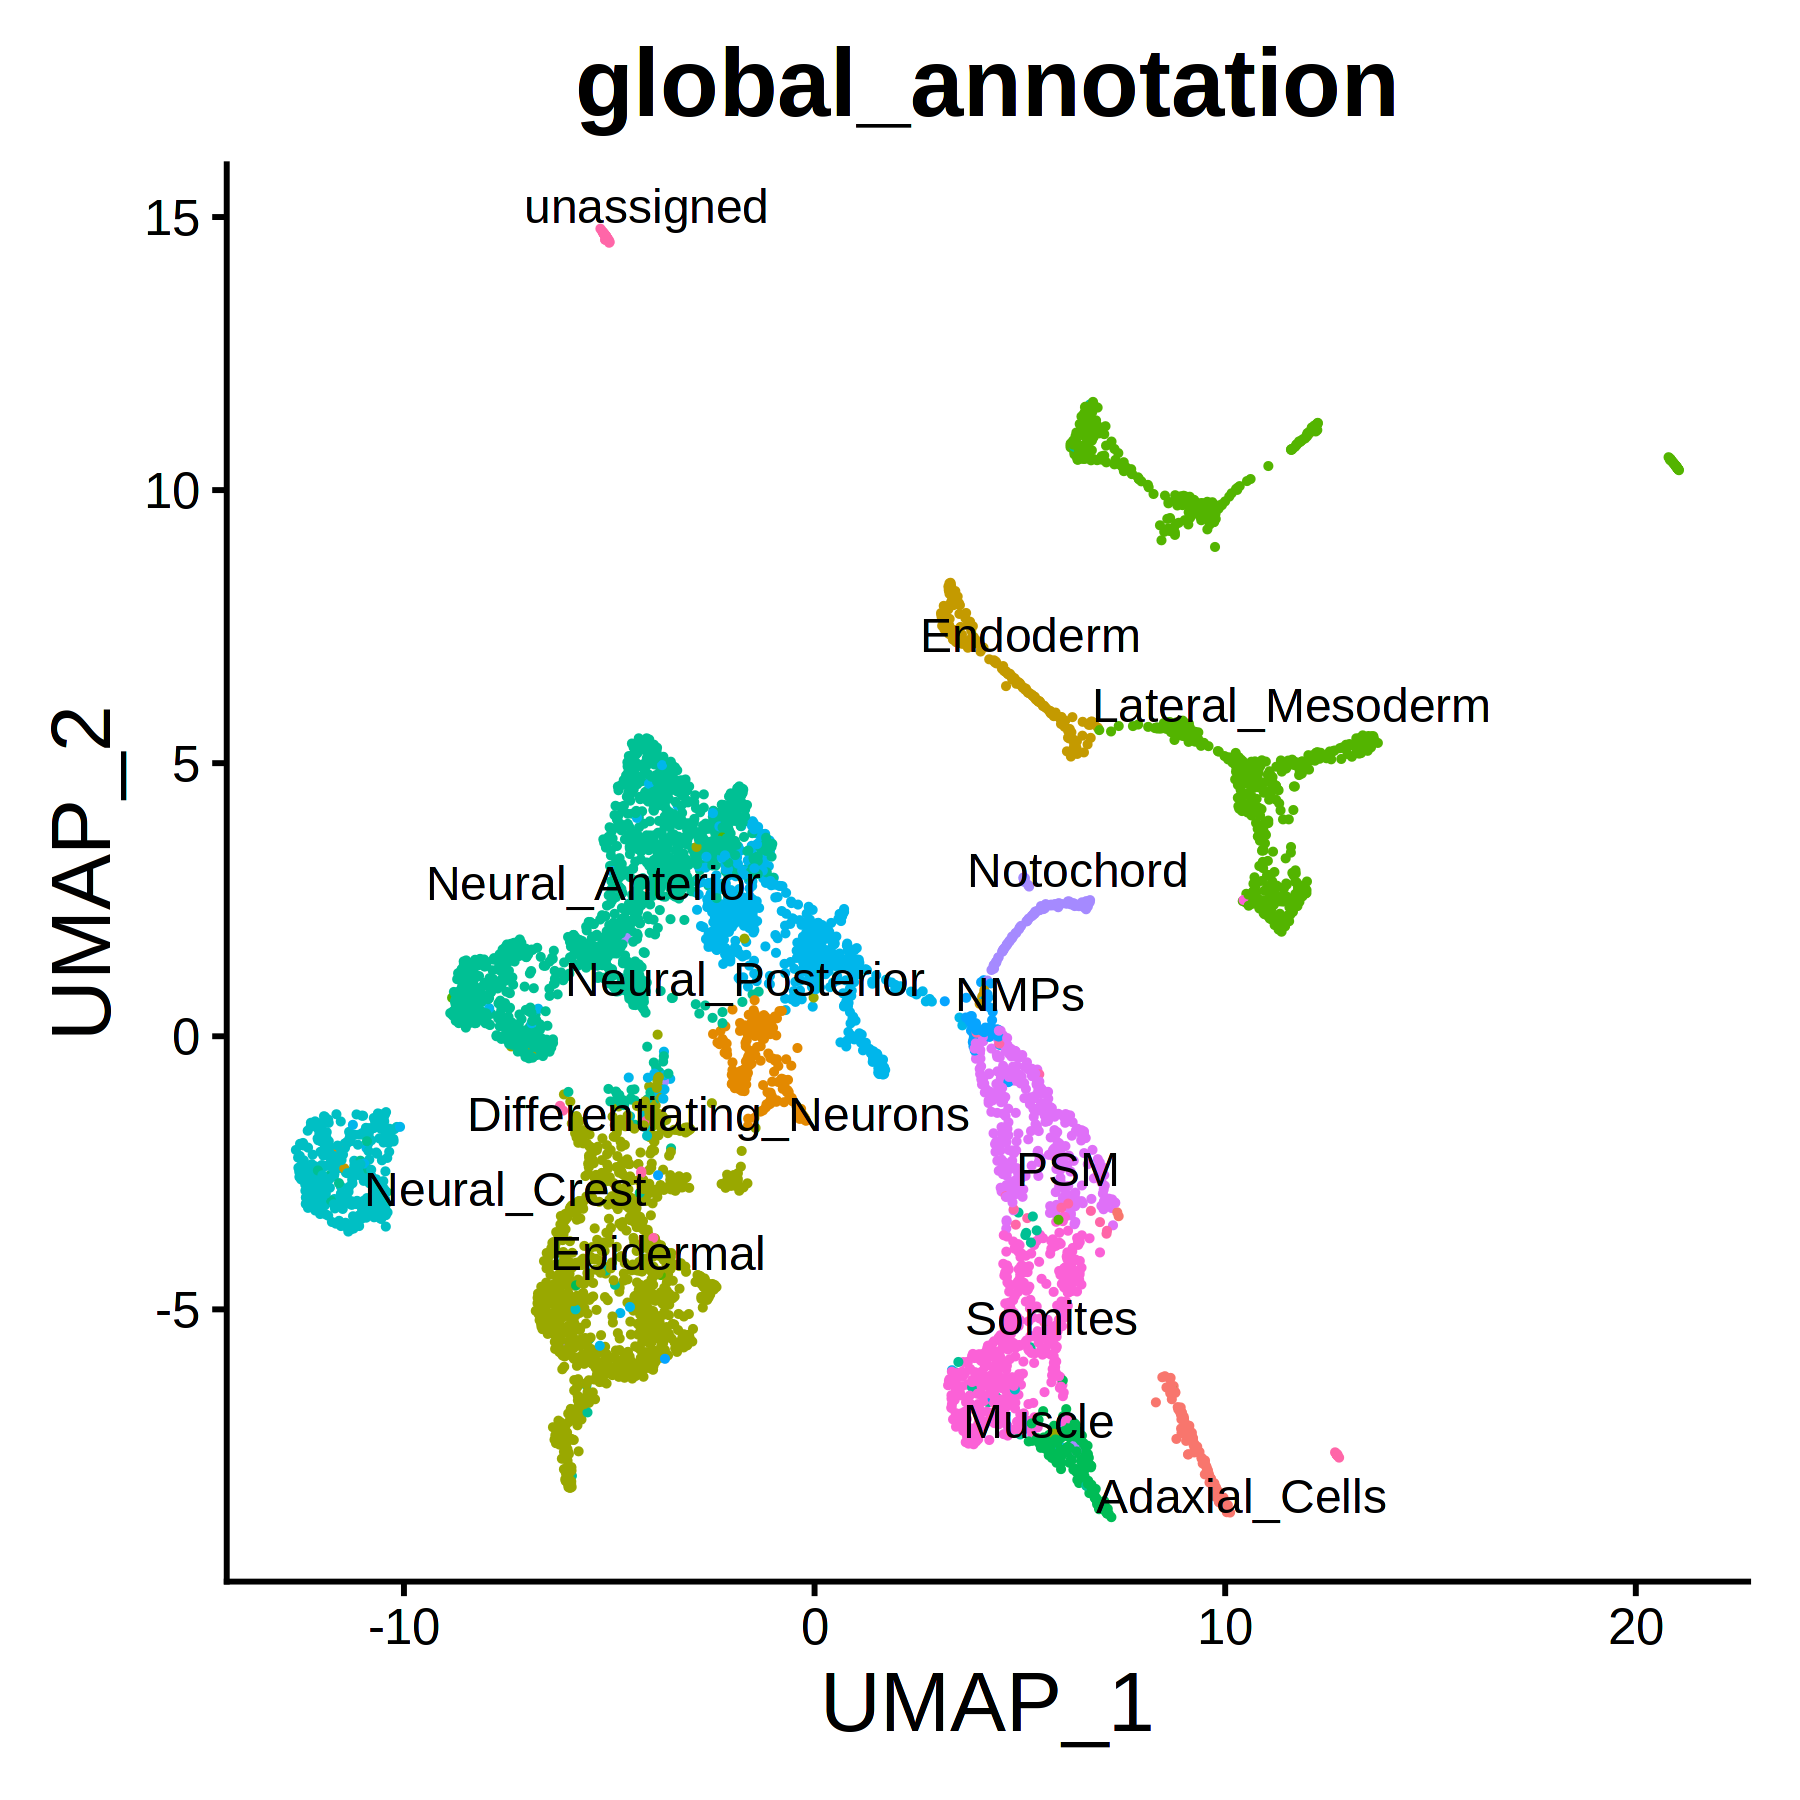

In [325]:
# Plot the UMAP with the predicted cell type labels
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
DimPlot(reference_15somite, group.by = "global_annotation", reduction = "umap",label = TRUE, repel=TRUE) + NoLegend() + theme(text = element_text(size = 20 ))

In [187]:
reference_15somite@assays$SCT

SCTAssay data with 23009 features for 6297 cells, and 1 SCTModel(s) 
Top 10 variable features:
 krt4, pfn1, cyt1, apoc1, msgn1, ttn.2, cldni, cyt1l, hsp90aa1.1, ttn.1 

In [7]:
print("1")

[1] "1"


In [189]:
unique(reference_15somite$global_annotation)

[1] "Lateral_Mesoderm"        "Neural_Crest"           
 [3] "Somites"                 "Epidermal"              
 [5] "Neural_Anterior"         "Neural_Posterior"       
 [7] "Endoderm"                "PSM"                    
 [9] "Differentiating_Neurons" "Adaxial_Cells"          
[11] "NMPs"                    "Notochord"              
[13] "Muscle"                  "unassigned"

## Transfer the labels from the reference to the query dataset

- Using Seurat's "FindTransferAnchors": Check the documentation for the requirements.
- For now, it seems that we need to pre-process both the query and the reference datasets using "SCT" (or log-normalization, which we have to be very specific in the input arguments.)

In [192]:
# library(SeuratDisk)

# # load PBMC reference
# reference <- LoadH5Seurat("/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/signac_examples/pbmc_multiome/pbmc_multimodal.h5seurat")

# DefaultAssay(pbmc) <- "SCT"

# transfer cell type labels from reference to query
transfer_anchors <- FindTransferAnchors(
  reference = reference_15somite,
  query = TDR118,
  normalization.method = "SCT",
  reference.reduction = "pca",
  recompute.residuals = FALSE,
  dims = 1:50
)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 7967 anchors



In [204]:
predictions <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference_15somite$global_annotation,
  weight.reduction = TDR118[['pca']],
  dims = 1:50
)

TDR118 <- AddMetaData(
  object = TDR118,
  metadata = predictions
)

# set the cell identities to the cell type predictions
Idents(TDR118) <- "predicted.id"

# set a reasonable order for cell types to be displayed when plotting
# levels(pbmc) <- c("CD4 Naive", "CD4 TCM", "CD4 CTL", "CD4 TEM", "CD4 Proliferating",
#                   "CD8 Naive", "dnT",
#                  "CD8 TEM", "CD8 TCM", "CD8 Proliferating", "MAIT", "NK", "NK_CD56bright",
#                  "NK Proliferating", "gdT",
#                  "Treg", "B naive", "B intermediate", "B memory", "Plasmablast",
#                  "CD14 Mono", "CD16 Mono",
#                  "cDC1", "cDC2", "pDC", "HSPC", "Eryth", "ASDC", "ILC", "Platelet")

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [205]:
predictions

predicted.id            prediction.score.Lateral_Mesoderm
AAACAGCCACCTAAGC-1 Epidermal               0.0000000000                     
AAACAGCCAGGGAGGA-1 Lateral_Mesoderm        1.0000000000                     
AAACAGCCATAGACCC-1 PSM                     0.0000000000                     
AAACATGCAAACTCAT-1 Neural_Posterior        0.0000000000                     
AAACATGCAAGGACCA-1 Neural_Anterior         0.0105703436                     
AAACATGCAAGGATTA-1 Neural_Anterior         0.0000000000                     
AAACATGCACGTTACA-1 Neural_Crest            0.0000000000                     
AAACATGCAGGACCTT-1 PSM                     0.0000000000                     
AAACATGCAGGCGATA-1 Neural_Anterior         0.0499482903                     
AAACATGCAGTTTCTC-1 Neural_Anterior         0.0007634684                     
AAACATGCATAGGCGA-1 Lateral_Mesoderm        0.7193046828                     
AAACCAACAGAGGGAG-1 Neural_Anterior         0.0000000000                     
AAACCAACAGATTCAT-1 Neural_Anterior         0.0000000000                     
AAACCAACAGCAGGTA-1 Neural_Posterior        0.0000000000                     
AAACCAACATCACTTC-1 Differentiating_Neurons 0.0000000000                     
AAACCAACATGTCAAT-1 Neural_Posterior        0.0836852758                     
AAACCGAAGATAAAGC-1 Lateral_Mesoderm        0.9319058571                     
AAACCGAAGCACGATT-1 Epidermal               0.0000000000                     
AAACCGAAGCACTAAC-1 unassigned              0.0454551956                     
AAACCGAAGCCTGAGC-1 Adaxial_Cells           0.0000000000                     
AAACCGAAGGGTGAGT-1 Muscle                  0.0000000000                     
AAACCGAAGTAAACCC-1 Neural_Anterior         0.0039307820                     
AAACCGAAGTCATCCC-1 Neural_Anterior         0.0000000000                     
AAACCGCGTCAAGTAT-1 Lateral_Mesoderm        0.9821454688                     
AAACCGCGTCTTTATG-1 Neural_Anterior         0.0000000000                     
AAACCGCGTTAGACCA-1 Lateral_Mesoderm        0.7222444582                     
AAACCGCGTTATCCGT-1 Neural_Anterior         0.0000000000                     
AAACCGCGTTCAAGAT-1 Differentiating_Neurons 0.0000000000                     
AAACCGGCAAAGCGGC-1 PSM                     0.0000000000                     
AAACCGGCAAAGGTAC-1 Epidermal               0.0000000000                     
⋮                  ⋮                       ⋮                                
TTTGTCTAGGTCCTAG-1 Neural_Anterior         0.000000000                      
TTTGTCTAGGTCGATT-1 Lateral_Mesoderm        0.828627941                      
TTTGTCTAGTTCCTCA-1 Somites                 0.000000000                      
TTTGTGAAGAACAAGT-1 Neural_Posterior        0.000000000                      
TTTGTGAAGCTGTCAG-1 Somites                 0.000000000                      
TTTGTGAAGGCATTAC-1 Neural_Anterior         0.000000000                      
TTTGTGAAGGGTTAGA-1 PSM                     0.000000000                      
TTTGTGAAGTCAGGCC-1 Neural_Anterior         0.000000000                      
TTTGTGGCACAAAGCG-1 Neural_Anterior         0.000000000                      
TTTGTGGCACAACCTA-1 Epidermal               0.018412456                      
TTTGTGGCACGTTACA-1 Neural_Crest            0.000000000                      
TTTGTGGCAGCTTAGC-1 Neural_Anterior         0.085236328                      
TTTGTGGCAGGCATCT-1 unassigned              0.011758657                      
TTTGTGGCATGTCAAT-1 PSM                     0.000000000                      
TTTGTGGCATTAGGCC-1 Neural_Posterior        0.000000000                      
TTTGTGGCATTGCAGC-1 Epidermal               0.000000000                      
TTTGTGTTCACGCATG-1 Neural_Anterior         0.000000000                      
TTTGTGTTCCCTCATA-1 Neural_Anterior         0.027621794                      
TTTGTGTTCCGCAAGC-1 Epidermal               0.000000000                      
TTTGTGTTCGAGGAAC-1 Neural_Crest            0.000000000                      
TTTGTGTTCGAGGTG

In [214]:
# Transfer the fine cell_annotation label

predictions_fine <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference_15somite$cell_annotation,
  weight.reduction = TDR118[['pca']],
  dims = 1:50
)

# rename the predictions_fine's colname
colnames(predictions_fine)[1] = "cell_annotation"
predictions_fine


TDR118 <- AddMetaData(
  object = TDR118,
  metadata = predictions_fine
)

# set the cell identities to the cell type predictions
Idents(TDR118) <- "predicted.id"

Finding integration vectors

Finding integration vector weights

Predicting cell labels



cell_annotation              
AAACAGCCACCTAAGC-1 EpidermAnterior_six4b.pitx3  
AAACAGCCAGGGAGGA-1 LateralPlate_cxcl12a.hand2   
AAACAGCCATAGACCC-1 PSN_msgn1                    
AAACATGCAAACTCAT-1 SpinalCord.ldlrad2.hoxc3a    
AAACATGCAAGGACCA-1 SpinalCord.ldlrad2.hoxc3a    
AAACATGCAAGGATTA-1 Midbrain_her8.zfhx4          
AAACATGCACGTTACA-1 NeuralCrest_ednrab.slc1a3a   
AAACATGCAGGACCTT-1 PSN_msgn1                    
AAACATGCAGGCGATA-1 OpticCup_rx1                 
AAACATGCAGTTTCTC-1 Midbrain_her8.zfhx4          
AAACATGCATAGGCGA-1 PharyngealArch.prrx1a.fibina 
AAACCAACAGAGGGAG-1 Midbrain_her8.zfhx4          
AAACCAACAGATTCAT-1 Telencephalon_fezf2.sox1b    
AAACCAACAGCAGGTA-1 Midbrain_her8.zfhx4          
AAACCAACATCACTTC-1 DifferentiatingNeurons_elavl3
AAACCAACATGTCAAT-1 SpinalCord.ldlrad2.hoxc3a    
AAACCGAAGATAAAGC-1 PharyngealArch.prrx1a.fibina 
AAACCGAAGCACGATT-1 Periderme_foxi3a             
AAACCGAAGCACTAAC-1 unassigned                   
AAACCGAAGCCTGAGC-1 AdaxialCells_apobec2a        
AAACCGAAGGGTGAGT-1 Muscle_myod1                 
AAACCGAAGTAAACCC-1 Midbrain_her8.zfhx4          
AAACCGAAGTCATCCC-1 Midbrain_her8.zfhx4          
AAACCGCGTCAAGTAT-1 LateralPlate_cxcl12a.hand2   
AAACCGCGTCTTTATG-1 Midbrain_her8.zfhx4          
AAACCGCGTTAGACCA-1 PharyngealArch.prrx1a.fibina 
AAACCGCGTTATCCGT-1 OpticCup_rx1                 
AAACCGCGTTCAAGAT-1 DifferentiatingNeurons_elavl3
AAACCGGCAAAGCGGC-1 PSN_msgn1                    
AAACCGGCAAAGGTAC-1 EpidermAnterior_six4b.pitx3  
⋮                  ⋮                            
TTTGTCTAGGTCCTAG-1 Midbrain_her8.zfhx4          
TTTGTCTAGGTCGATT-1 Endothelial_sox7             
TTTGTCTAGTTCCTCA-1 Somites_msgn1                
TTTGTGAAGAACAAGT-1 Hindbrain_zic2b.olig3        
TTTGTGAAGCTGTCAG-1 Somites_msgn1                
TTTGTGAAGGCATTAC-1 Midbrain_her8.zfhx4          
TTTGTGAAGGGTTAGA-1 PSN_msgn1                    
TTTGTGAAGTCAGGCC-1 Midbrain_her8.zfhx4          
TTTGTGGCACAAAGCG-1 Midbrain_her8.zfhx4          
TTTGTGGCACAACCTA-1 Periderm_krt5.anxa1c         
TTTGTGGCACGTTACA-1 NeuralCrest_ednrab.slc1a3a   
TTTGTGGCAGCTTAGC-1 unassigned                   
TTTGTGGCAGGCATCT-1 unassigned                   
TTTGTGGCATGTCAAT-1 PSN_msgn1                    
TTTGTGGCATTAGGCC-1 SpinalCord.ldlrad2.hoxc3a    
TTTGTGGCATTGCAGC-1 Periderme_foxi3a             
TTTGTGTTCACGCATG-1 unassigned                   
TTTGTGTTCCCTCATA-1 Midbrain_her8.zfhx4          
TTTGTGTTCCGCAAGC-1 EpidermAnterior_six4b.pitx3  
TTTGTGTTCGAGGAAC-1 NeuralCrest_ednrab.slc1a3a   
TTTGTGTTCGAGGTGG-1 Midbrain_her8.zfhx4          
TTTGTGTTCGCTAAGT-1 Endothelial_sox7             
TTTGTTGGTAAAGCAA-1 OpticCup_rx1                 
TTTGTTGGTAATAACC-1 Hindbrain_zic2b.olig3        
TTTGTTGGTAGGTGTC-1 Endothelial_sox7             
TTTGTTGGTCGACTCC-1 NeuralCrest_ednrab.slc1a3a   
TTTGTTGGTGATTTGG-1 EpidermAnterior_six4b.pitx3  
TTTGTTGGTTCACCCA-1 OpticCup_rx1                 
TTTGTTGGTTCGGGAT-1 AdaxialCells_apobec2a        
TTTGTTGGTTTGTGGA-1 PharyngealArch.prrx1a.fibina 
                   prediction.score.LateralPlate_cxcl12a.hand2
AAACAGCCACCTAAGC-1 0.000000000                                
AAACAGCCAGGGAGGA-1 0.975443180                                
AAACAGCCATAGACCC-1 0.000000000                                
AAACATGCAAACTCAT-1 0.000000000                                
AAACATGCAAGGACCA-1 0.010570344                                
AAACATGCAAGGATTA-1 0.000000000                                
AAACATGCACGTTACA-1 0.000000000                                
AAACATGCAGGACCTT-1 0.000000000                                
AAACATGCAGGCGATA-1 0.049948290                                
AAACATGCAGTTTCTC-1 0.000000000                                
AAACATGCATAGGCGA-1 0.118248723                                
AAACCAACAGAGGGAG-1 0.000000000                                
AAACCAACAGATTCAT-1 0.000000000                                
AAACCAACAGCAGGTA-1 0.000000000                                
AAACCAACATCACTTC-1 0.000000000      

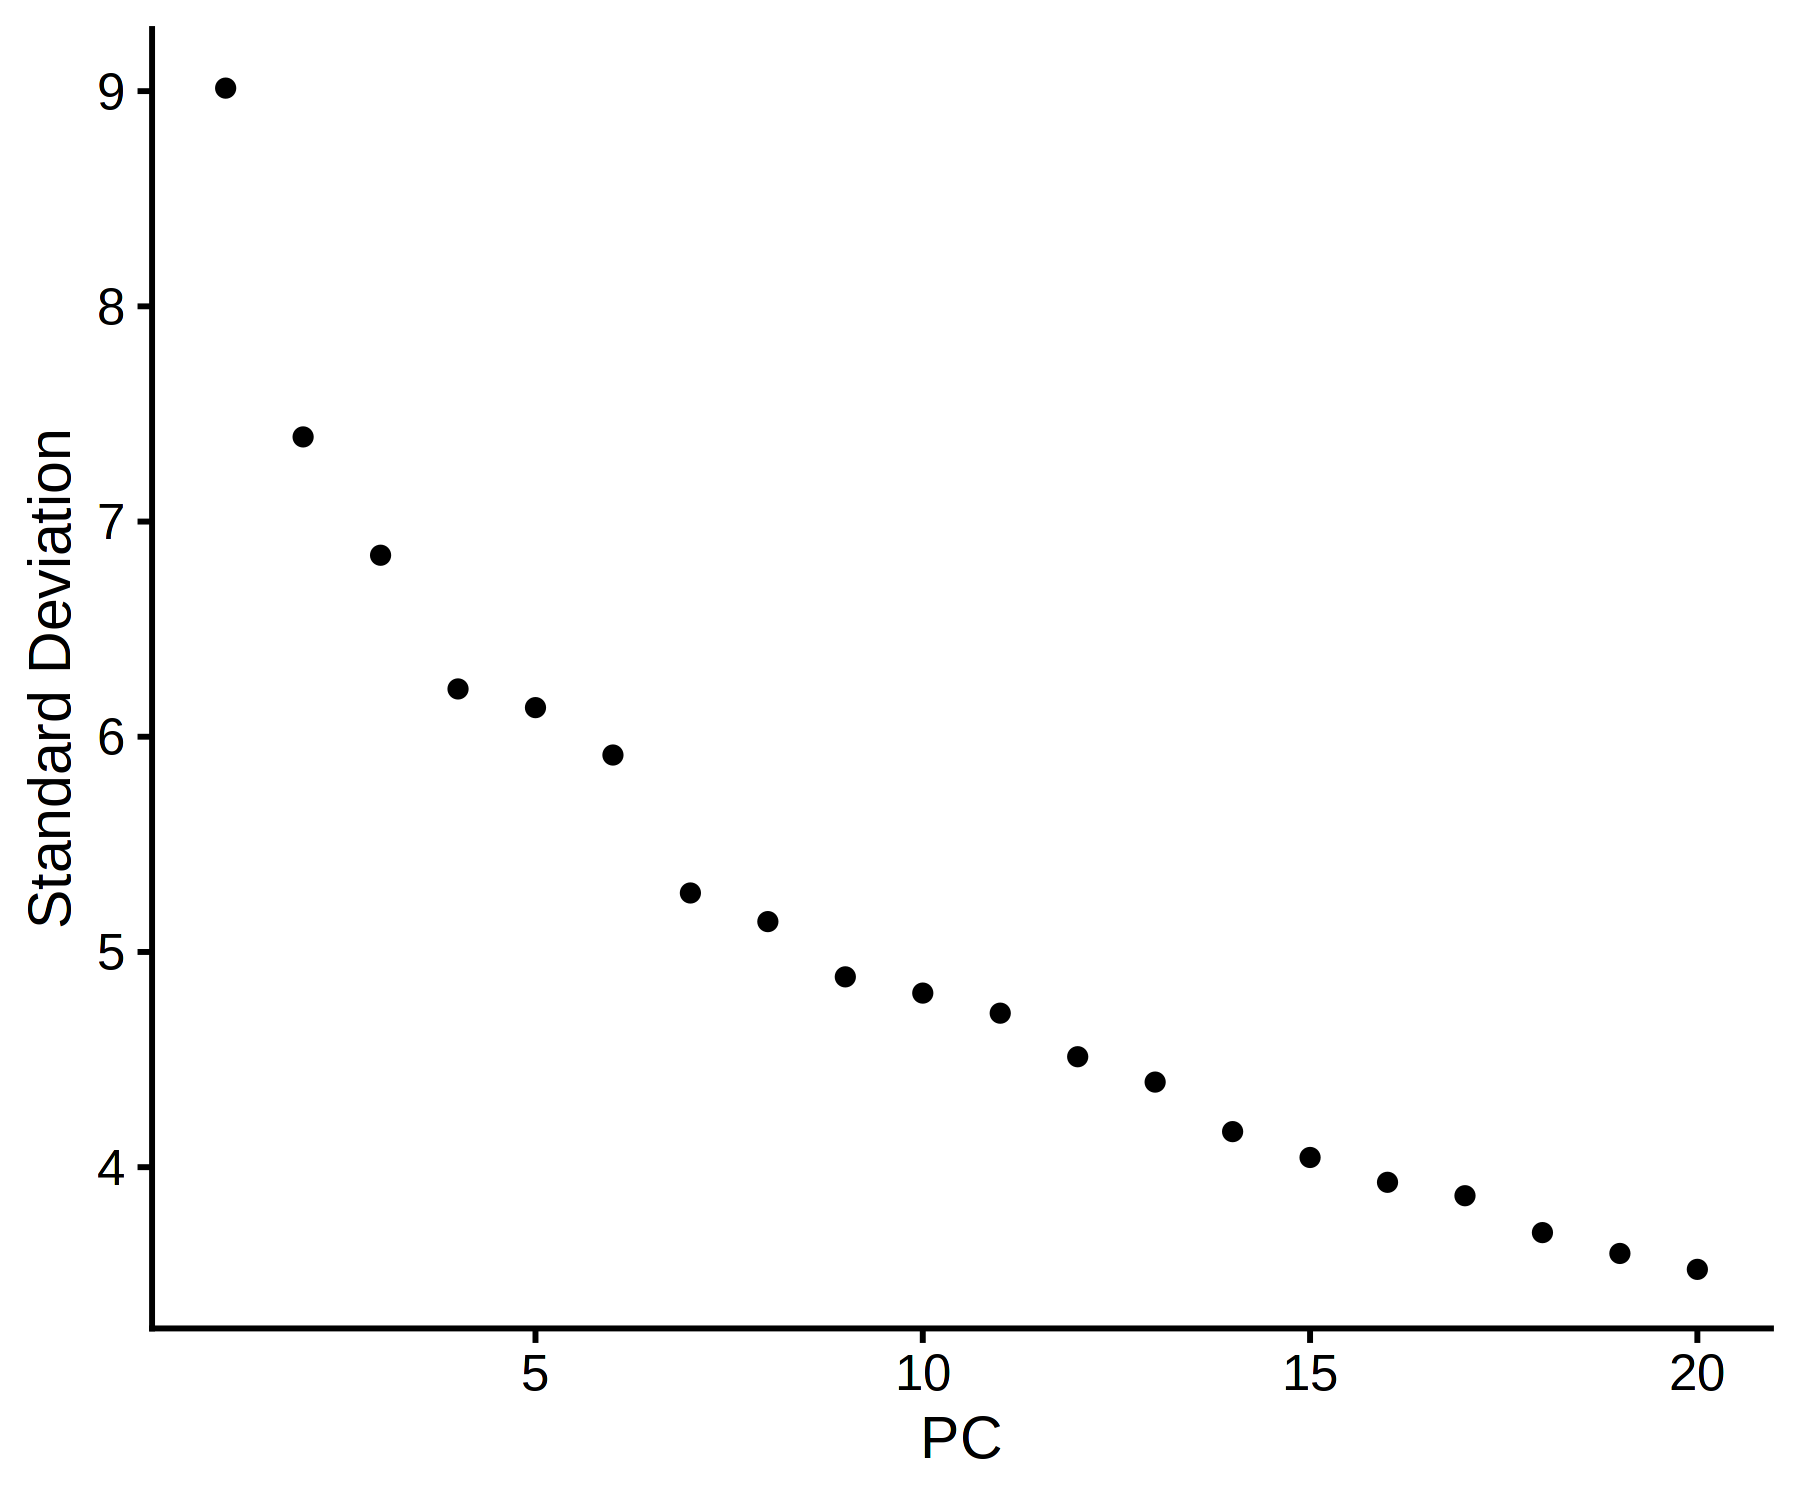

In [293]:
DefaultAssay(TDR118) <- "SCT"

ElbowPlot(TDR118, reduction = "pca")

In [198]:
TDR118 <- RunUMAP(TDR118, reduction = "pca", dims = 1:40)
TDR118 <- FindNeighbors(TDR118, reduction = "pca", dims = 1:40)
TDR118 <- FindClusters(TDR118, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:15:54 UMAP embedding parameters a = 0.9922 b = 1.112

21:15:54 Read 13022 rows and found 40 numeric columns

21:15:54 Using Annoy for neighbor search, n_neighbors = 30

21:15:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:15:56 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07e60bf507d

21:15:56 Searching Annoy index using 10 threads, search_k = 3000

21:15:56 Annoy recall = 100%

21:15:59 Commencing smooth kNN distance calibration using 10 threads

21:16:03 Initializin

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13022
Number of edges: 514291

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9163
Number of communities: 22
Elapsed time: 1 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [298]:
TDR118

An object of class Seurat 
619951 features across 13022 samples within 4 assays 
Active assay: SCT (22693 features, 3000 variable features)
 3 other assays present: RNA, ATAC, peaks_celltype
 6 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap, umap.pca30

In [296]:
TDR118 <- RunUMAP(TDR118, reduction = "pca", dims = 1:30, reduction.name = "umap.pca30")
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(TDR118, group.by = "predicted.id", reduction = "umap.pca30",label = TRUE) + NoLegend() + theme(text = element_text(size = 20 ))

16:21:37 UMAP embedding parameters a = 0.9922 b = 1.112

16:21:37 Read 13022 rows and found 30 numeric columns

16:21:37 Using Annoy for neighbor search, n_neighbors = 30

16:21:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:21:39 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07e3ffd0daa

16:21:39 Searching Annoy index using 10 threads, search_k = 3000

16:21:39 Annoy recall = 100%

16:21:41 Commencing smooth kNN distance calibration using 10 threads

16:21:46 Initializing from normalized Laplacian + noise

16:21:46 Commencing optimization for 200 epochs, with 576500 positive edges

16:21:54 Optimization finished



ERROR: Error in DimPlot(TDR118, group.by = "predicted.id", reduction_names = "umap.pca30", : unused argument (reduction_names = "umap.pca30")


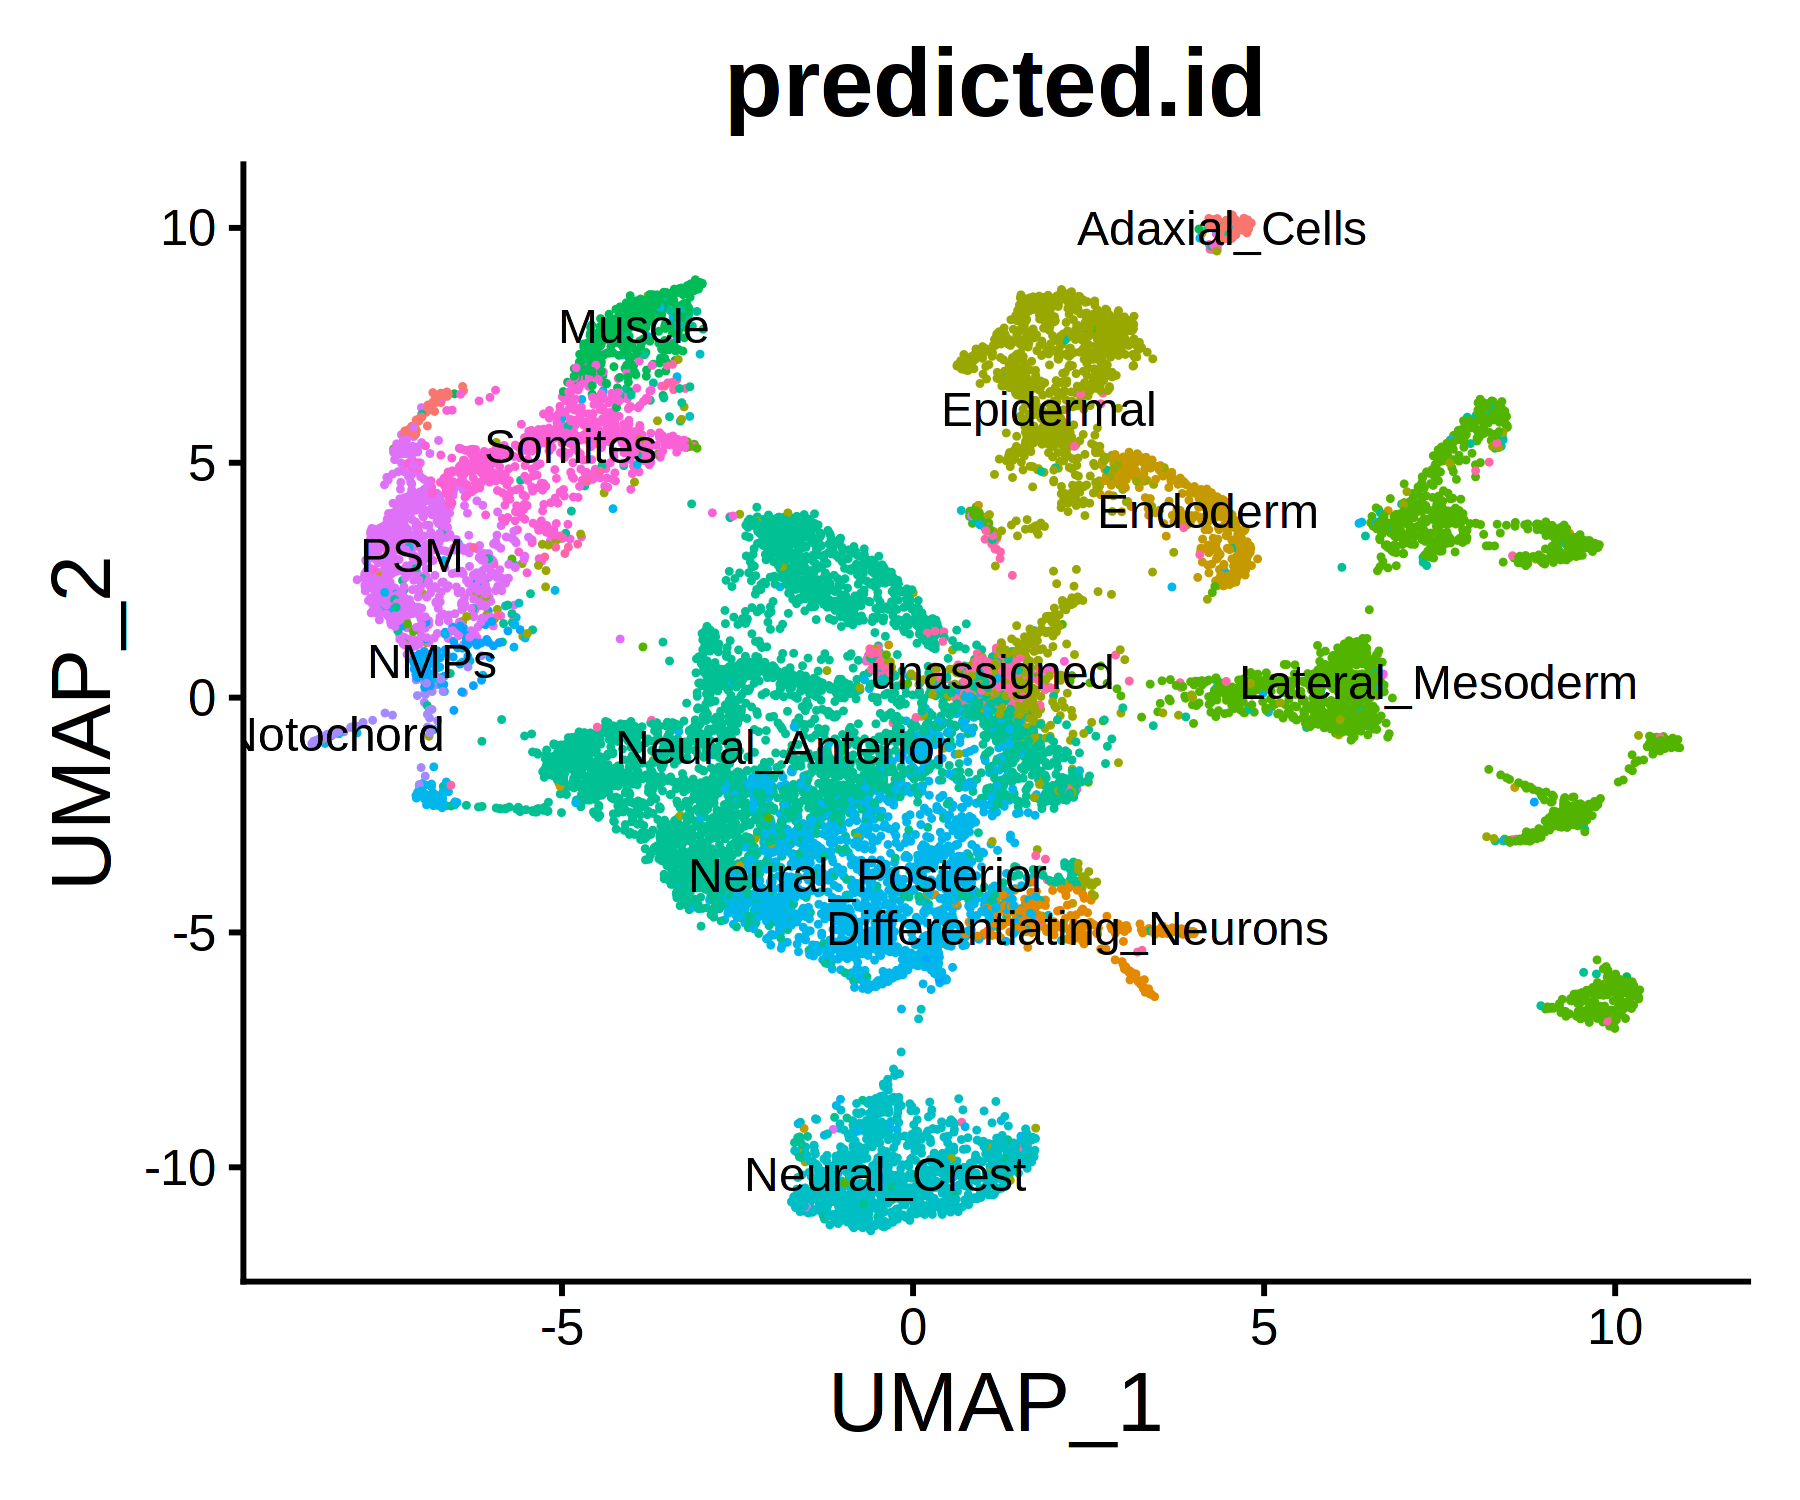

In [299]:
DimPlot(TDR118, group.by = "predicted.id", reduction = "umap.pca30",label = TRUE) + NoLegend() + theme(text = element_text(size = 20 ))

In [295]:
TDR118

An object of class Seurat 
619951 features across 13022 samples within 4 assays 
Active assay: SCT (22693 features, 3000 variable features)
 3 other assays present: RNA, ATAC, peaks_celltype
 5 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap

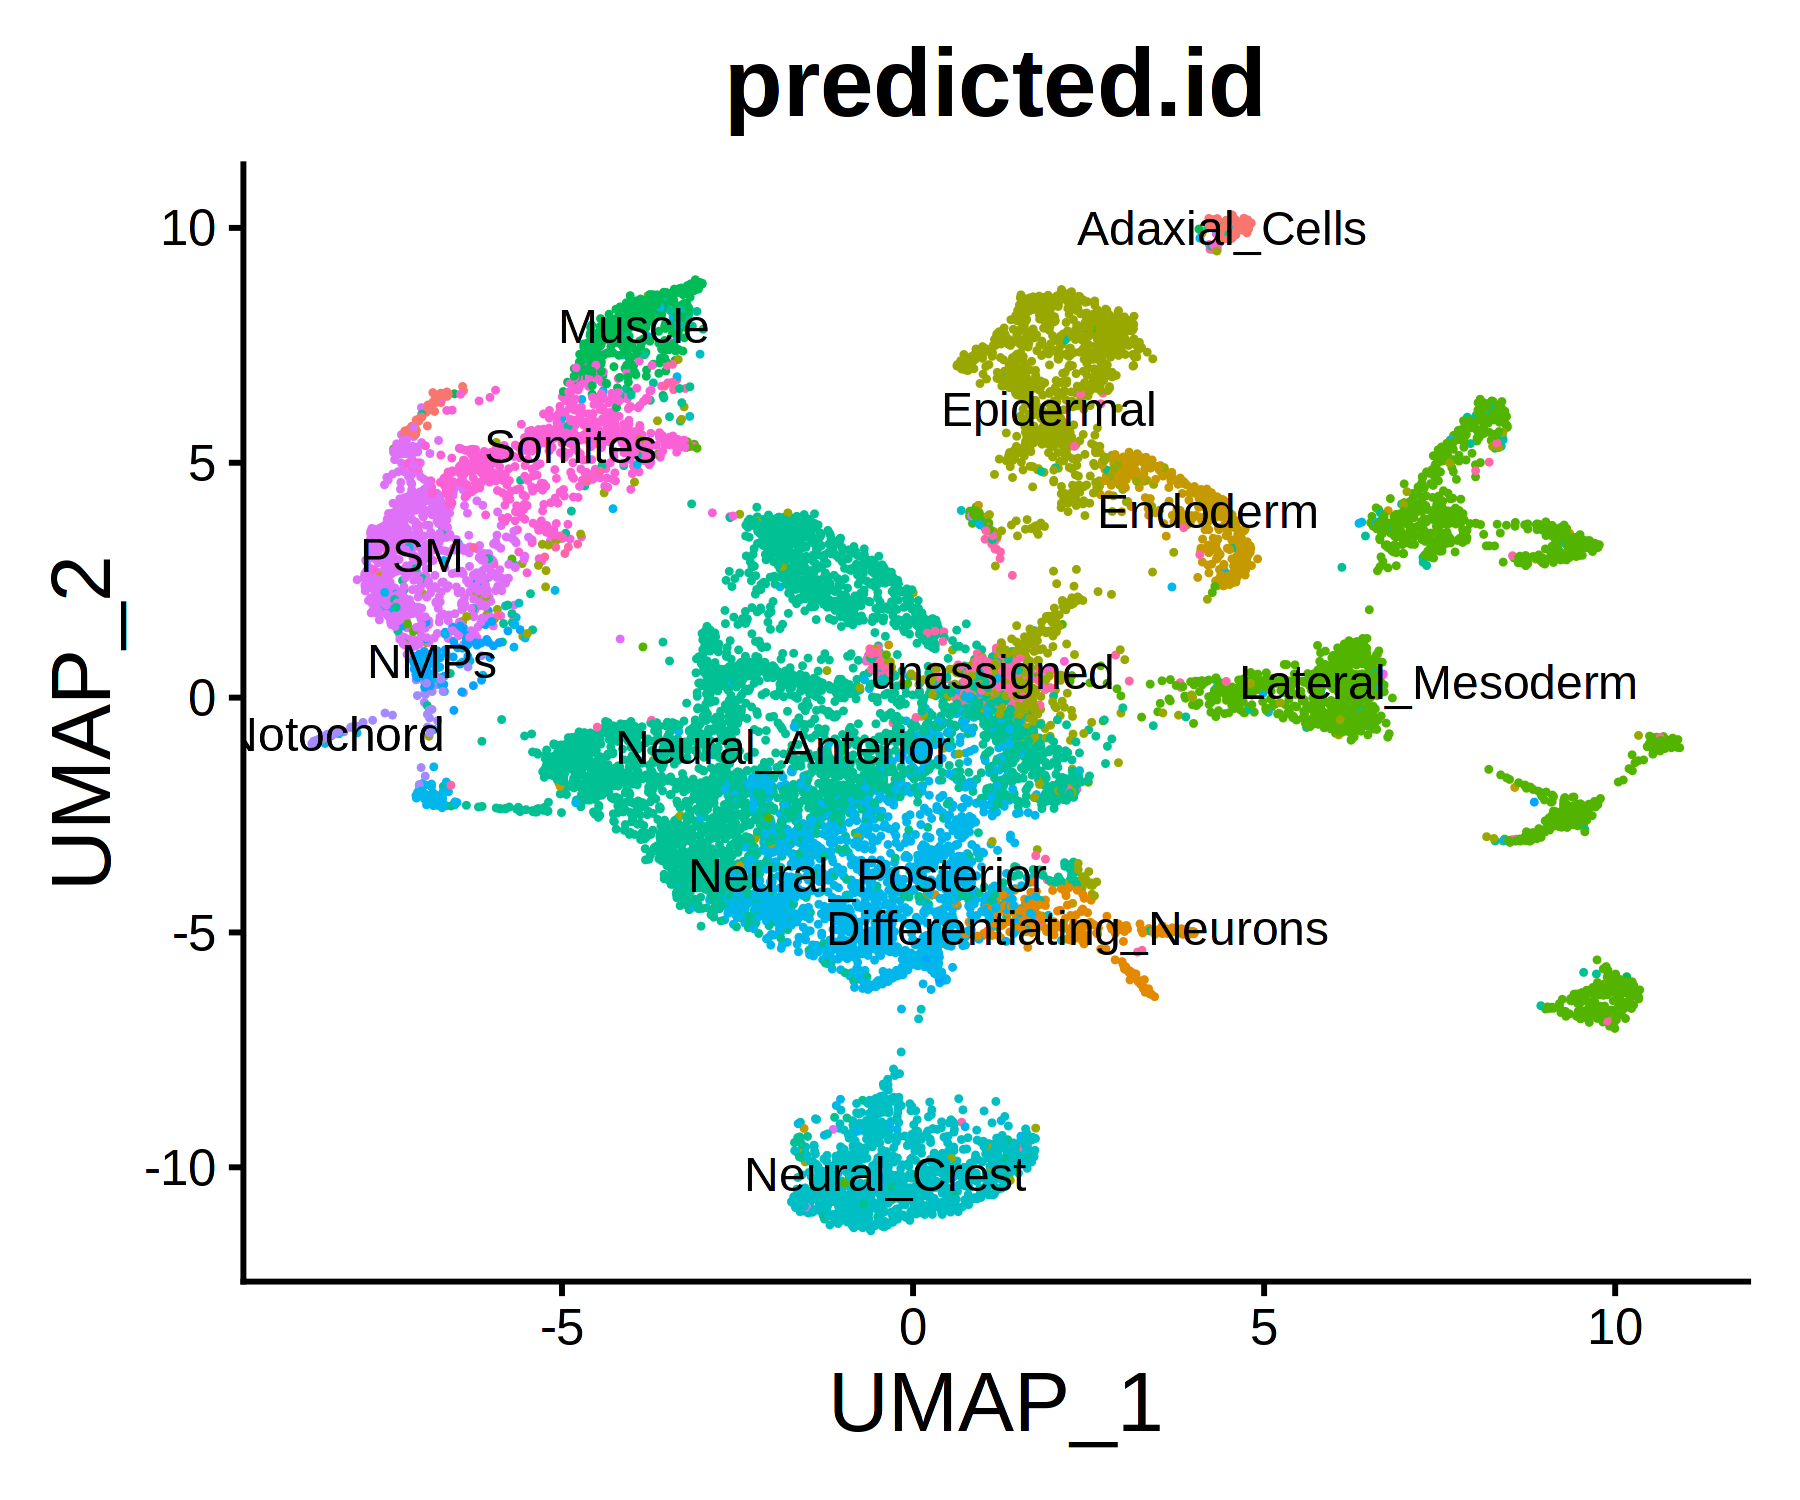

In [300]:
# Plot the UMAP with the predicted cell type labels
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(TDR118, group.by = "predicted.id", reduction = "umap.pca30",label = TRUE) + NoLegend() + theme(text = element_text(size = 20 ))

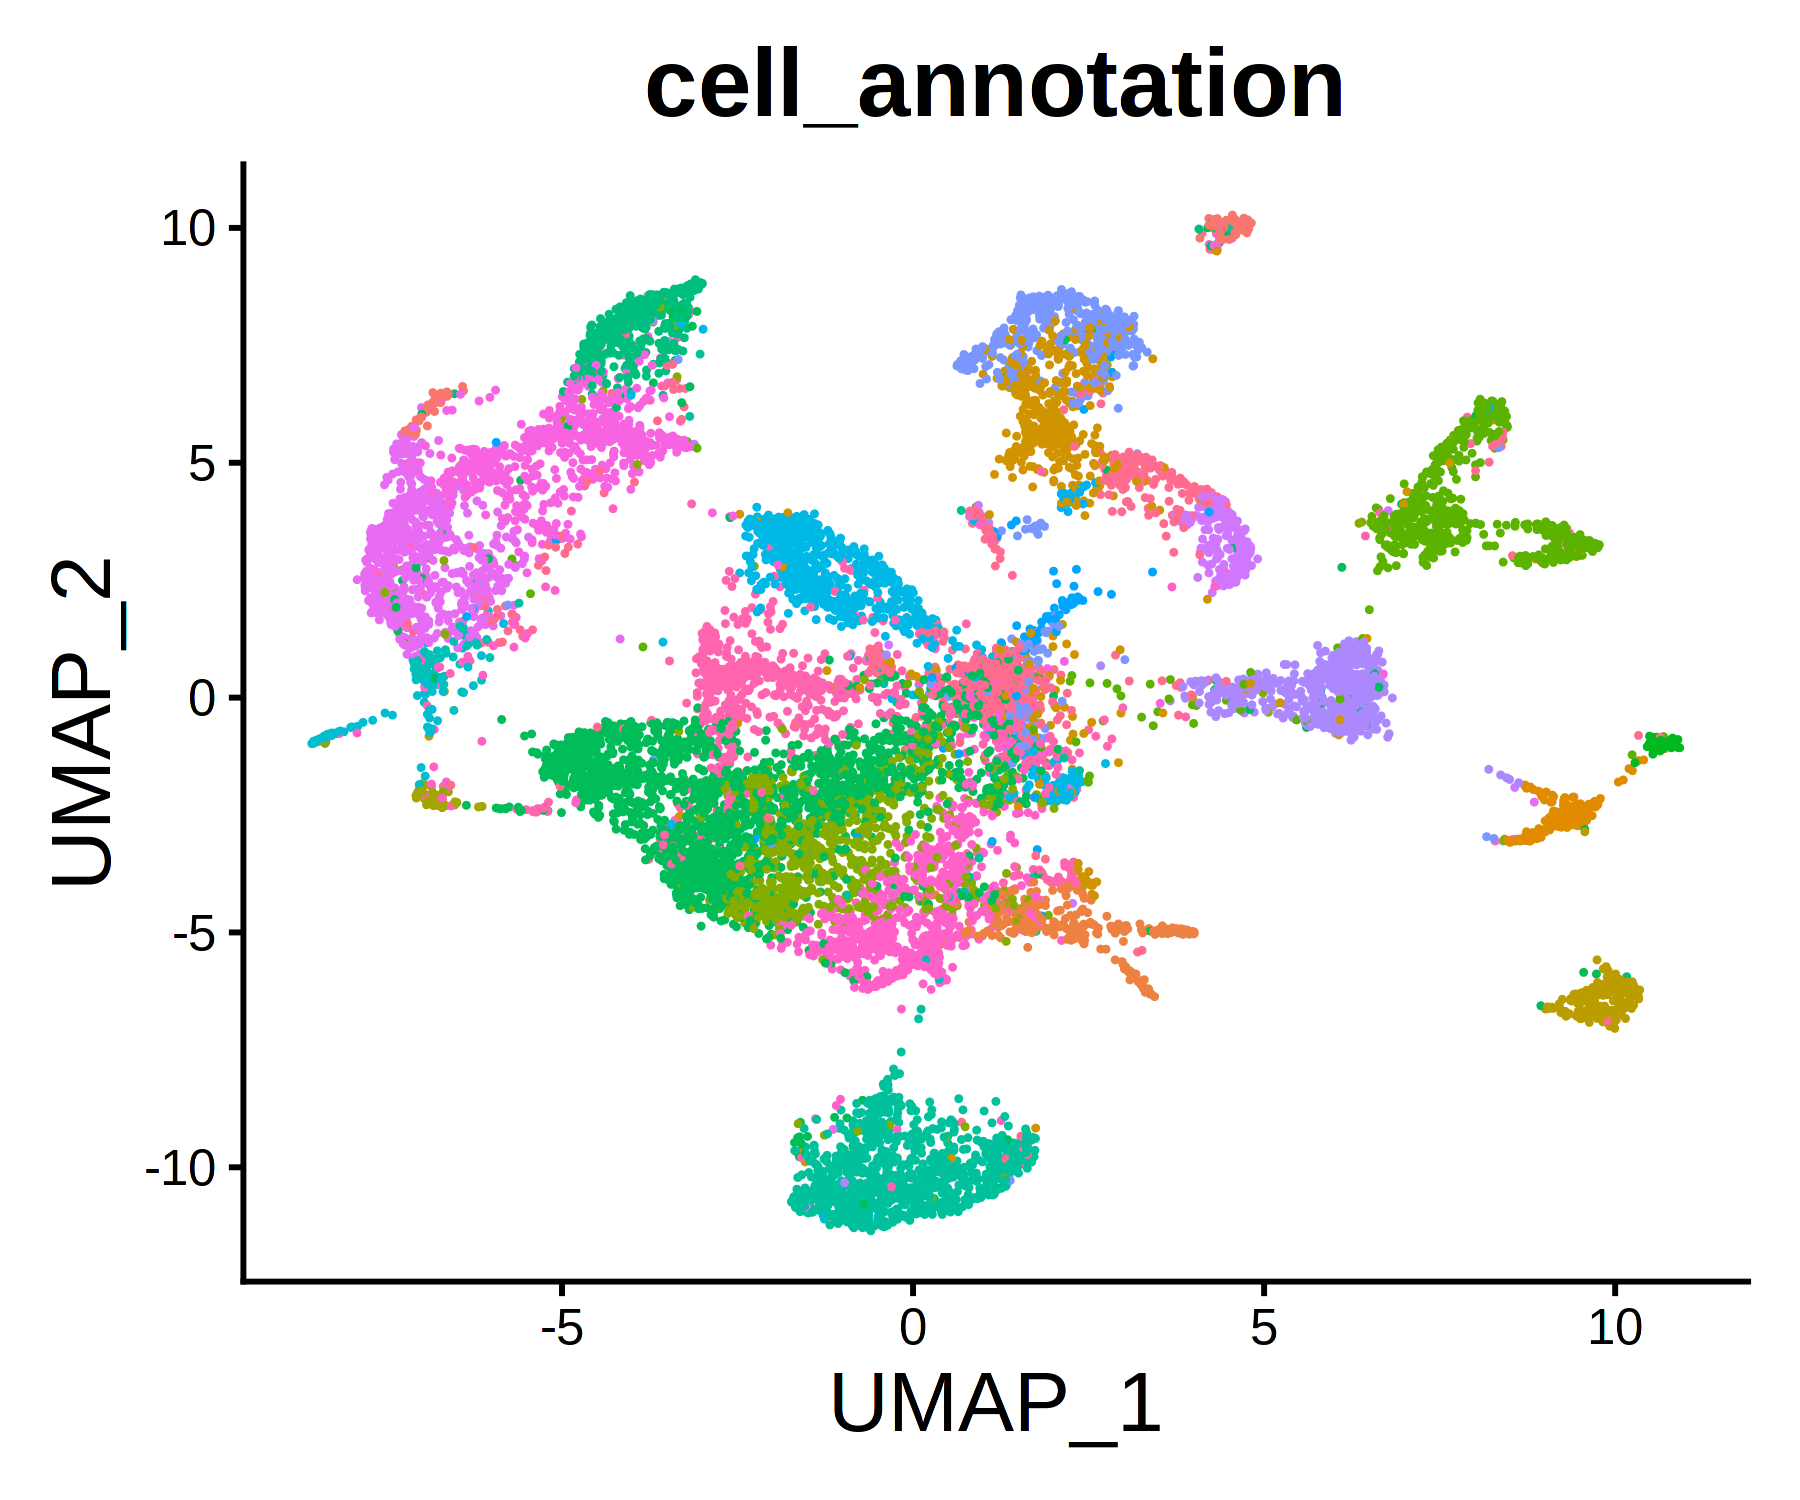

In [302]:
# Plot the UMAP with the predicted cell type labels
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(TDR118, group.by = "cell_annotation", reduction = "umap.pca30") + NoLegend() + theme(text = element_text(size = 20 ))

In [15]:
# # Assuming unique_predicted_ids contains the unique predicted IDs
# unique_predicted_ids <- c('CD4 Naive', 'CD4 TCM', 'CD8 Naive', 'CD16 Mono', 'NK', 'Treg',
#                           'CD14 Mono', 'NK Proliferating', 'CD8 TCM', 'B intermediate',
#                           'cDC2', 'B memory', 'Plasmablast', 'CD4 TEM', 'MAIT',
#                           'CD8 TEM', 'dnT', 'B naive', 'gdT', 'pDC', 'NK_CD56bright',
#                           'CD4 CTL', 'ILC', 'HSPC', 'Eryth', 'cDC1', 'Platelet',
#                           'CD4 Proliferating', 'CD8 Proliferating', 'ASDC')

# # Define the mapping dictionary
# coarse_mapping <- c('CD4 Naive' = 'CD4 T',
#                     'CD4 TCM' = 'CD4 T',
#                     'CD8 Naive' = 'CD8 T',
#                     'CD16 Mono' = 'Monocyte',
#                     'NK' = 'NK',
#                     'Treg' = 'Treg',
#                     'CD14 Mono' = 'Monocyte',
#                     'NK Proliferating' = 'NK',
#                     'CD8 TCM' = 'CD8 T',
#                     'B intermediate' = 'B',
#                     'cDC2' = 'DC',
#                     'B memory' = 'B',
#                     'Plasmablast' = 'Plasmablast',
#                     'CD4 TEM' = 'CD4 T',
#                     'MAIT' = 'MAIT',
#                     'CD8 TEM' = 'CD8 T',
#                     'dnT' = 'T',
#                     'B naive' = 'B',
#                     'gdT' = 'T',
#                     'pDC' = 'DC',
#                     'NK_CD56bright' = 'NK',
#                     'CD4 CTL' = 'CD4 T',
#                     'ILC' = 'ILC',
#                     'HSPC' = 'HSPC',
#                     'Eryth' = 'Eryth',
#                     'cDC1' = 'DC',
#                     'Platelet' = 'Platelet',
#                     'CD4 Proliferating' = 'CD4 T',
#                     'CD8 Proliferating' = 'CD8 T',
#                     'ASDC' = 'ASDC')

# # Map the fine-grained cell labels to coarse labels using the coarse_mapping dictionary
# pbmc$predicted.id.coarse <- coarse_mapping[match(pbmc$predicted.id, names(coarse_mapping))]

# # Print the updated metadata to confirm the changes
# pbmc@meta.data

orig.ident    nCount_RNA nFeature_RNA nCount_ATAC
AAACAGCCAAGGAATC-1 SeuratProject  8380      3308         55582      
AAACAGCCAATCCCTT-1 SeuratProject  3771      1896         20495      
AAACAGCCAATGCGCT-1 SeuratProject  6876      2904         16674      
AAACAGCCACACTAAT-1 SeuratProject  1733       846          2007      
AAACAGCCACCAACCG-1 SeuratProject  5415      2282          7658      
AAACAGCCAGGATAAC-1 SeuratProject  2759      1353         10355      
AAACAGCCAGTAGGTG-1 SeuratProject  7614      3061         39454      
AAACAGCCAGTTTACG-1 SeuratProject  3633      1691         20523      
AAACAGCCATCCAGGT-1 SeuratProject  7782      3028         22412      
AAACATGCAAGGTCCT-1 SeuratProject  3255      1783         22017      
AAACATGCACCGGCTA-1 SeuratProject  2749      1442         19056      
AAACATGCACTTGTTC-1 SeuratProject  2078      1144         15928      
AAACATGCAGCAAGTG-1 SeuratProject  2125      1104         19320      
AAACATGCAGGGAGCT-1 SeuratProject  2986      1569         21069      
AAACCAACACAATGCC-1 SeuratProject  5849      2449         16554      
AAACCAACACTAAGAA-1 SeuratProject 10628      3727         63088      
AAACCAACAGGAACTG-1 SeuratProject  5901      2434         25598      
AAACCAACAGGATGGC-1 SeuratProject  3861      1784         21308      
AAACCAACATAATCCG-1 SeuratProject  7975      3366         42751      
AAACCAACATTGTGCA-1 SeuratProject  5525      2407         21760      
AAACCGAAGCTGGACC-1 SeuratProject  6621      2762         20840      
AAACCGAAGTGAGCAA-1 SeuratProject  1301       947         13188      
AAACCGAAGTTGCGTG-1 SeuratProject  2389      1298         19797      
AAACCGCGTACTTCAC-1 SeuratProject 10327      3919         76664      
AAACCGCGTATGGTGC-1 SeuratProject  2791      1409         22733      
AAACCGCGTCTAACCT-1 SeuratProject  8622      3174         24481      
AAACCGGCACATTAAC-1 SeuratProject 10243      3989         64540      
AAACCGGCATAATCAC-1 SeuratProject  7237      2895         28343      
AAACCGGCATTAGCCA-1 SeuratProject  4839      2241         40657      
AAACGCGCACCTACTT-1 SeuratProject  2462      1336          5232      
⋮                  ⋮             ⋮          ⋮            ⋮          
TTTGTCTAGACAACAG-1 SeuratProject  6489      2937         47320      
TTTGTCTAGAGAGCCG-1 SeuratProject  2758      1431         23603      
TTTGTCTAGCTATTAG-1 SeuratProject  3049      1603         15800      
TTTGTCTAGGACCTGC-1 SeuratProject 10785      3967         47468      
TTTGTCTAGTTCCTGC-1 SeuratProject  3762      1799         20644      
TTTGTGAAGCGATACT-1 SeuratProject  4066      1988         25375      
TTTGTGAAGCTTAACA-1 SeuratProject  5908      2321         20146      
TTTGTGAAGGAACGGT-1 SeuratProject  4497      2110         24606      
TTTGTGAAGGGATTAG-1 SeuratProject  3288      1662         17837      
TTTGTGGCAAACAACA-1 SeuratProject  4215      1975         17748      
TTTGTGGCAAGTGTCC-1 SeuratProject  5383      2447         18716      
TTTGTGGCACAGACTC-1 SeuratProject  6933      2723         40147      
TTTGTGGCAGCAACCT-1 SeuratProject  3820      1951         32497      
TTTGTGTTCAAACCTA-1 SeuratProject 11249      3793         23243      
TTTGTGTTCAATTACG-1 SeuratProject  3672      1895         19173      
TTTGTGTTCATTGACA-1 SeuratProject  3877      1793         24235      
TTTGTGTTCCTCCTAA-1 SeuratProject  7422      2892         21048      
TTTGTGTTCGATAACC-1 SeuratProject  3208      1691         23197      
TTTGTGTTCGATTTAG-1 SeuratProject  3471      1604          1172      
TTTGTGTTCGGGACCT-1 SeuratProject  3184      1590         23636      
TTTGTGTTCGGTCAAT-1 SeuratProject  5165      2189         41862      
TTTGTGTTCGTCAAGT-1 SeuratProject  6372      2651         23518      
TTTGTGTTCTCCATAT-1 SeuratProject  5803      2499         35213      
TTTGTTGGTCAGGAAG-1 SeuratProject  4690      2049          7803      
TTTGTTGGTCCACAAA-1 SeuratProject 10194      3058          7595      
TTTGTTGGTGACATGC-1 SeuratProject  3285      1586         15272      
TTTGTTGGTGTTAAAC-

In [226]:
TDR118@meta.data

orig.ident    nCount_RNA nFeature_RNA nCount_ATAC
AAACAGCCACCTAAGC-1 SeuratProject 2731       1273         21425      
AAACAGCCAGGGAGGA-1 SeuratProject 2520       1179         10334      
AAACAGCCATAGACCC-1 SeuratProject 5281       1922         51485      
AAACATGCAAACTCAT-1 SeuratProject 2217       1073         19812      
AAACATGCAAGGACCA-1 SeuratProject 1060        411          5182      
AAACATGCAAGGATTA-1 SeuratProject 1771        902         24072      
AAACATGCACGTTACA-1 SeuratProject 1718        957         25566      
AAACATGCAGGACCTT-1 SeuratProject 5604       1682          8685      
AAACATGCAGGCGATA-1 SeuratProject 2106        404         15465      
AAACATGCAGTTTCTC-1 SeuratProject 1652        750         25357      
AAACATGCATAGGCGA-1 SeuratProject 1214        587         31242      
AAACCAACAGAGGGAG-1 SeuratProject 1983        967         37611      
AAACCAACAGATTCAT-1 SeuratProject 2052       1064          5141      
AAACCAACAGCAGGTA-1 SeuratProject 1345        728         21560      
AAACCAACATCACTTC-1 SeuratProject 2516       1376         32024      
AAACCAACATGTCAAT-1 SeuratProject 2557        971         10099      
AAACCGAAGATAAAGC-1 SeuratProject 2137       1079          8988      
AAACCGAAGCACGATT-1 SeuratProject 4914       1897         36307      
AAACCGAAGCACTAAC-1 SeuratProject 1649        707          8576      
AAACCGAAGCCTGAGC-1 SeuratProject 2376       1184         77966      
AAACCGAAGGGTGAGT-1 SeuratProject 3170       1297         25490      
AAACCGAAGTAAACCC-1 SeuratProject 1578        671         37780      
AAACCGAAGTCATCCC-1 SeuratProject 2008       1203          4906      
AAACCGCGTCAAGTAT-1 SeuratProject 1248        586         25905      
AAACCGCGTCTTTATG-1 SeuratProject 3746       1675          2969      
AAACCGCGTTAGACCA-1 SeuratProject 1786        728         29534      
AAACCGCGTTATCCGT-1 SeuratProject 2461       1119         24004      
AAACCGCGTTCAAGAT-1 SeuratProject 2635       1121         35498      
AAACCGGCAAAGCGGC-1 SeuratProject 2502       1161         47565      
AAACCGGCAAAGGTAC-1 SeuratProject 1549        680         22059      
⋮                  ⋮             ⋮          ⋮            ⋮          
TTTGTCTAGGTCCTAG-1 SeuratProject 5570       1953          8478      
TTTGTCTAGGTCGATT-1 SeuratProject 1150        571          8001      
TTTGTCTAGTTCCTCA-1 SeuratProject 1055        581         28166      
TTTGTGAAGAACAAGT-1 SeuratProject 2666       1163         13696      
TTTGTGAAGCTGTCAG-1 SeuratProject 4702       1644         11054      
TTTGTGAAGGCATTAC-1 SeuratProject 3008       1237         44166      
TTTGTGAAGGGTTAGA-1 SeuratProject 5462       1877         19766      
TTTGTGAAGTCAGGCC-1 SeuratProject 4467       1583         12290      
TTTGTGGCACAAAGCG-1 SeuratProject 2091       1053         35191      
TTTGTGGCACAACCTA-1 SeuratProject 2829       1175         23044      
TTTGTGGCACGTTACA-1 SeuratProject 1956       1131         45592      
TTTGTGGCAGCTTAGC-1 SeuratProject 1546        559         18969      
TTTGTGGCAGGCATCT-1 SeuratProject 1269        576          4952      
TTTGTGGCATGTCAAT-1 SeuratProject 2877       1164         29668      
TTTGTGGCATTAGGCC-1 SeuratProject 7272       2612         66386      
TTTGTGGCATTGCAGC-1 SeuratProject 3205       1423         26096      
TTTGTGTTCACGCATG-1 SeuratProject 2041        816         16996      
TTTGTGTTCCCTCATA-1 SeuratProject 1239        571         28338      
TTTGTGTTCCGCAAGC-1 SeuratProject 1574        789         13465      
TTTGTGTTCGAGGAAC-1 SeuratProject 1602        753         28186      
TTTGTGTTCGAGGTGG-1 SeuratProject 1233        616         52259      
TTTGTGTTCGCTAAGT-1 SeuratProject 3968       1616         10517      
TTTGTTGGTAAAGCAA-1 SeuratProject 1285        713          2986      
TTTGTTGGTAATAACC-1 SeuratProject 1994        956          4587      
TTTGTTGGTAGGTGTC-1 SeuratProject 2019       1023         41629      
TTTGTTGGTCGACTCC-1 SeuratProject 1610        898          2076      
TTTGTTGGTGATTTGG-

# Step 3.  Peak calling (cell-type specific)

Signac: The set of peaks identified using Cellranger often merges distinct peaks that are close together. This can create a problem for certain analyses, particularly motif enrichment analysis and peak-to-gene linkage. To identify a more accurate set of peaks, we can call peaks using MACS2 with the CallPeaks() function. Here we call peaks on all cells together, but we could identify peaks for each group of cells separately by setting the group.by parameter, and this can help identify peaks specific to rare cell populations.

Peak calling should be done with different options, then should be compared with each other using "Coverage plot"

- bulk (MACS2)
- cell type (coarse, MACS2)
- cell type (fine, MACS2)
- etc.


Note. Peak-calling is quite computationally heavy, it might be a good idea to run it on HPC.

In [3]:
TDR118<-readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/TDR118_processed.rds")
TDR118

An object of class Seurat 
1055655 features across 13022 samples within 5 assays 
Active assay: ATAC (248320 features, 248320 variable features)
 4 other assays present: RNA, SCT, peaks_celltype, peaks_bulk
 8 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap, umap.pca30, lsi.cellranger, atac.umap.cellranger

In [4]:
TDR118

An object of class Seurat 
1055655 features across 13022 samples within 5 assays 
Active assay: ATAC (248320 features, 248320 variable features)
 4 other assays present: RNA, SCT, peaks_celltype, peaks_bulk
 8 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap, umap.pca30, lsi.cellranger, atac.umap.cellranger

In [45]:
TDR118@assays$ATAC@fragments[[1]]

A Fragment object for 13022 cells

In [52]:
Fragments(TDR118)[[1]]@path

[1] "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"

In [229]:
# Change the Default Assay to "ATAC" for calling peaks
DefaultAssay(TDR118) <- "ATAC"

In [230]:
# call peaks using the fine annotation (predicted)
peaks <- CallPeaks(
  object = TDR118,
  group.by = "predicted.id"
)

Processing file /data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz






In [251]:
# Choose a set of peaks from the above Coverage Plot, then create a new object to replace the original ATAC object
peaks <- peaks

# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks <- keepStandardChromosomes(peaks, pruning.mode = "coarse")
# peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_hg38_unified, invert = TRUE)

# quantify counts in each peak
macs2_counts <- FeatureMatrix(
  fragments = Fragments(TDR118),
  features = peaks,
  cells = colnames(TDR118)
)

# create a new assay using the MACS2 peak set and add it to the Seurat object
TDR118[["peaks_celltype"]] <- CreateChromatinAssay(
  counts = macs2_counts,
  fragments = fragpath,
  annotation = annotation
)

Extracting reads overlapping genomic regions

Computing hash

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks_celltype_ to peakscelltype_”


In [252]:
TDR118

An object of class Seurat 
619951 features across 13022 samples within 4 assays 
Active assay: ATAC (248320 features, 0 variable features)
 3 other assays present: RNA, SCT, peaks_celltype
 2 dimensional reductions calculated: pca, umap

In [254]:
DefaultAssay(TDR118)<-"peaks_celltype"
TDR118

An object of class Seurat 
619951 features across 13022 samples within 4 assays 
Active assay: peaks_celltype (316881 features, 0 variable features)
 3 other assays present: RNA, ATAC, SCT
 2 dimensional reductions calculated: pca, umap

In [255]:
# preprocess the data (dim.reduction for UMAP)
TDR118 <- FindTopFeatures(TDR118, min.cutoff = 5)
TDR118 <- RunTFIDF(TDR118)
TDR118 <- RunSVD(TDR118)


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

10:28:33 UMAP embedding parameters a = 0.9922 b = 1.112

10:28:33 Read 13022 rows and found 39 numeric columns

10:28:33 Using Annoy for neighbor search, n_neighbors = 30

10:28:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:28:35 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07eaeeb6dc

10:28:35 Searching Annoy index using 10 threads, search_k = 3000

10:28:35 Annoy recall = 100%

10:28:40 Commencing smooth kNN distance calibration using 10 threads

10:28:45 Initializing from normalized Laplacian + noise

10:28:46 Commencing optimization for 200 epochs, with 529542 positive edges

10:28:54 Optimization finished

Warning message:
“Cannot add objects with duplicate keys (offending ke

In [282]:
TDR118

An object of class Seurat 
619951 features across 13022 samples within 4 assays 
Active assay: peaks_celltype (316881 features, 316880 variable features)
 3 other assays present: RNA, ATAC, SCT
 5 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap

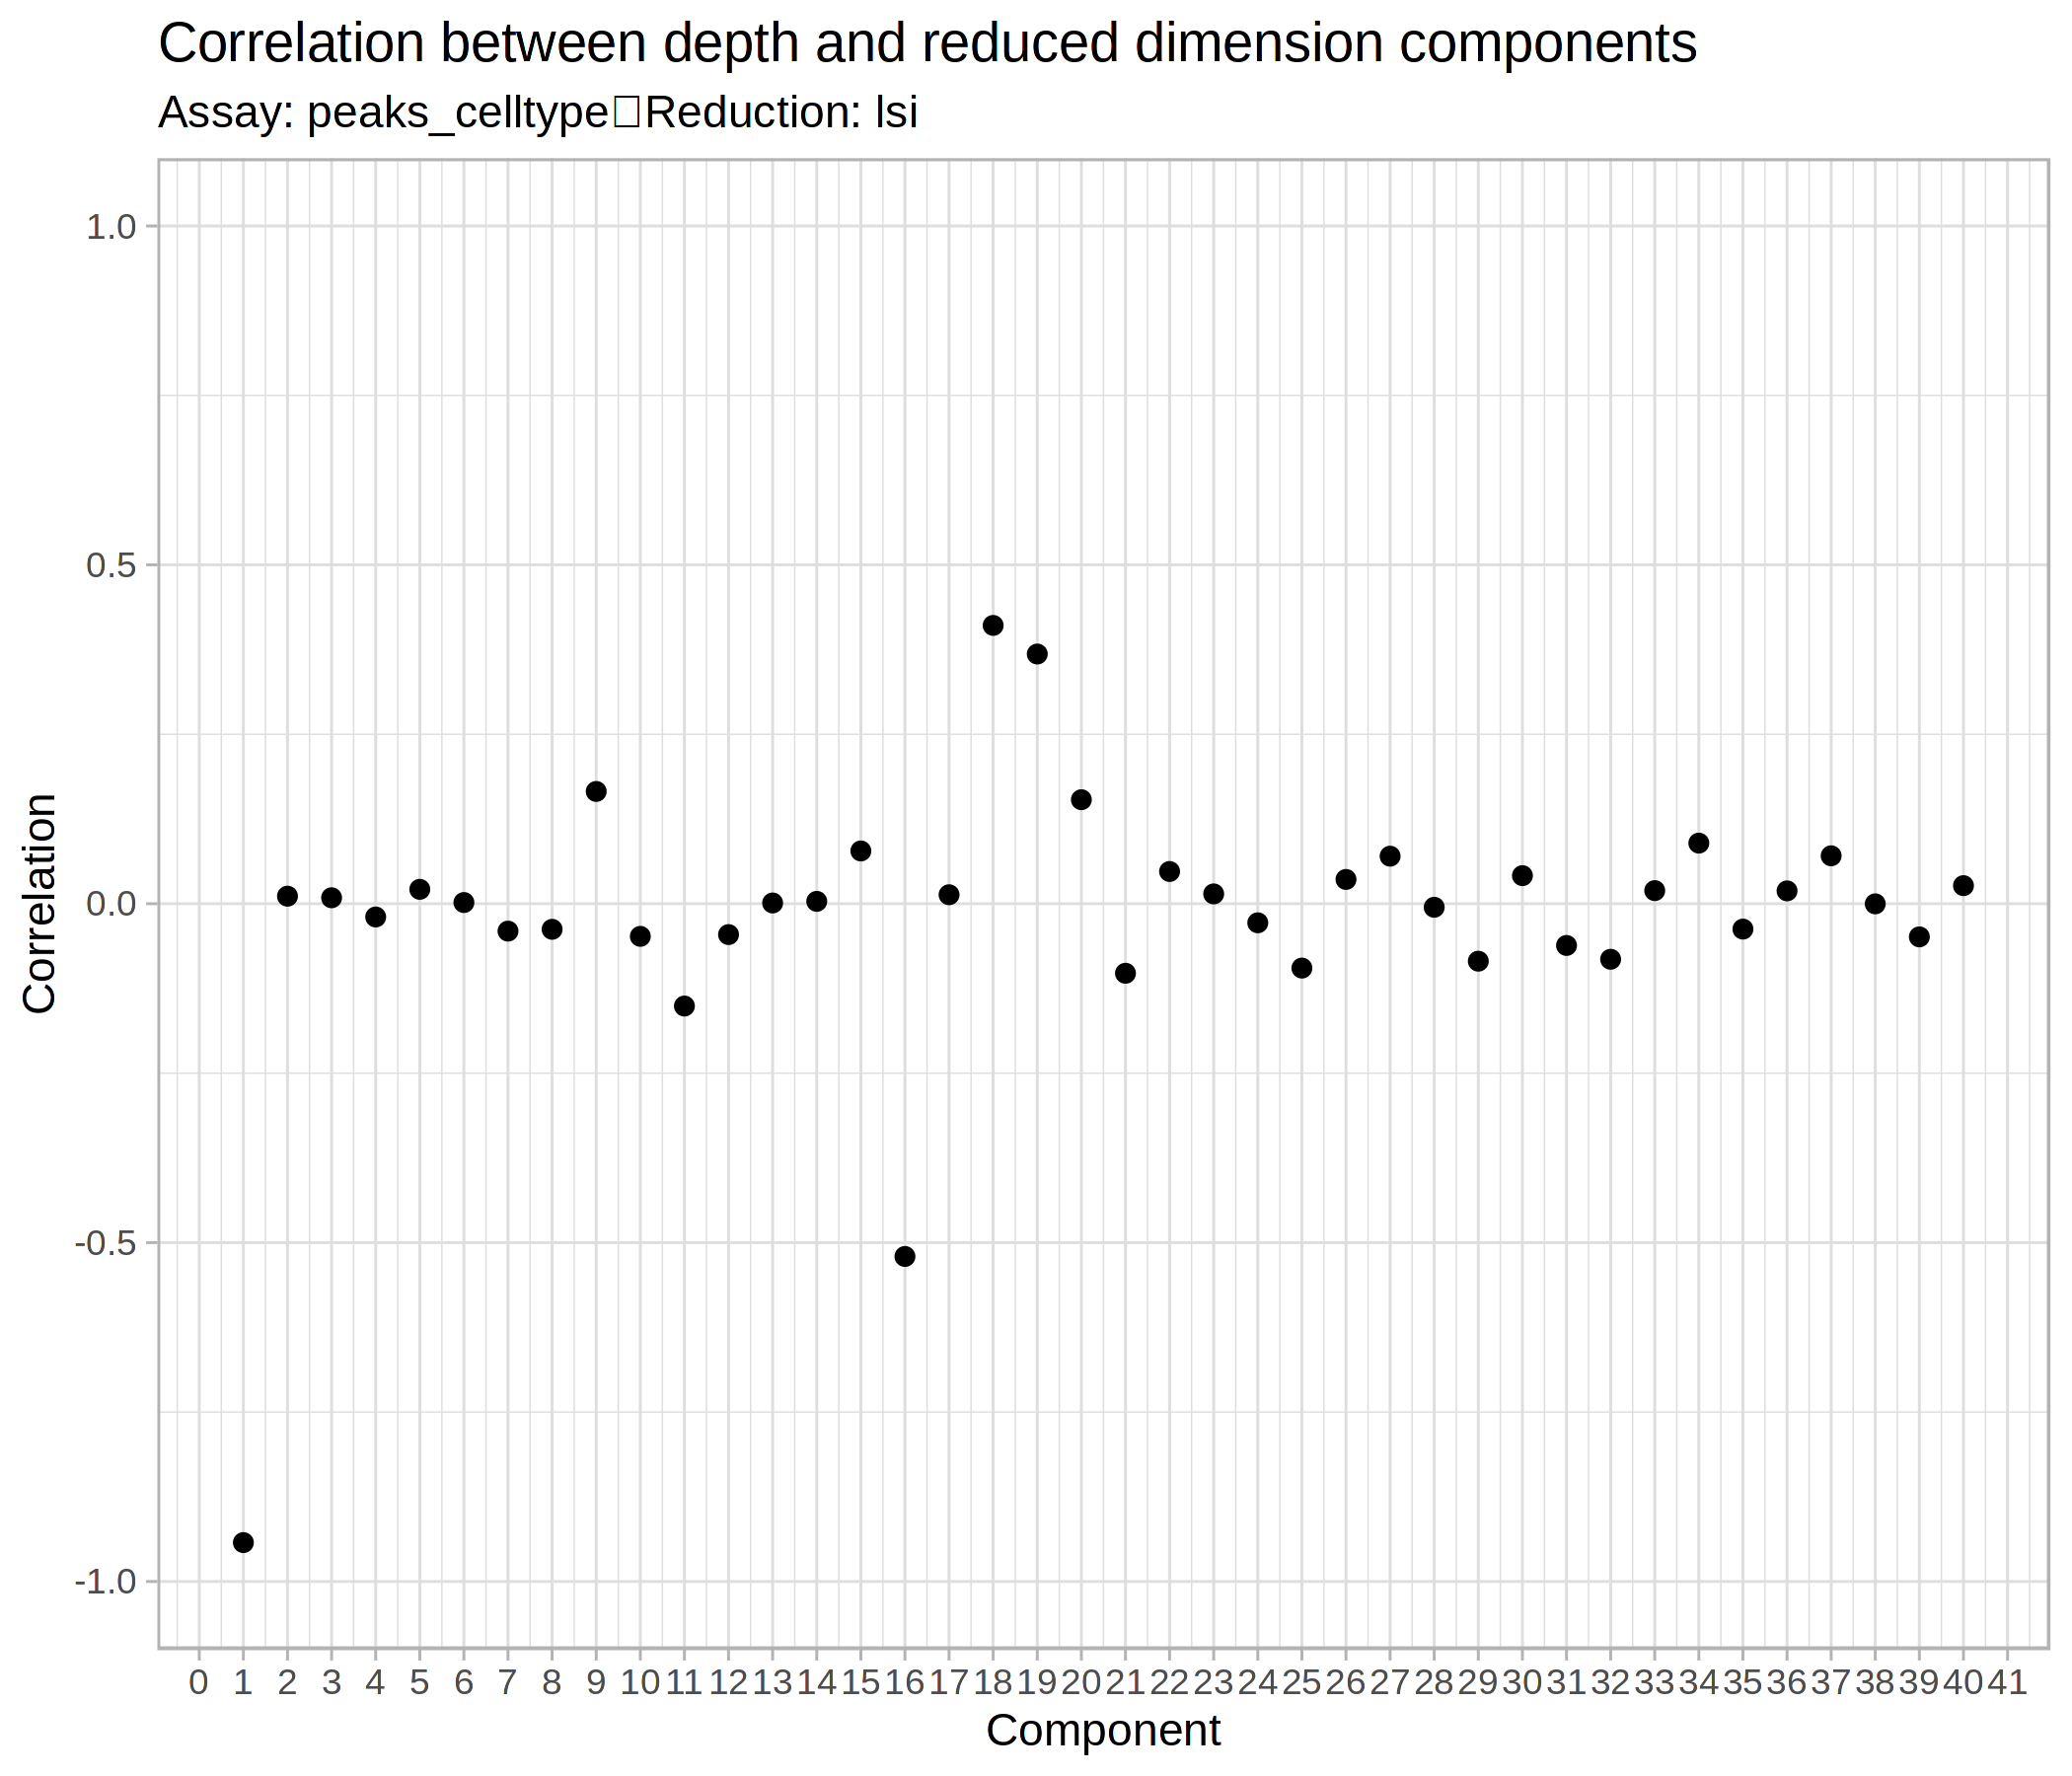

In [284]:
# Check the LSI dimensionality reduction
DepthCor(TDR118, n=40) 

### NOTE
We will get rid of the LSI components whose absolute values are close or higher than 0.5

In [286]:
# UMAP
TDR118 <- RunUMAP(TDR118, reduction = 'lsi', dims = c(2:15,17,20:40), assay = 'peaks_celltype', 
              reduction.name = 'atac.umap')

16:10:41 UMAP embedding parameters a = 0.9922 b = 1.112

16:10:41 Read 13022 rows and found 36 numeric columns

16:10:41 Using Annoy for neighbor search, n_neighbors = 30

16:10:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:10:43 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07e1ce7b782

16:10:43 Searching Annoy index using 10 threads, search_k = 3000

16:10:43 Annoy recall = 100%

16:10:46 Commencing smooth kNN distance calibration using 10 threads

16:10:51 Initializing from normalized Laplacian + noise

16:10:51 Commencing optimization for 200 epochs, with 533494 positive edges

16:10:59 Optimization finished

Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_) setting key to original value 'atac.umap_'”


In [326]:
# options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
# DimPlot(TDR118, reduction = "atac.umap", label=TRUE, group.by = "predicted.id") + NoLegend()+ theme(text = element_text(size = 20 ))

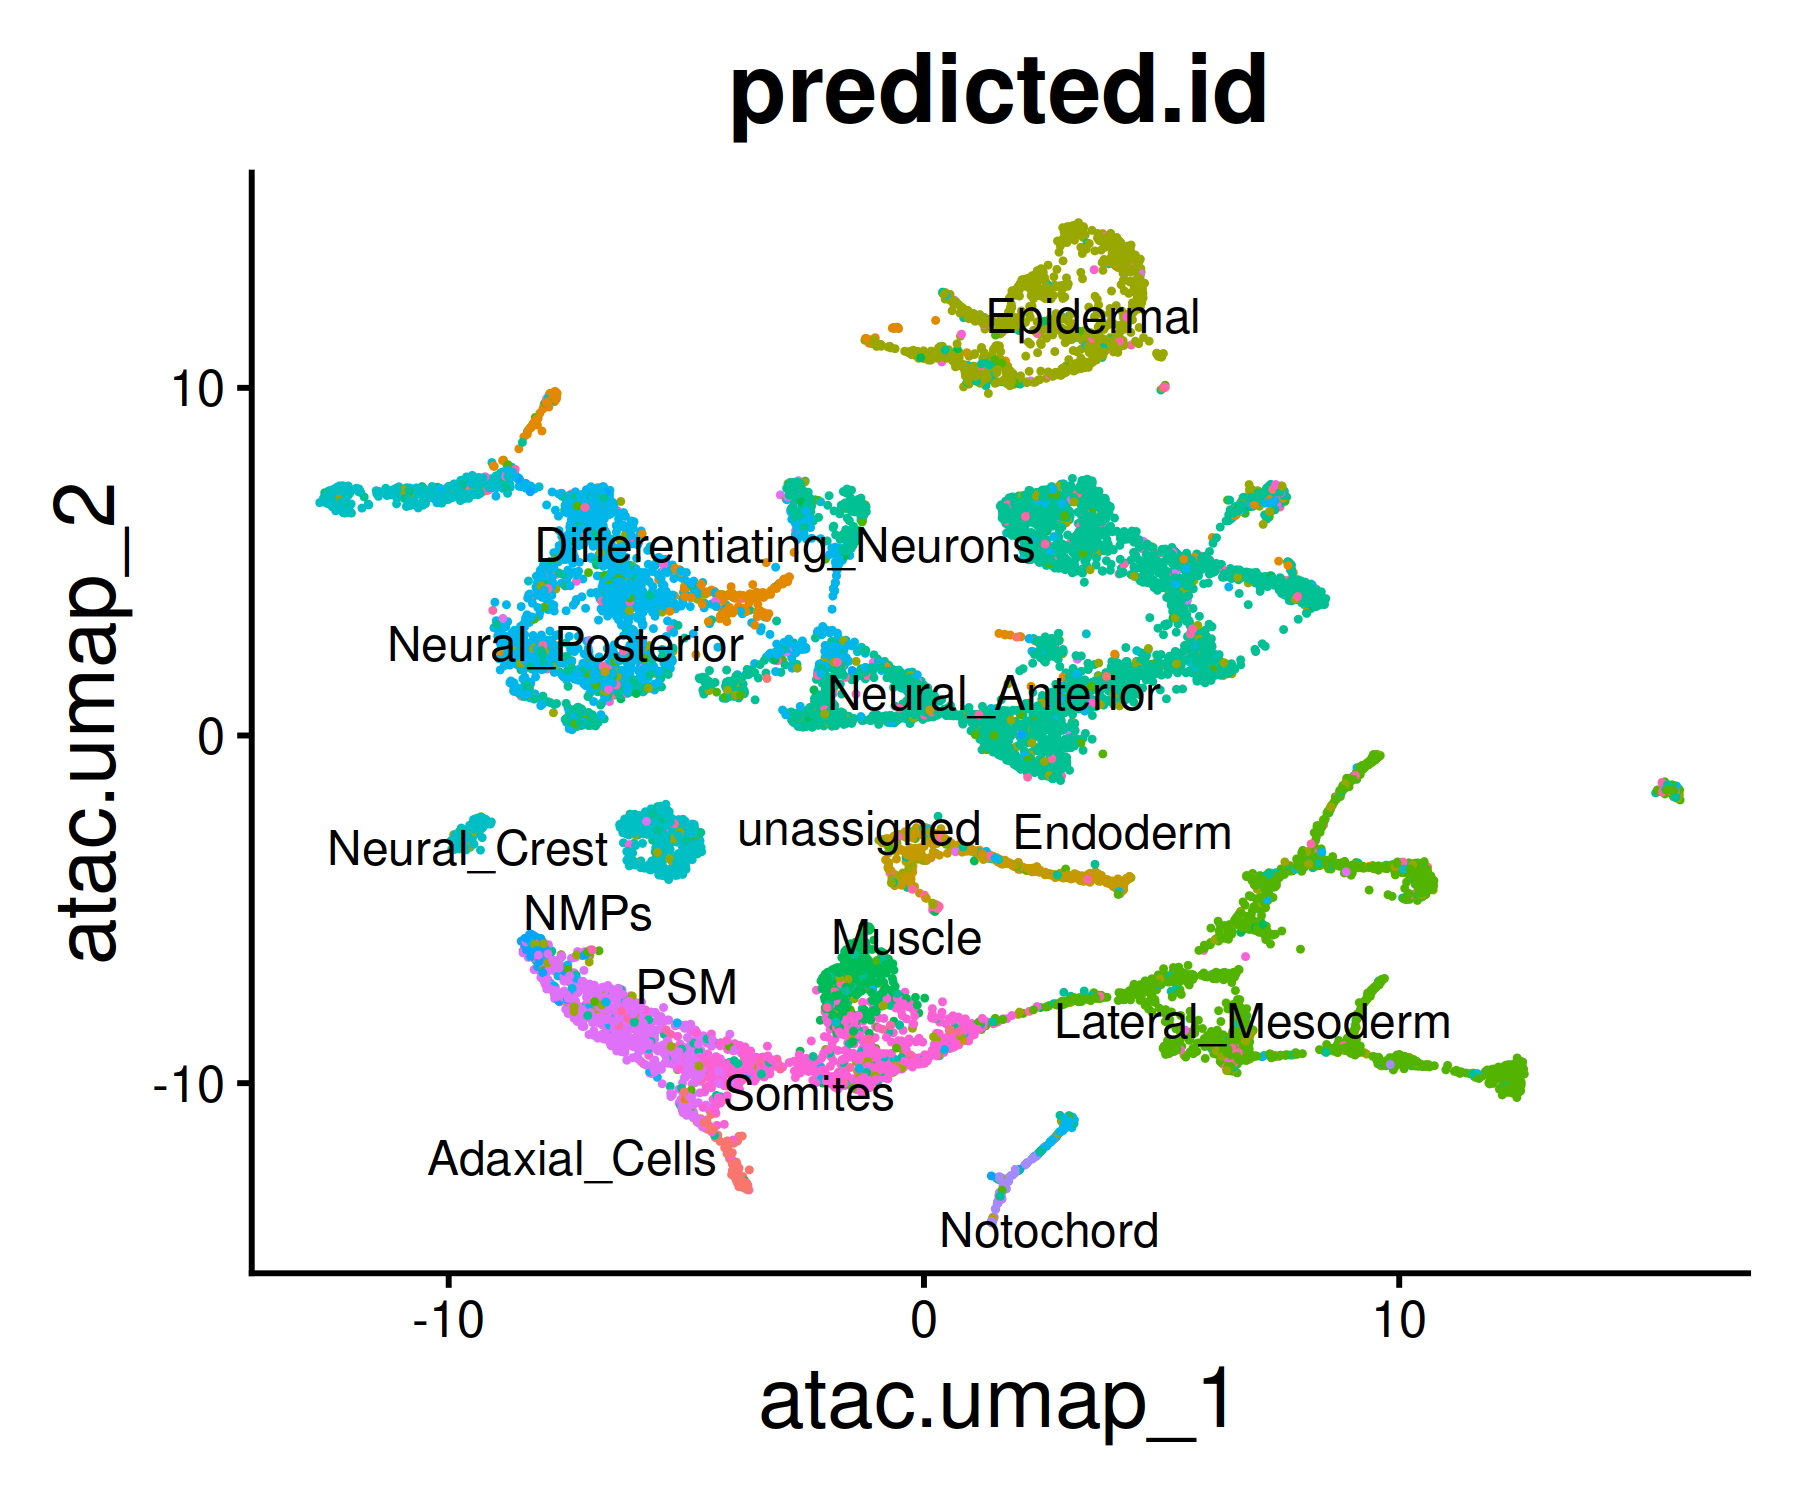

In [5]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(TDR118, reduction = "atac.umap", group.by = "predicted.id", label = TRUE, repel=TRUE) + NoLegend() +  theme(text = element_text(size = 20 ))

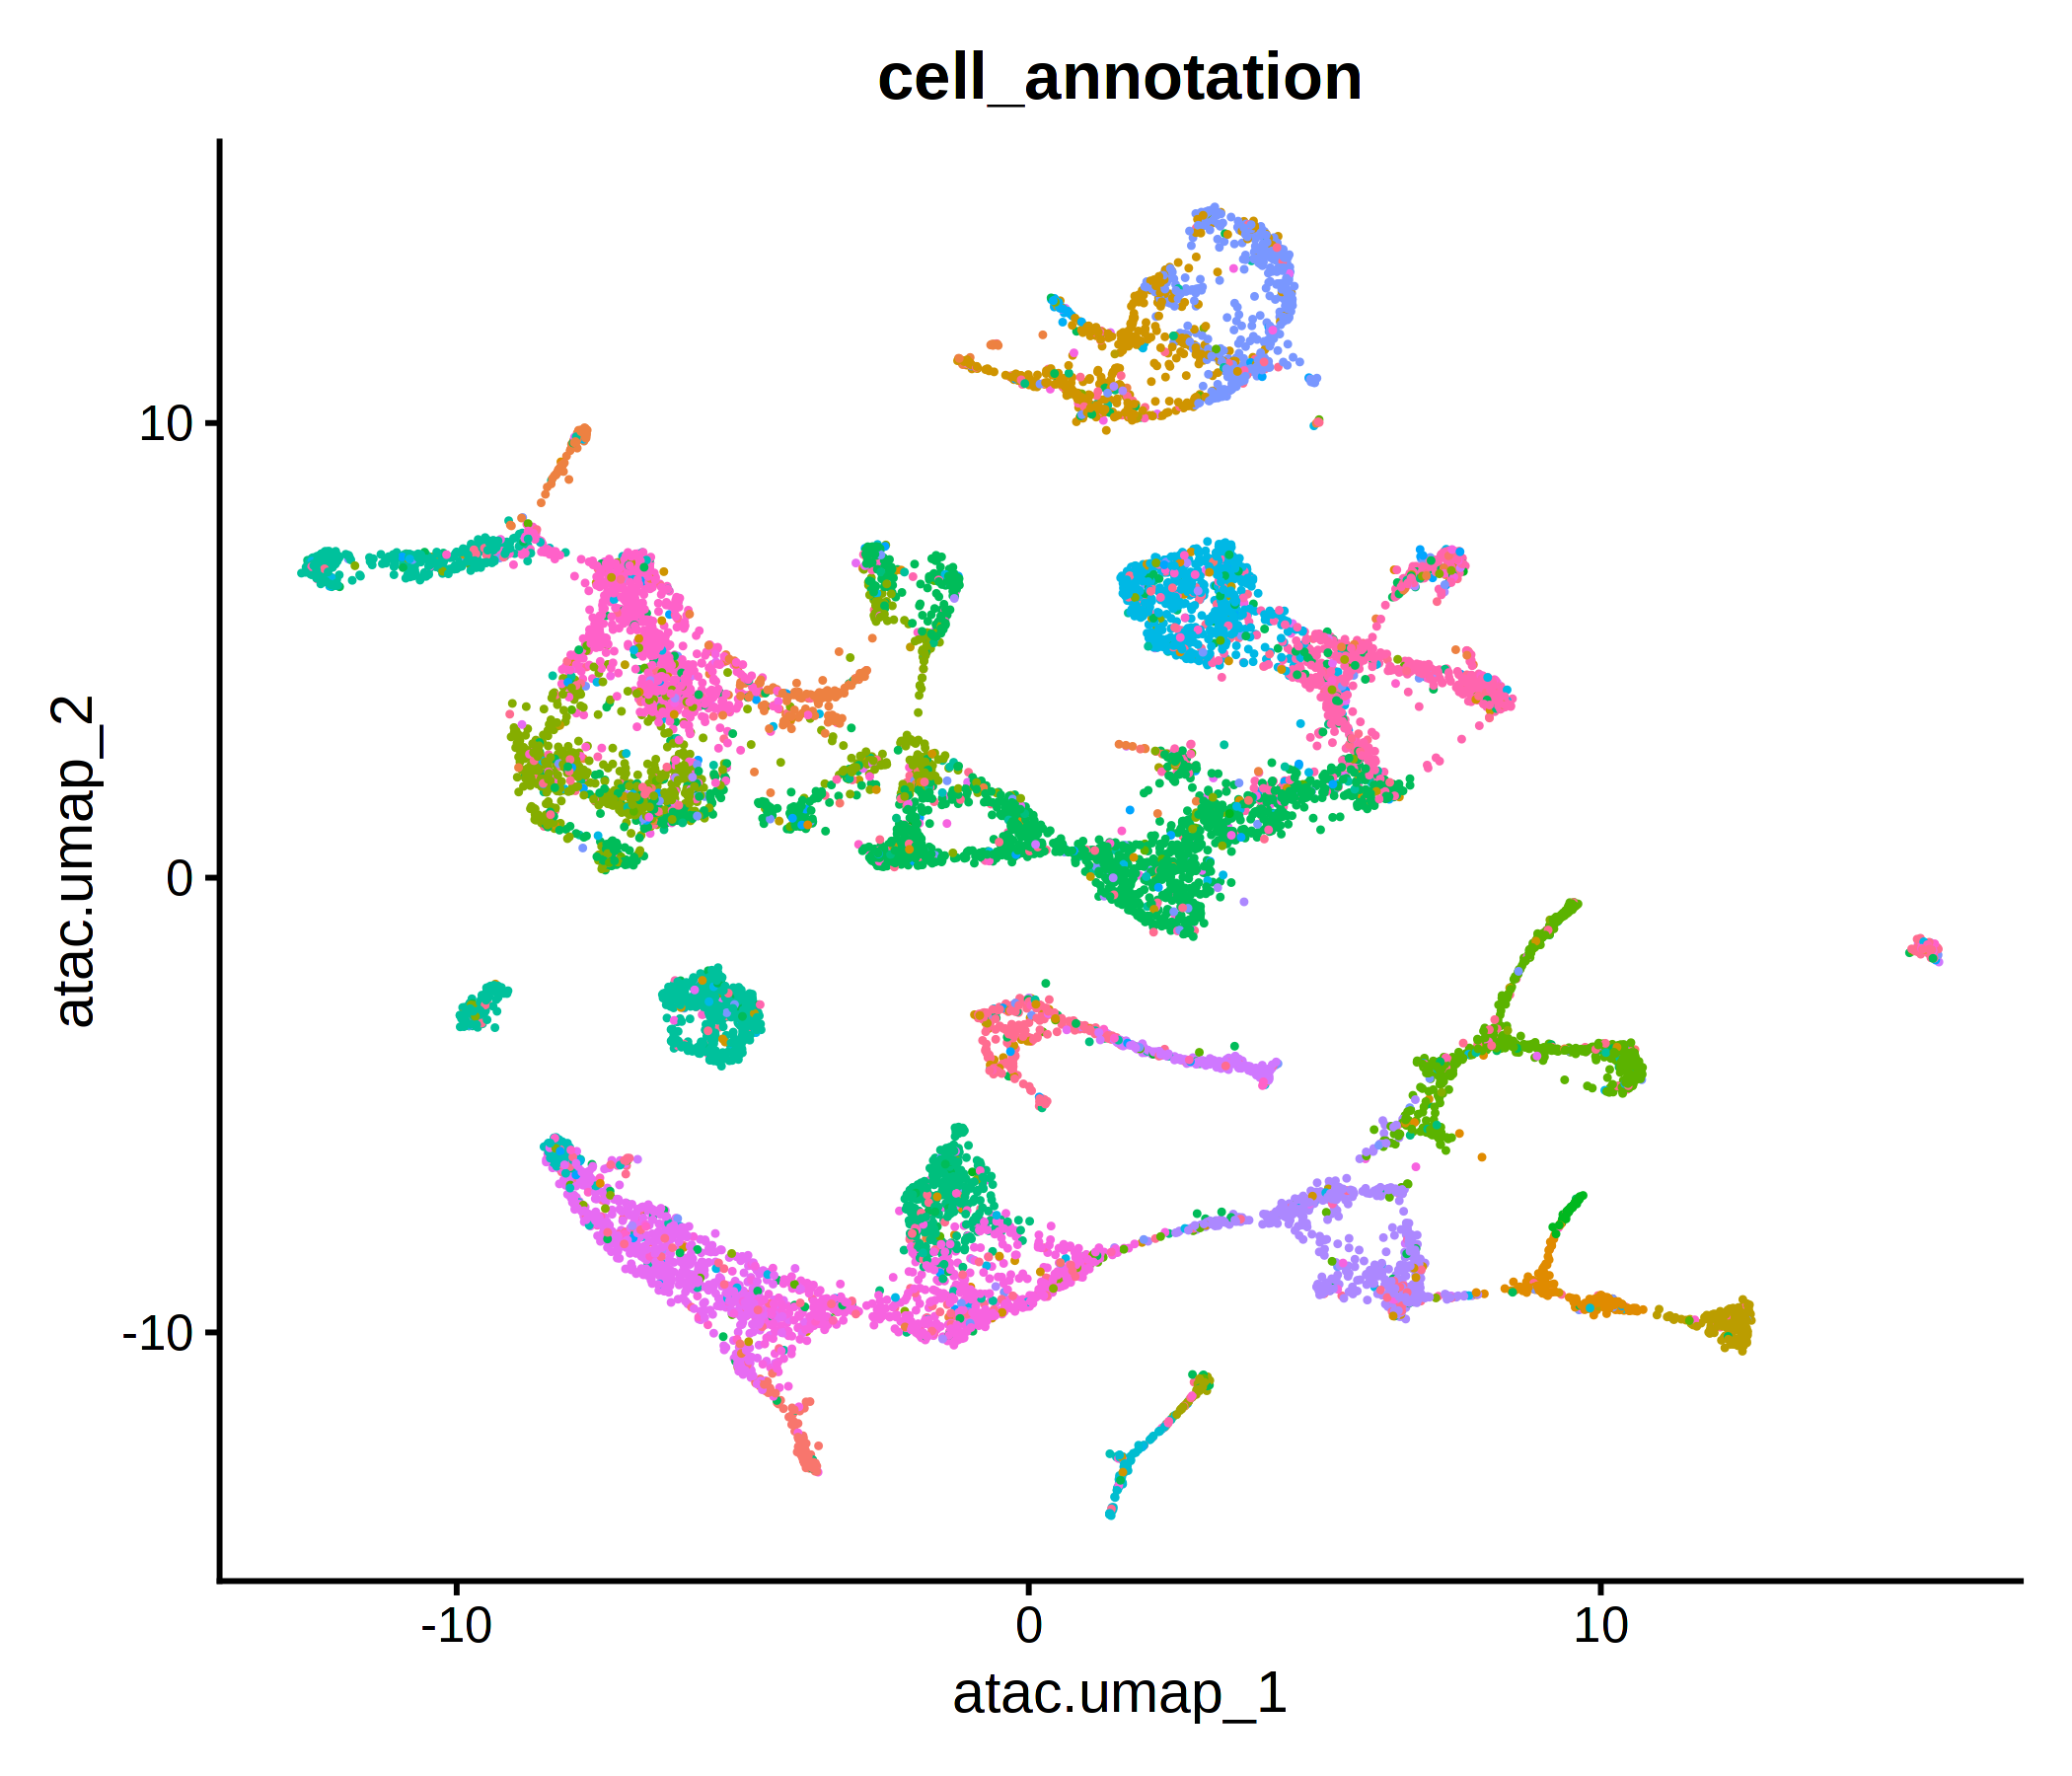

In [309]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 300)
DimPlot(TDR118, reduction = "atac.umap", group.by = "cell_annotation", label = FALSE) + NoLegend()

### Joint embedding (RNA + ATAC)

In [61]:
TDR118@graphs$wsnn

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCACCTAAGC-1’, ‘AAACAGCCAGGGAGGA-1’, ‘AAACAGCCATAGACCC-1’ ... ]]

   [[ suppressing 32 column names ‘AA

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

16:15:15 UMAP embedding parameters a = 0.9922 b = 1.112

16:15:18 Commencing smooth kNN distance calibration using 10 threads

16:15:24 Initializing from normalized Laplacian + noise

16:15:24 Commencing optimization for 200 epochs, with 399634 positive edges

16:15:32 Optimization finished



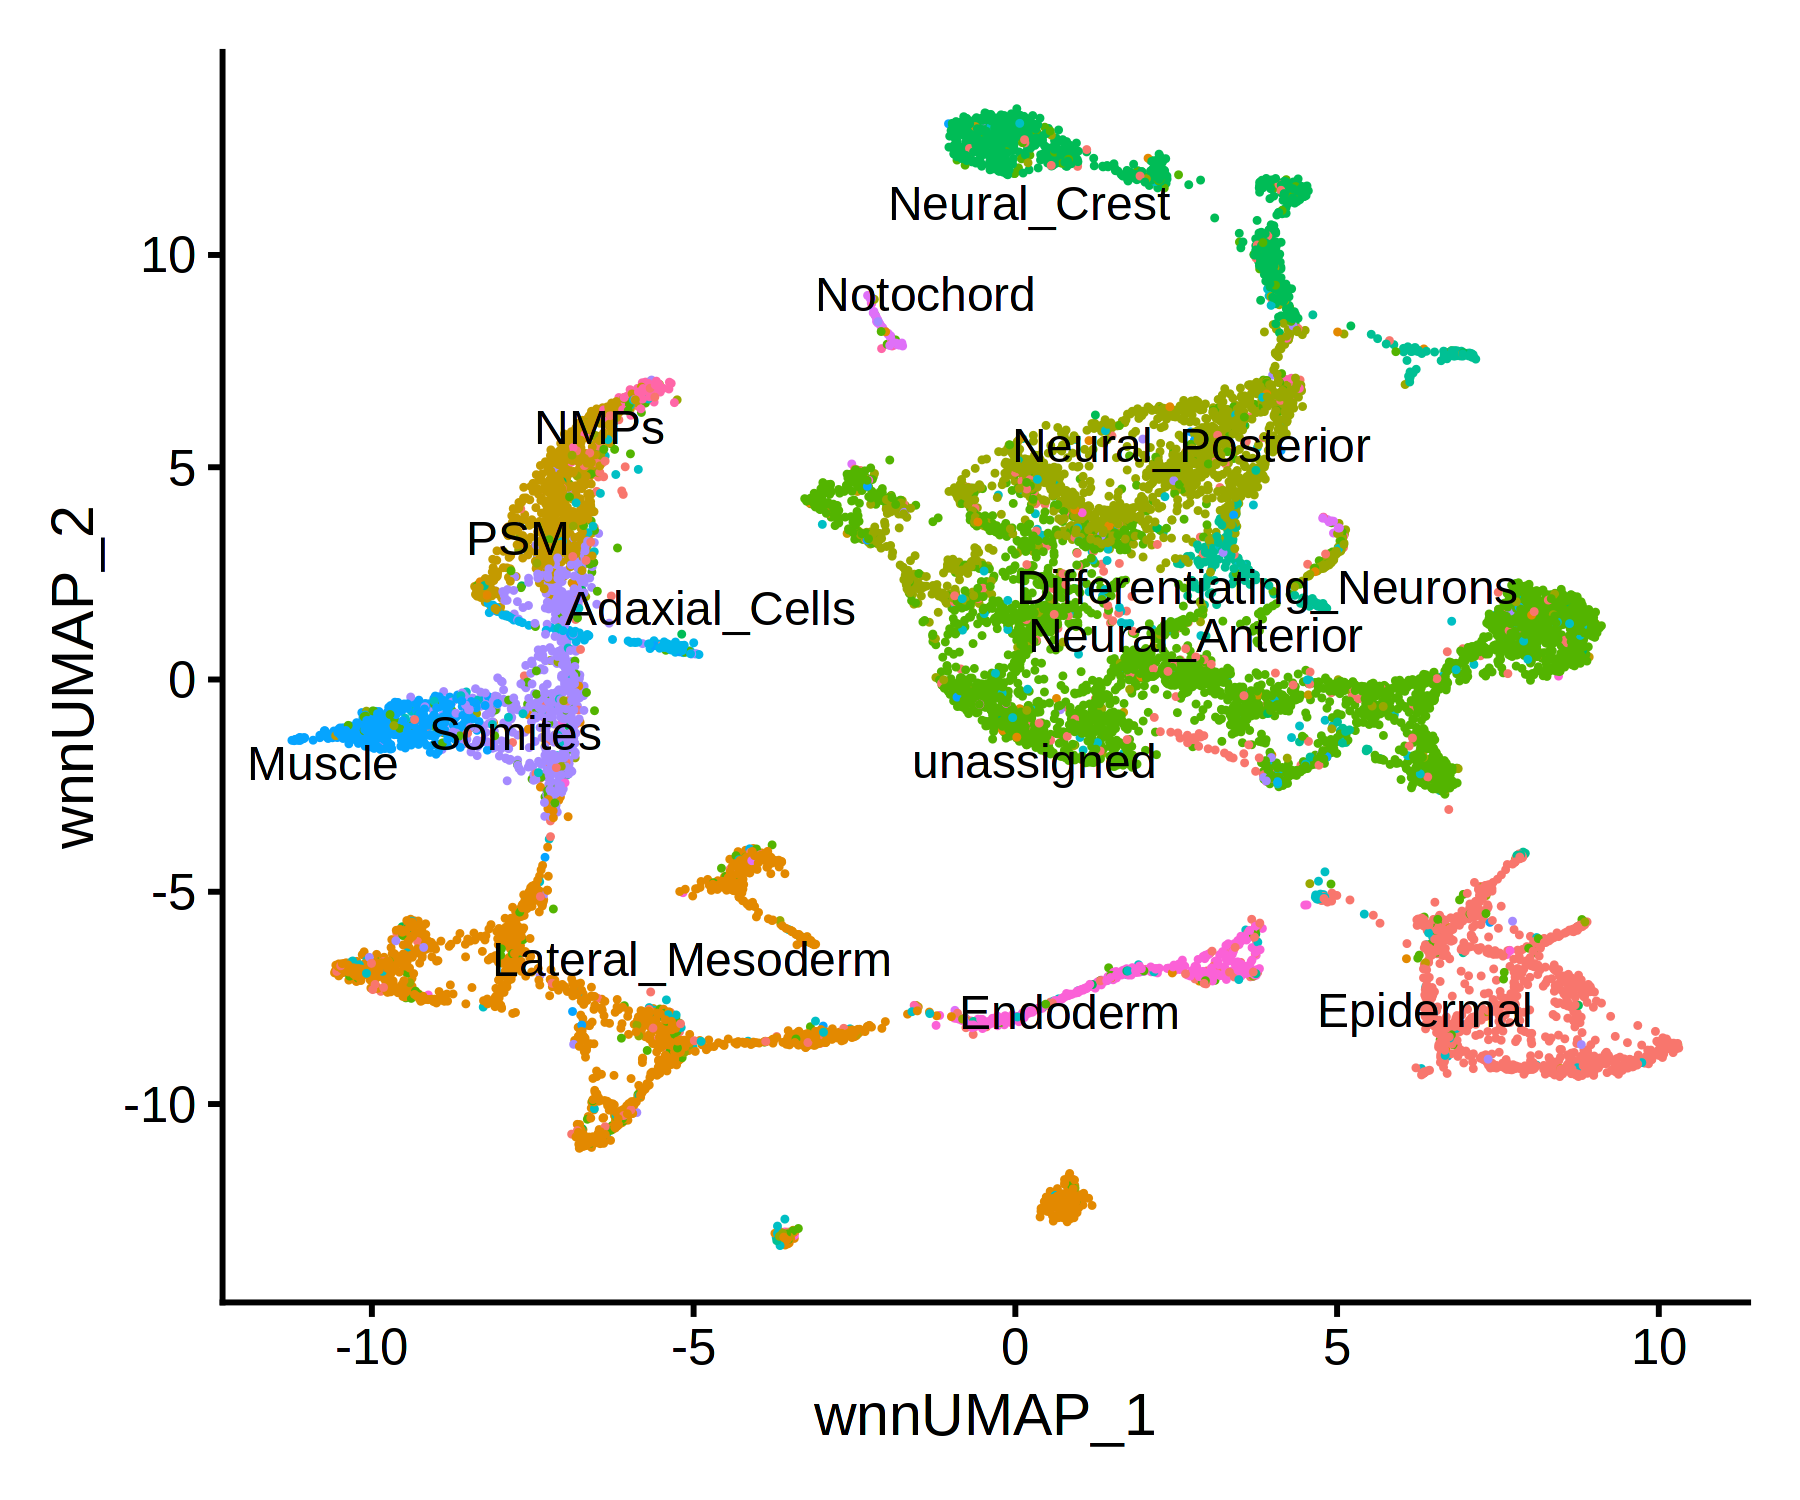

In [289]:
# Then, let's compute the weighted nearest neighbors and a joint embedding (UMAP)
TDR118 <- FindMultiModalNeighbors(TDR118,reduction.list = list("pca", "lsi"), dims.list = list(1:40, c(2:15,17,20:40)))
TDR118 <- RunUMAP(TDR118, nn.name = "weighted.nn", n.neighbors = 30, 
                reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
# TDR118 <- FindClusters(TDR118, graph.name = "wsnn", algorithm = 4, verbose = FALSE)

DimPlot(TDR118, label = TRUE, repel = TRUE, reduction = "wnn.umap") + NoLegend()

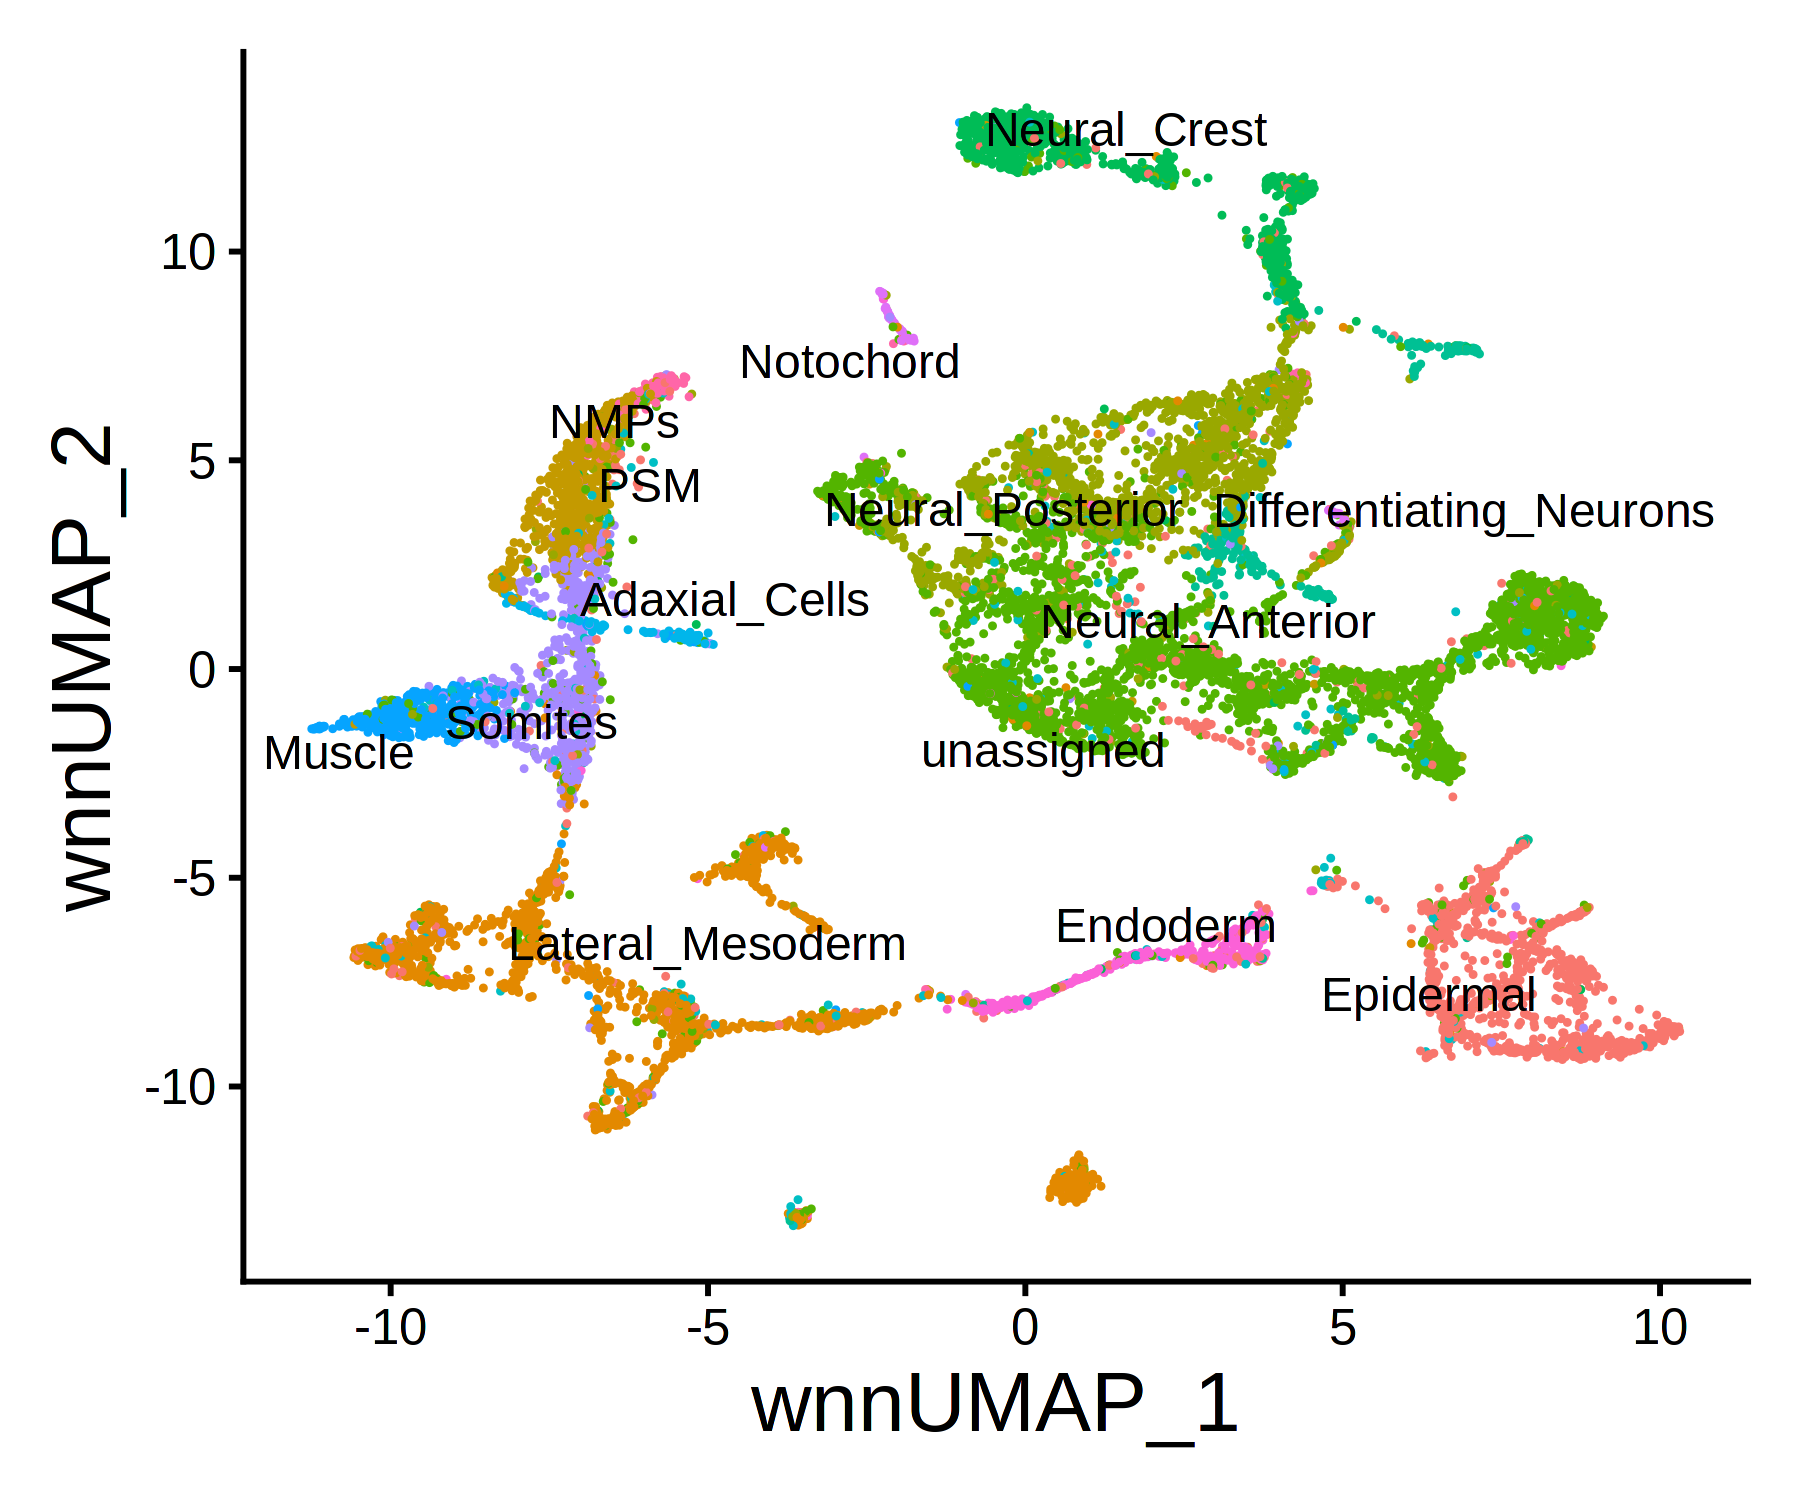

In [330]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(TDR118, label = TRUE, repel = TRUE, reduction = "wnn.umap") + NoLegend() +  theme(text = element_text(size = 20 ))

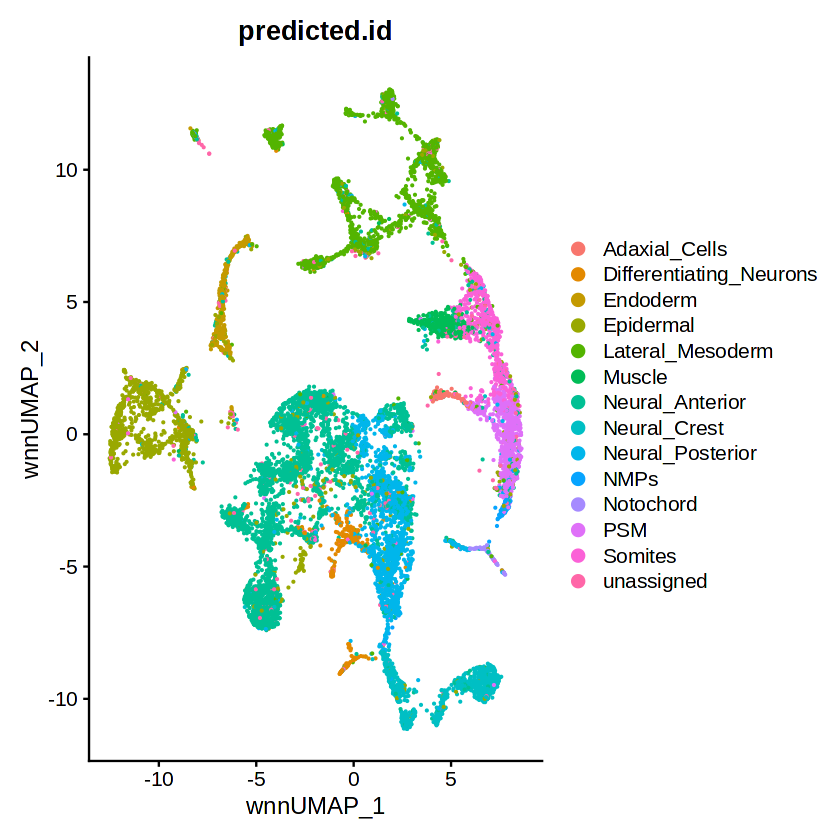

In [262]:
DimPlot(TDR118, reduction = "wnn.umap", group.by = "predicted.id")

In [303]:
# Generating a UMAP with Cellranger-arc peaks
DefaultAssay(TDR118) <- "ATAC"

# preprocess the data (dim.reduction for UMAP)
TDR118 <- FindTopFeatures(TDR118, assay = "ATAC", min.cutoff = 5)
TDR118 <- RunTFIDF(TDR118)
TDR118 <- RunSVD(TDR118, reduction.name = "lsi.cellranger")

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“Cannot add objects with duplicate keys (offending key: LSI_), setting key to 'lsi.cellranger_'”


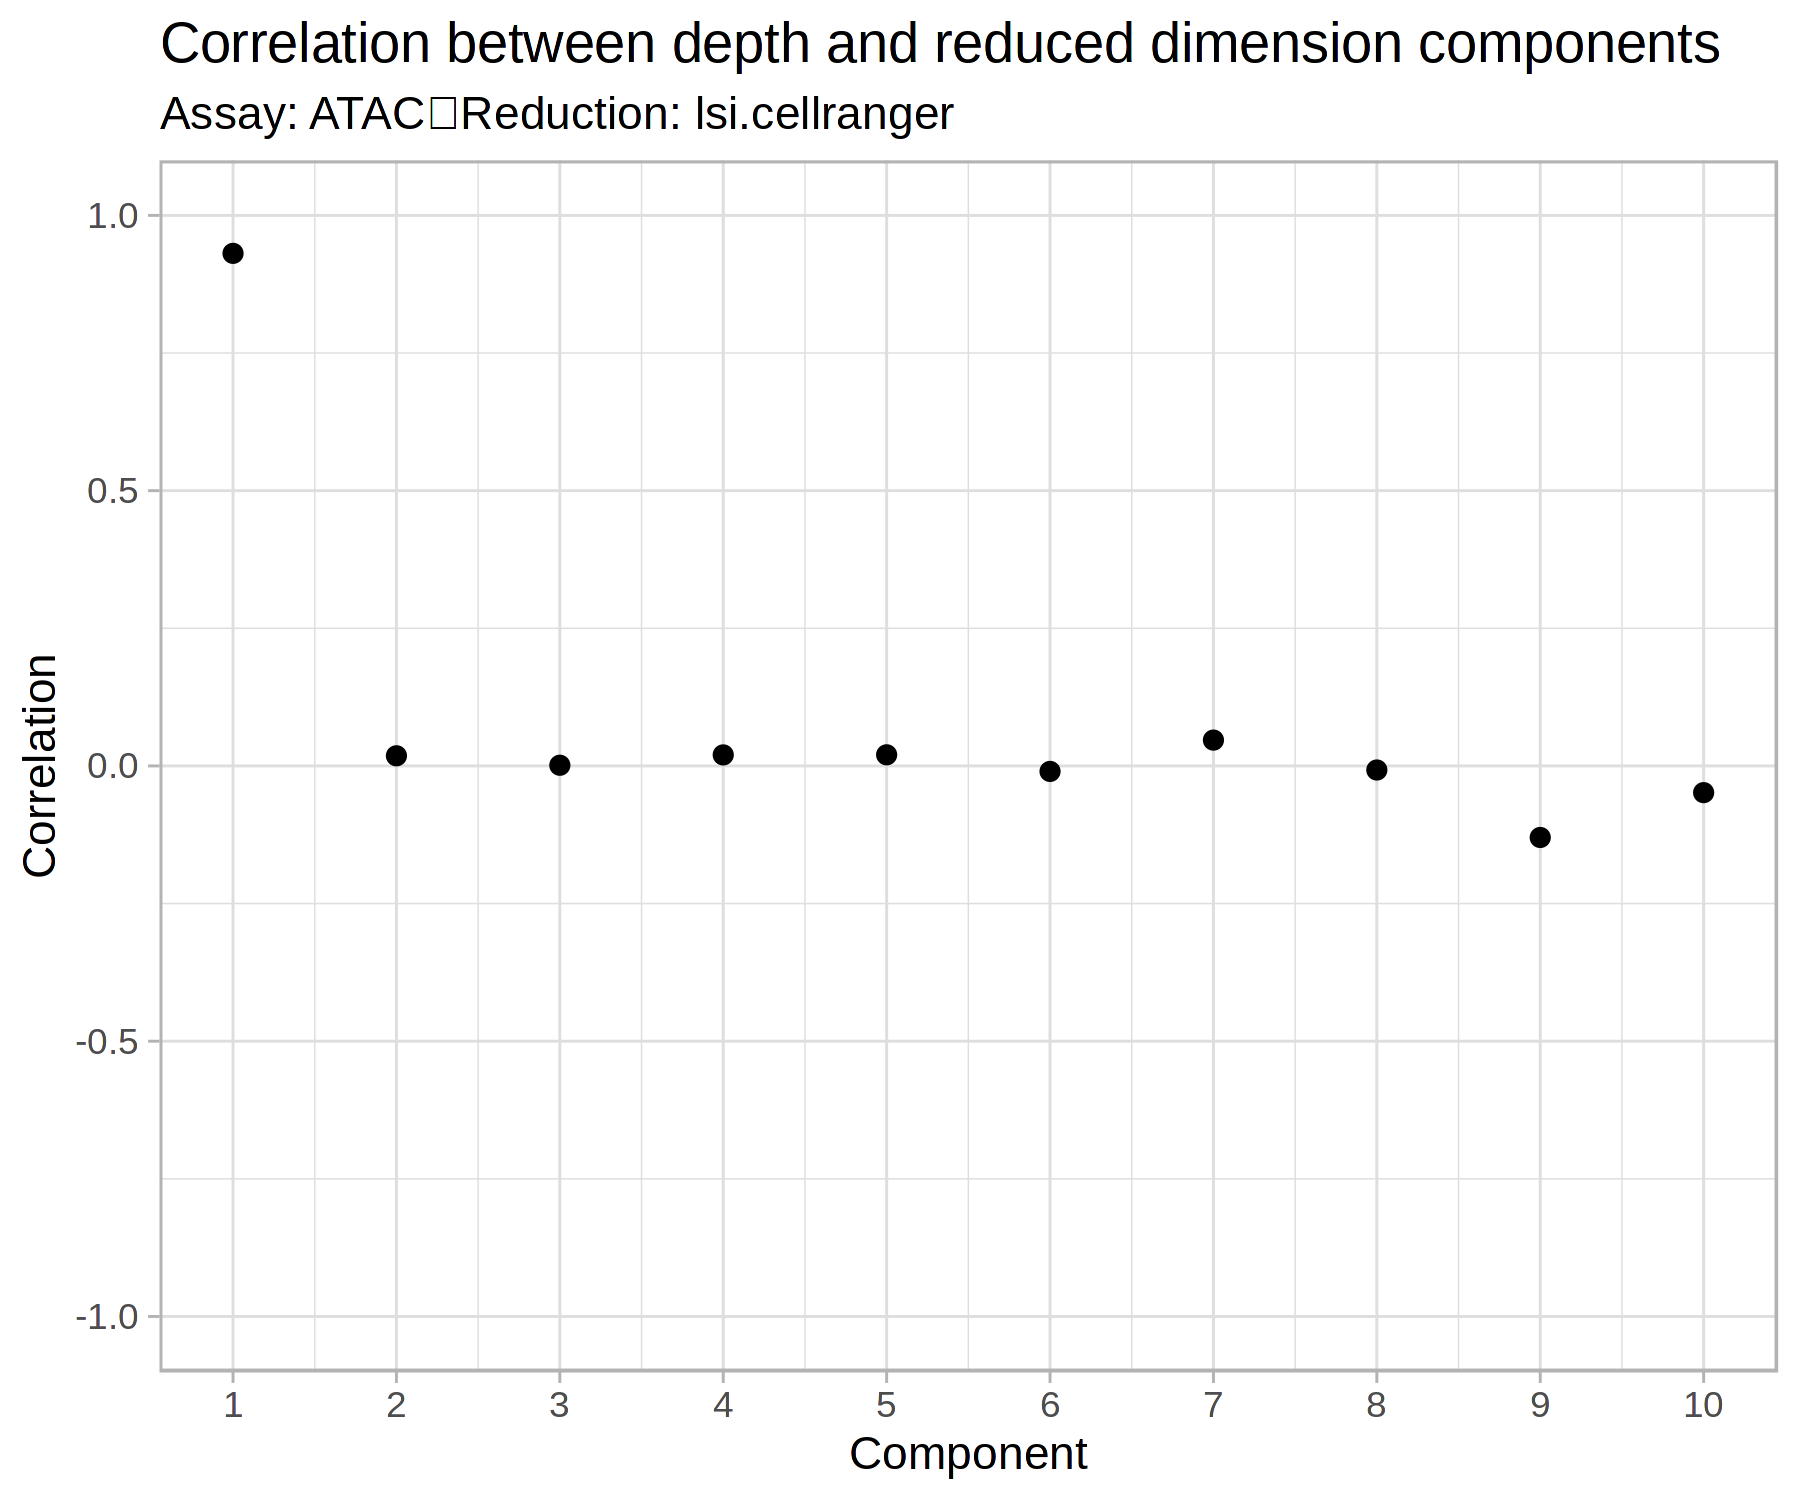

In [304]:
DepthCor(TDR118, reduction = "lsi.cellranger")

In [305]:
# UMAP
TDR118 <- RunUMAP(TDR118, reduction = 'lsi.cellranger', dims = c(2:40), assay = 'ATAC', 
              reduction.name = 'atac.umap.cellranger')



16:37:35 UMAP embedding parameters a = 0.9922 b = 1.112

16:37:35 Read 13022 rows and found 39 numeric columns

16:37:35 Using Annoy for neighbor search, n_neighbors = 30

16:37:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:37:37 Writing NN index file to temp file /tmp/RtmpcMsTjq/filef07e19703e8a

16:37:37 Searching Annoy index using 10 threads, search_k = 3000

16:37:37 Annoy recall = 100%

16:37:40 Commencing smooth kNN distance calibration using 10 threads

16:37:45 Initializing from normalized Laplacian + noise

16:37:46 Commencing optimization for 200 epochs, with 529736 positive edges

16:37:53 Optimization finished

Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'atac.umap.cellranger_'”


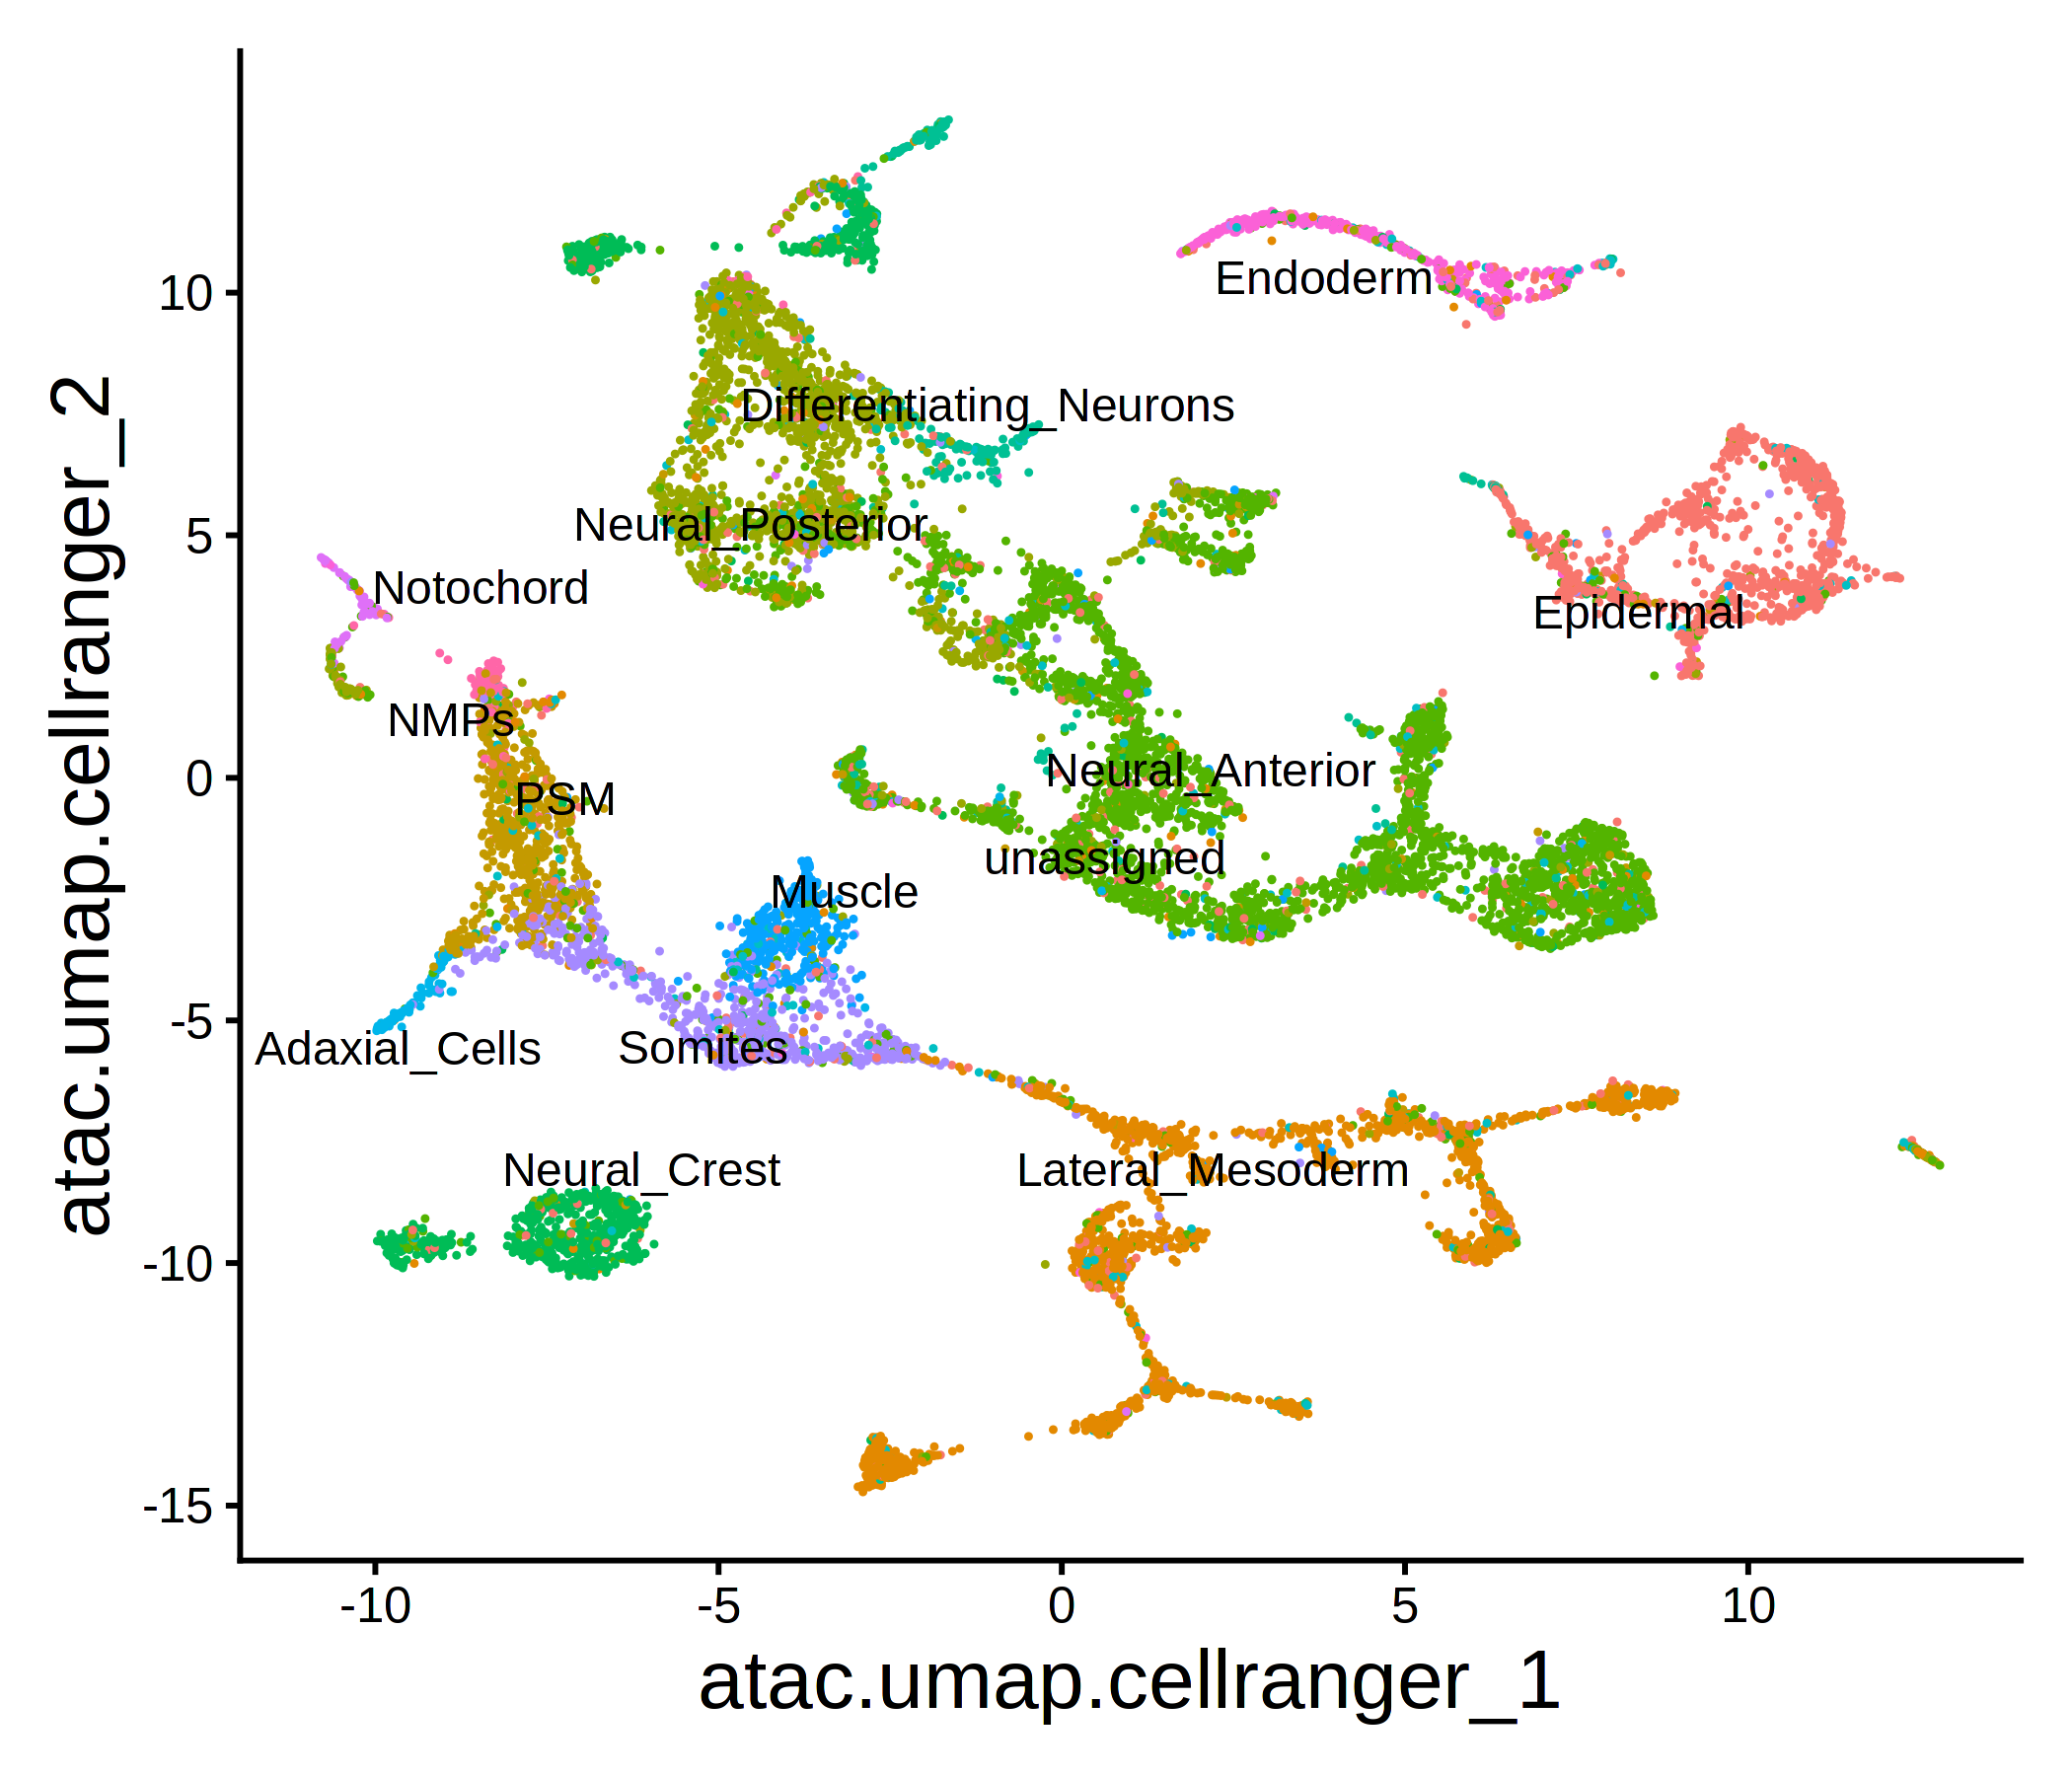

In [307]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 300)
DimPlot(TDR118, label = TRUE, repel = TRUE, reduction = "atac.umap.cellranger") + NoLegend() + theme(text = element_text(size = 20 ))

In [362]:
annotation[annotation$gene_name=="tbxta"]

GRanges object with 1 range and 20 metadata columns:
      seqnames            ranges strand |         source     type     score
         <Rle>         <IRanges>  <Rle> |       <factor> <factor> <numeric>
  [1]       19 14187540-14191592      - | ensembl_havana     gene        NA
          phase            gene_id gene_version   gene_name    gene_source
      <integer>        <character>  <character> <character>    <character>
  [1]      <NA> ENSDARG00000101576            2       tbxta ensembl_havana
        gene_biotype transcript_id transcript_version transcript_name
         <character>   <character>        <character>     <character>
  [1] protein_coding          <NA>               <NA>            <NA>
      transcript_source transcript_biotype exon_number     exon_id exon_version
            <character>        <character> <character> <character>  <character>
  [1]              <NA>               <NA>        <NA>        <NA>         <NA>
       protein_id protein_version         ta

### NOTE.
- For zebrafish GTF file (which was used for algining the first version of the zebrahub) does not have "transcript_id" column nor "tx_id" column. It has "gene_name", and for duplicates, it actually has different "gene_id" (ensemble ids). 

- github issue link:

- Signac requires the annotation object (GRanges object) to contain "tx_id" column for it to recognize the unique entry from the object. So, we will just copy the "gene_id" to "tx_id" and "transcript_id" columns.



In [438]:
annotation[annotation$gene_name=="phtf2"]

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source        type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor> <character> <numeric> <integer>
  [1]     chr4 31259-45642      + |  ensembl         gap        NA      <NA>
  [2]     chr4 38344-45396      + |  ensembl         gap        NA      <NA>
                 gene_id gene_version   gene_name gene_source   gene_biotype
             <character>  <character> <character> <character>    <character>
  [1] ENSDARG00000102123            4       phtf2     ensembl protein_coding
  [2] ENSDARG00000114503            1       phtf2     ensembl protein_coding
           transcript_id transcript_version transcript_name transcript_source
             <character>        <character>     <character>       <character>
  [1] ENSDARG00000102123               <NA>            <NA>              <NA>
  [2] ENSDARG00000114503               <NA>            <NA>              <NA>
      transcript_b

In [442]:
annotation <- TDR118@assays$ATAC@annotation

# copy the "gene_id" for the "tx_id" and "transcript_id" 
annotation$tx_id <- annotation$gene_id
annotation$transcript_id <- annotation$gene_id

# Add the annotation back to the main object
Annotation(TDR118) <- annotation
TDR118@assays$ATAC@annotation

GRanges object with 1152211 ranges and 20 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

In [445]:
TDR118@assays$ATAC@annotation<- annotation

In [446]:
TDR118@assays$ATAC@annotation

GRanges object with 1152211 ranges and 21 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]        4 17308-18211      - |  ensembl gene              NA
        [2]        4 17308-18211      - |  ensembl transcript        NA
        [3]        4 18134-18211      - |  ensembl exon              NA
        [4]        4 18134-18211      - |  ensembl CDS               NA
        [5]        4 17948-18046      - |  ensembl exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1152207]       MT 16449-16520      + |   RefSeq transcript        NA
  [1152208]       MT 16449-16520      + |   RefSeq exon              NA
  [1152209]       MT 16527-16596      - |   RefSeq gene              NA
  [1152210]       MT 16527-16596      - |   RefSeq transcript        NA
  [1152211]       MT 16527-16596      - |   RefSeq exon              NA
    

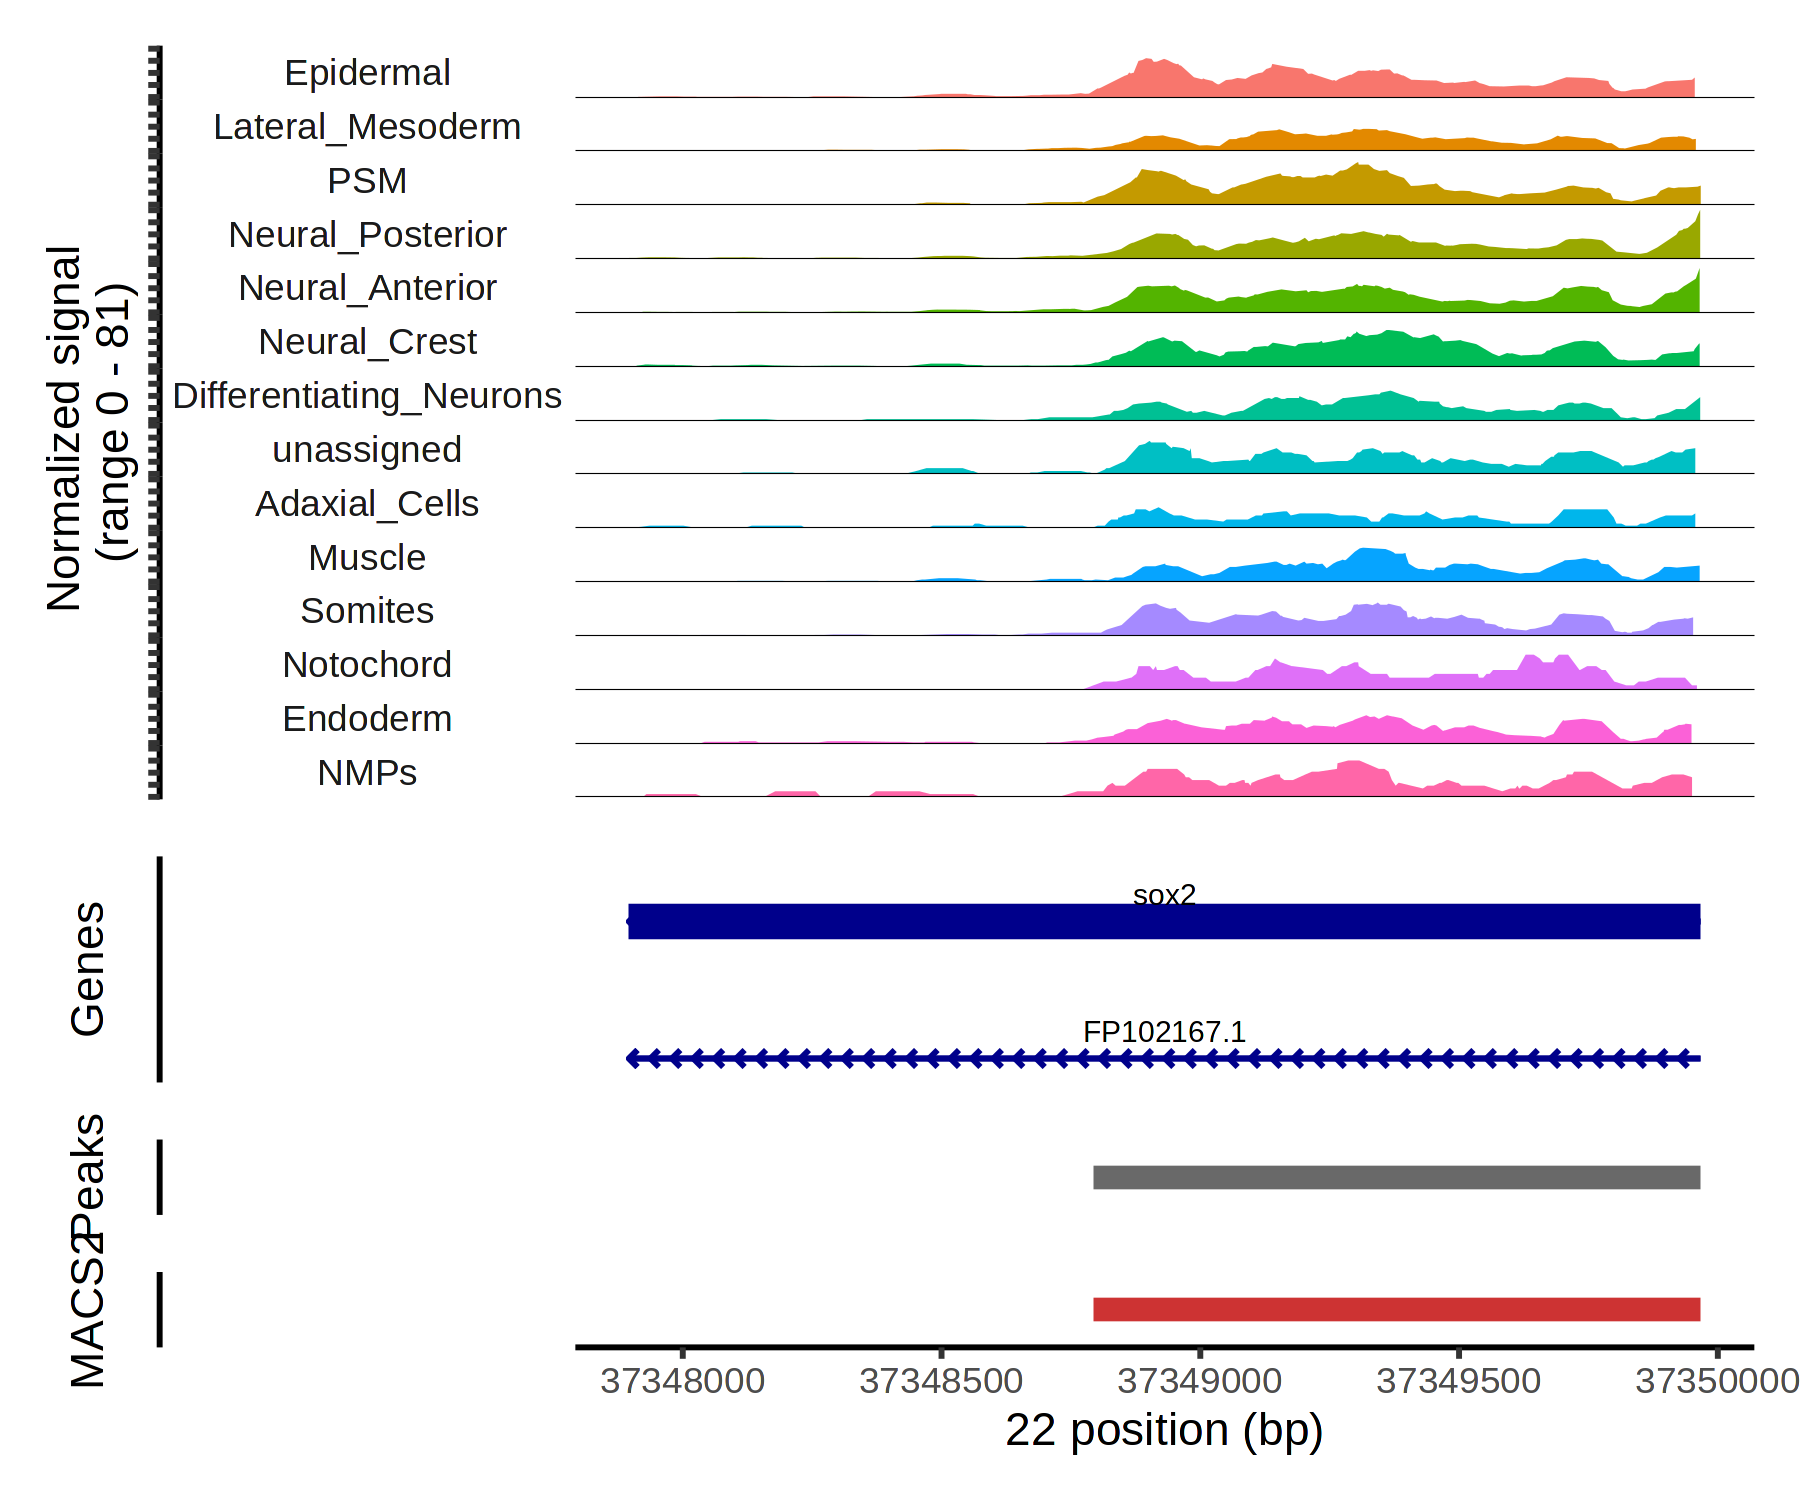

In [448]:
# Compare the called peaks using a Coverage Plot
CoveragePlot(
  object = TDR118,
  region = "sox2",
  ranges = peaks,
  ranges.title = "MACS2"
)

GRanges object with 316881 ranges and 1 metadata column:
           seqnames            ranges strand |         peak_called_in
              <Rle>         <IRanges>  <Rle> |            <character>
       [1]        1         3543-3972      * | Differentiating_Neur..
       [2]        1         4473-6134      * | Lateral_Mesoderm,PSM..
       [3]        1       11016-12944      * | Epidermal,unassigned..
       [4]        1       13368-13579      * |                 Muscle
       [5]        1       14639-15056      * | Neural_Crest,NMPs,Ne..
       ...      ...               ...    ... .                    ...
  [316877]       25 37498216-37498932      * | Neural_Anterior,Musc..
  [316878]       25 37499167-37500024      * | Neural_Anterior,Neur..
  [316879]       25 37501445-37501804      * | Lateral_Mesoderm,End..
  [316880]       MT           28-3549      * | PSM,Neural_Anterior,..
  [316881]       MT       13335-16517      * | Neural_Posterior,Som..
  -------
  seqinfo: 26 sequences

In [540]:
DefaultAssay(TDR118)<-"ATAC"

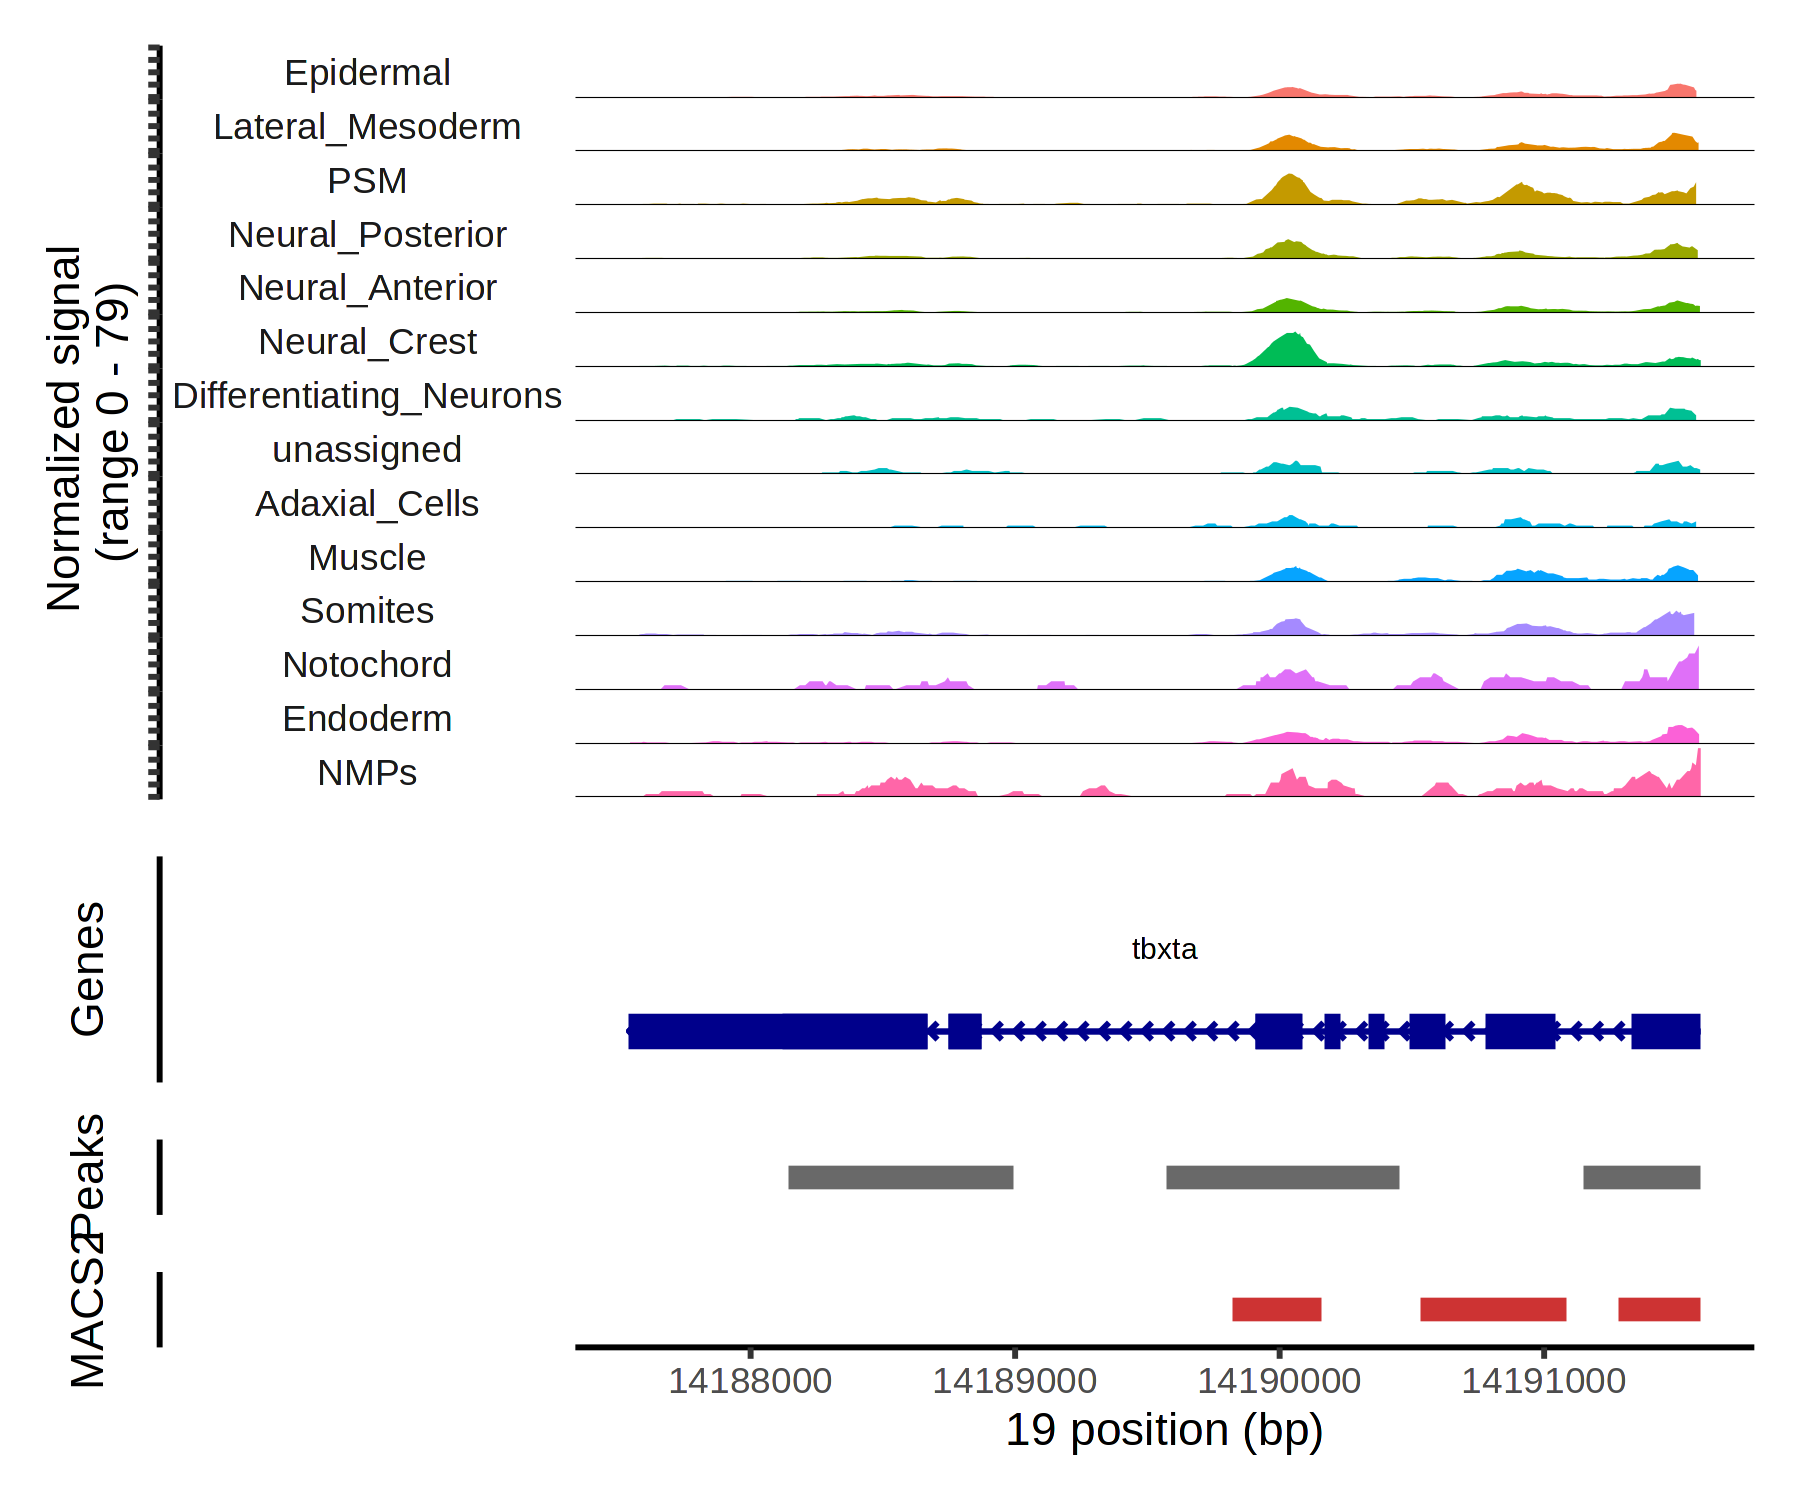

In [542]:
# Compare the called peaks using a Coverage Plot
CoveragePlot(
  object = TDR118,
  region = "tbxta",
  ranges = peaks,
  ranges.title = "MACS2"
)

In [543]:
pdf(file = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/TDR118_tbxta_coverage_peaks_bulk.pdf")
# Compare the called peaks using a Coverage Plot
# change the group.by to "bulk"
Idents(TDR118)<-"orig.ident"

CoveragePlot(
  object = TDR118,
  region = "tbxta",
  ranges = peaks_bulk,
  ranges.title = "MACS2"
)

# change the group.by to "predicted.id" (cell-type) again
Idents(TDR118)<-"predicted.id"

# Step 3: Run dev.off() to create the file!
dev.off()

png 
  2

In [537]:
TDR118@meta.data

orig.ident    nCount_RNA nFeature_RNA nCount_ATAC
AAACAGCCACCTAAGC-1 SeuratProject 2731       1273         21425      
AAACAGCCAGGGAGGA-1 SeuratProject 2520       1179         10334      
AAACAGCCATAGACCC-1 SeuratProject 5281       1922         51485      
AAACATGCAAACTCAT-1 SeuratProject 2217       1073         19812      
AAACATGCAAGGACCA-1 SeuratProject 1060        411          5182      
AAACATGCAAGGATTA-1 SeuratProject 1771        902         24072      
AAACATGCACGTTACA-1 SeuratProject 1718        957         25566      
AAACATGCAGGACCTT-1 SeuratProject 5604       1682          8685      
AAACATGCAGGCGATA-1 SeuratProject 2106        404         15465      
AAACATGCAGTTTCTC-1 SeuratProject 1652        750         25357      
AAACATGCATAGGCGA-1 SeuratProject 1214        587         31242      
AAACCAACAGAGGGAG-1 SeuratProject 1983        967         37611      
AAACCAACAGATTCAT-1 SeuratProject 2052       1064          5141      
AAACCAACAGCAGGTA-1 SeuratProject 1345        728         21560      
AAACCAACATCACTTC-1 SeuratProject 2516       1376         32024      
AAACCAACATGTCAAT-1 SeuratProject 2557        971         10099      
AAACCGAAGATAAAGC-1 SeuratProject 2137       1079          8988      
AAACCGAAGCACGATT-1 SeuratProject 4914       1897         36307      
AAACCGAAGCACTAAC-1 SeuratProject 1649        707          8576      
AAACCGAAGCCTGAGC-1 SeuratProject 2376       1184         77966      
AAACCGAAGGGTGAGT-1 SeuratProject 3170       1297         25490      
AAACCGAAGTAAACCC-1 SeuratProject 1578        671         37780      
AAACCGAAGTCATCCC-1 SeuratProject 2008       1203          4906      
AAACCGCGTCAAGTAT-1 SeuratProject 1248        586         25905      
AAACCGCGTCTTTATG-1 SeuratProject 3746       1675          2969      
AAACCGCGTTAGACCA-1 SeuratProject 1786        728         29534      
AAACCGCGTTATCCGT-1 SeuratProject 2461       1119         24004      
AAACCGCGTTCAAGAT-1 SeuratProject 2635       1121         35498      
AAACCGGCAAAGCGGC-1 SeuratProject 2502       1161         47565      
AAACCGGCAAAGGTAC-1 SeuratProject 1549        680         22059      
⋮                  ⋮             ⋮          ⋮            ⋮          
TTTGTCTAGGTCCTAG-1 SeuratProject 5570       1953          8478      
TTTGTCTAGGTCGATT-1 SeuratProject 1150        571          8001      
TTTGTCTAGTTCCTCA-1 SeuratProject 1055        581         28166      
TTTGTGAAGAACAAGT-1 SeuratProject 2666       1163         13696      
TTTGTGAAGCTGTCAG-1 SeuratProject 4702       1644         11054      
TTTGTGAAGGCATTAC-1 SeuratProject 3008       1237         44166      
TTTGTGAAGGGTTAGA-1 SeuratProject 5462       1877         19766      
TTTGTGAAGTCAGGCC-1 SeuratProject 4467       1583         12290      
TTTGTGGCACAAAGCG-1 SeuratProject 2091       1053         35191      
TTTGTGGCACAACCTA-1 SeuratProject 2829       1175         23044      
TTTGTGGCACGTTACA-1 SeuratProject 1956       1131         45592      
TTTGTGGCAGCTTAGC-1 SeuratProject 1546        559         18969      
TTTGTGGCAGGCATCT-1 SeuratProject 1269        576          4952      
TTTGTGGCATGTCAAT-1 SeuratProject 2877       1164         29668      
TTTGTGGCATTAGGCC-1 SeuratProject 7272       2612         66386      
TTTGTGGCATTGCAGC-1 SeuratProject 3205       1423         26096      
TTTGTGTTCACGCATG-1 SeuratProject 2041        816         16996      
TTTGTGTTCCCTCATA-1 SeuratProject 1239        571         28338      
TTTGTGTTCCGCAAGC-1 SeuratProject 1574        789         13465      
TTTGTGTTCGAGGAAC-1 SeuratProject 1602        753         28186      
TTTGTGTTCGAGGTGG-1 SeuratProject 1233        616         52259      
TTTGTGTTCGCTAAGT-1 SeuratProject 3968       1616         10517      
TTTGTTGGTAAAGCAA-1 SeuratProject 1285        713          2986      
TTTGTTGGTAATAACC-1 SeuratProject 1994        956          4587      
TTTGTTGGTAGGTGTC-1 SeuratProject 2019       1023         41629      
TTTGTTGGTCGACTCC-1 SeuratProject 1610        898          2076      
TTTGTTGGTGATTTGG-

In [538]:
# Peak calling for bulk using MACS2 (to see if we can actually capture the four peaks visually shown above for tbxta)
peaks_bulk <- CallPeaks(object = TDR118, group.by = NULL)
peaks_bulk

GRanges object with 435704 ranges and 6 metadata columns:
           seqnames            ranges strand |                   name     score
              <Rle>         <IRanges>  <Rle> |            <character> <integer>
       [1]        1         3596-4069      * |   SeuratProject_peak_1        73
       [2]        1         4478-6981      * |   SeuratProject_peak_2        76
       [3]        1       11049-12897      * |   SeuratProject_peak_3        82
       [4]        1       14695-15041      * |   SeuratProject_peak_4       100
       [5]        1       18522-19033      * |   SeuratProject_peak_5       107
       ...      ...               ...    ... .                    ...       ...
  [435700]        9 56455828-56456125      * | SeuratProject_peak_4..        62
  [435701]        9 56457205-56457539      * | SeuratProject_peak_4..        39
  [435702]        9 56459130-56459697      * | SeuratProject_peak_4..       266
  [435703]       MT           29-3505      * | SeuratProject_p

In [546]:
# Choose a set of peaks from the above Coverage Plot, then create a new object to replace the original ATAC object
# peaks <- peaks

# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks_bulk <- keepStandardChromosomes(peaks_bulk, pruning.mode = "coarse")
# peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_hg38_unified, invert = TRUE)

# quantify counts in each peak
macs2_counts <- FeatureMatrix(
  fragments = Fragments(TDR118),
  features = peaks_bulk,
  cells = colnames(TDR118)
)

# create a new assay using the MACS2 peak set and add it to the Seurat object
TDR118[["peaks_bulk"]] <- CreateChromatinAssay(
  counts = macs2_counts,
  fragments = fragpath,
  annotation = annotation
)

Extracting reads overlapping genomic regions

Computing hash



In [63]:
print(TDR118@reductions)

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 50 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: SCT 

$umap
A dimensional reduction object with key umappca30_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: SCT 

$lsi
A dimensional reduction object with key LSI_ 
 Number of dimensions: 50 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_celltype 

$atac.umap
A dimensional reduction object with key atac.umap_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_celltype 

$wnn.umap
A dimensional reduction object with key wnnUMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks_celltype 

$umap.pca30
A dimensional re

In [534]:
pdf(file = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/TDR118_tbxta_coverage_peaks.pdf")

# Compare the called peaks using a Coverage Plot
CoveragePlot(
  object = TDR118,
  region = "tbxta",
  ranges = peaks,
  ranges.title = "MACS2"
)

# Step 3: Run dev.off() to create the file!
dev.off()

png 
  2

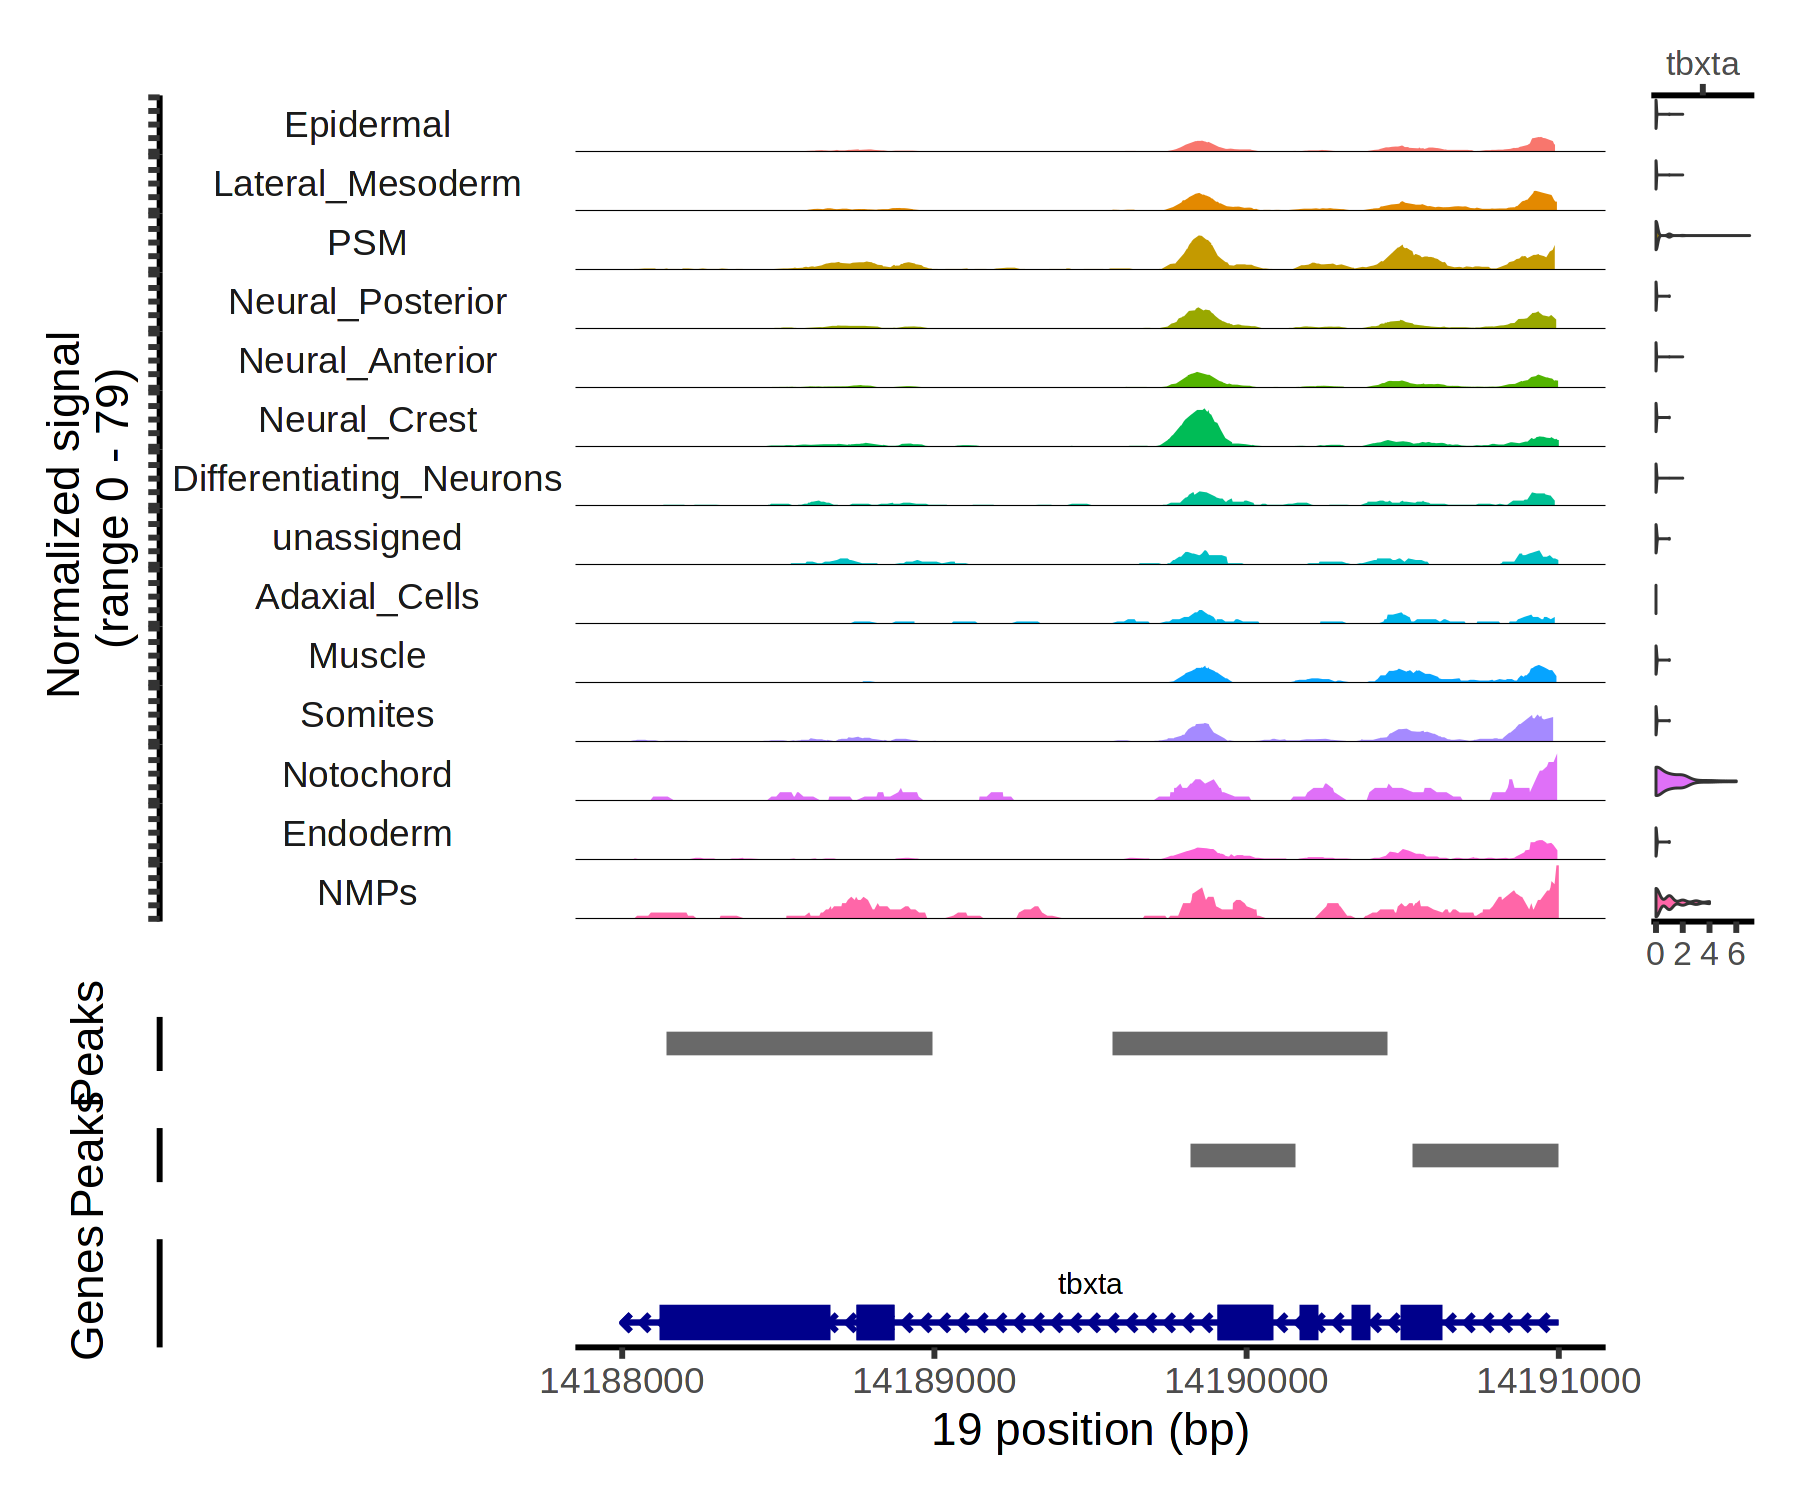

In [528]:
# Compare the called peaks using a Coverage Plot
cov_plot <- CoveragePlot(
  object = TDR118,
  region = "tbxta",
  annotation=FALSE,
  peaks=FALSE
  #ranges = peaks,
  #ranges.title = "MACS2"
)

# gene annotation
gene_plot <- AnnotationPlot(
  object = TDR118,
  region = "19-14188000-14191000"
)
# gene_plot


# cellranger-arc peak
peak_plot1 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$ATAC@ranges
)
# peak_plot

# cell-type-specific peak
peak_plot2 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$peaks_celltype@ranges
)

# expression of RNA
expr_plot <- ExpressionPlot(
  object = TDR118,
  features = "tbxta",
  assay = "RNA"
)


CombineTracks(
  plotlist = list(cov_plot, peak_plot1, peak_plot2, gene_plot),
  expression.plot = expr_plot,
  heights = c(10,1,1,2),
  widths = c(10, 1)
)

In [ ]:
# Compare the called peaks using a Coverage Plot
cov_plot <- CoveragePlot(
  object = TDR118,
  region = "tbxta",
  annotation=FALSE,
  peaks=FALSE
  #ranges = peaks,
  #ranges.title = "MACS2"
)

# gene annotation
gene_plot <- AnnotationPlot(
  object = TDR118,
  region = "19-14188000-14191000"
)
# gene_plot


# cellranger-arc peak
peak_plot1 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$ATAC@ranges
)
# peak_plot

# cell-type-specific peak
peak_plot2 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$peaks_celltype@ranges
)

# expression of RNA
expr_plot <- ExpressionPlot(
  object = TDR118,
  features = "tbxta",
  assay = "RNA"
)


CombineTracks(
  plotlist = list(cov_plot, peak_plot1, peak_plot2, gene_plot),
  expression.plot = expr_plot,
  heights = c(10,1,1,2),
  widths = c(10, 1)
)

In [530]:
pdf(file = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/TDR118_tbxta_coverage.pdf")

tbxta_plot <- CombineTracks(
  plotlist = list(cov_plot, peak_plot1, peak_plot2, gene_plot),
  expression.plot = expr_plot,
  heights = c(10,1,1,2),
  widths = c(10, 1)
)

tbxta_plot


# Step 3: Run dev.off() to create the file!
dev.off()

png 
  2

In [454]:
Idents(TDR118) <- "predicted.id"

In [455]:
table(TDR118@meta.data$predicted.id)


          Adaxial_Cells Differentiating_Neurons                Endoderm 
                    128                     299                     448 
              Epidermal        Lateral_Mesoderm                  Muscle 
                   1447                    1864                     419 
        Neural_Anterior            Neural_Crest        Neural_Posterior 
                   3786                    1004                    1750 
                   NMPs               Notochord                     PSM 
                    103                      76                     730 
                Somites              unassigned 
                    662                     306 

In [469]:
# Check for all marker genes from 15 somite stage (marker genes from Merlin Lange)
list_genes = c("lrrc17", "comp", "ripply1", # somite
               "crestin", "ednrab", "dlx2a", # neural crest
               "olig3", "hoxd4a","rxrga", # spinal cord neural tube
               "nid1b",  #head mesenchyme "prrx1"
               "cpox","gata1a", #hematopoietic system "hbbe1"
               "tbx3b","loxl5b",'emilin3a') #notochord
list_genes

[1] "lrrc17"   "comp"     "ripply1"  "crestin"  "ednrab"   "dlx2a"   
 [7] "olig3"    "hoxd4a"   "rxrga"    "nid1b"    "cpox"     "gata1a"  
[13] "tbx3b"    "loxl5b"   "emilin3a"

In [460]:
table(TDR118$predicted.id)


          Adaxial_Cells Differentiating_Neurons                Endoderm 
                    128                     299                     448 
              Epidermal        Lateral_Mesoderm                  Muscle 
                   1447                    1864                     419 
        Neural_Anterior            Neural_Crest        Neural_Posterior 
                   3786                    1004                    1750 
                   NMPs               Notochord                     PSM 
                    103                      76                     730 
                Somites              unassigned 
                    662                     306 

In [461]:
# marker_genes <- read_excel("/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/notebooks/multiome_zebrahub_analysis/marker_genes_15s.xlsx")
# marker_genes

# # chatgpt
# # Read the CSV file into a data frame
# data <- read.csv("your_file.csv")

# # Create an empty list to store the marker genes for each cell type
# marker_genes <- list()

# # Loop through unique cell types and collect marker genes
# unique_cell_types <- unique(data$cell_type)
# for (cell_type in unique_cell_types) {
#   # Subset the data for the current cell type
#   subset_data <- data[data$cell_type == cell_type, ]
  
#   # Extract the marker genes for the current cell type
#   current_marker_genes <- subset_data$marker_genes
  
#   # Assign the marker genes to the corresponding cell type in the list
#   marker_genes[[cell_type]] <- current_marker_genes
# }

# # Print the dictionary-like structure
# print(marker_genes)

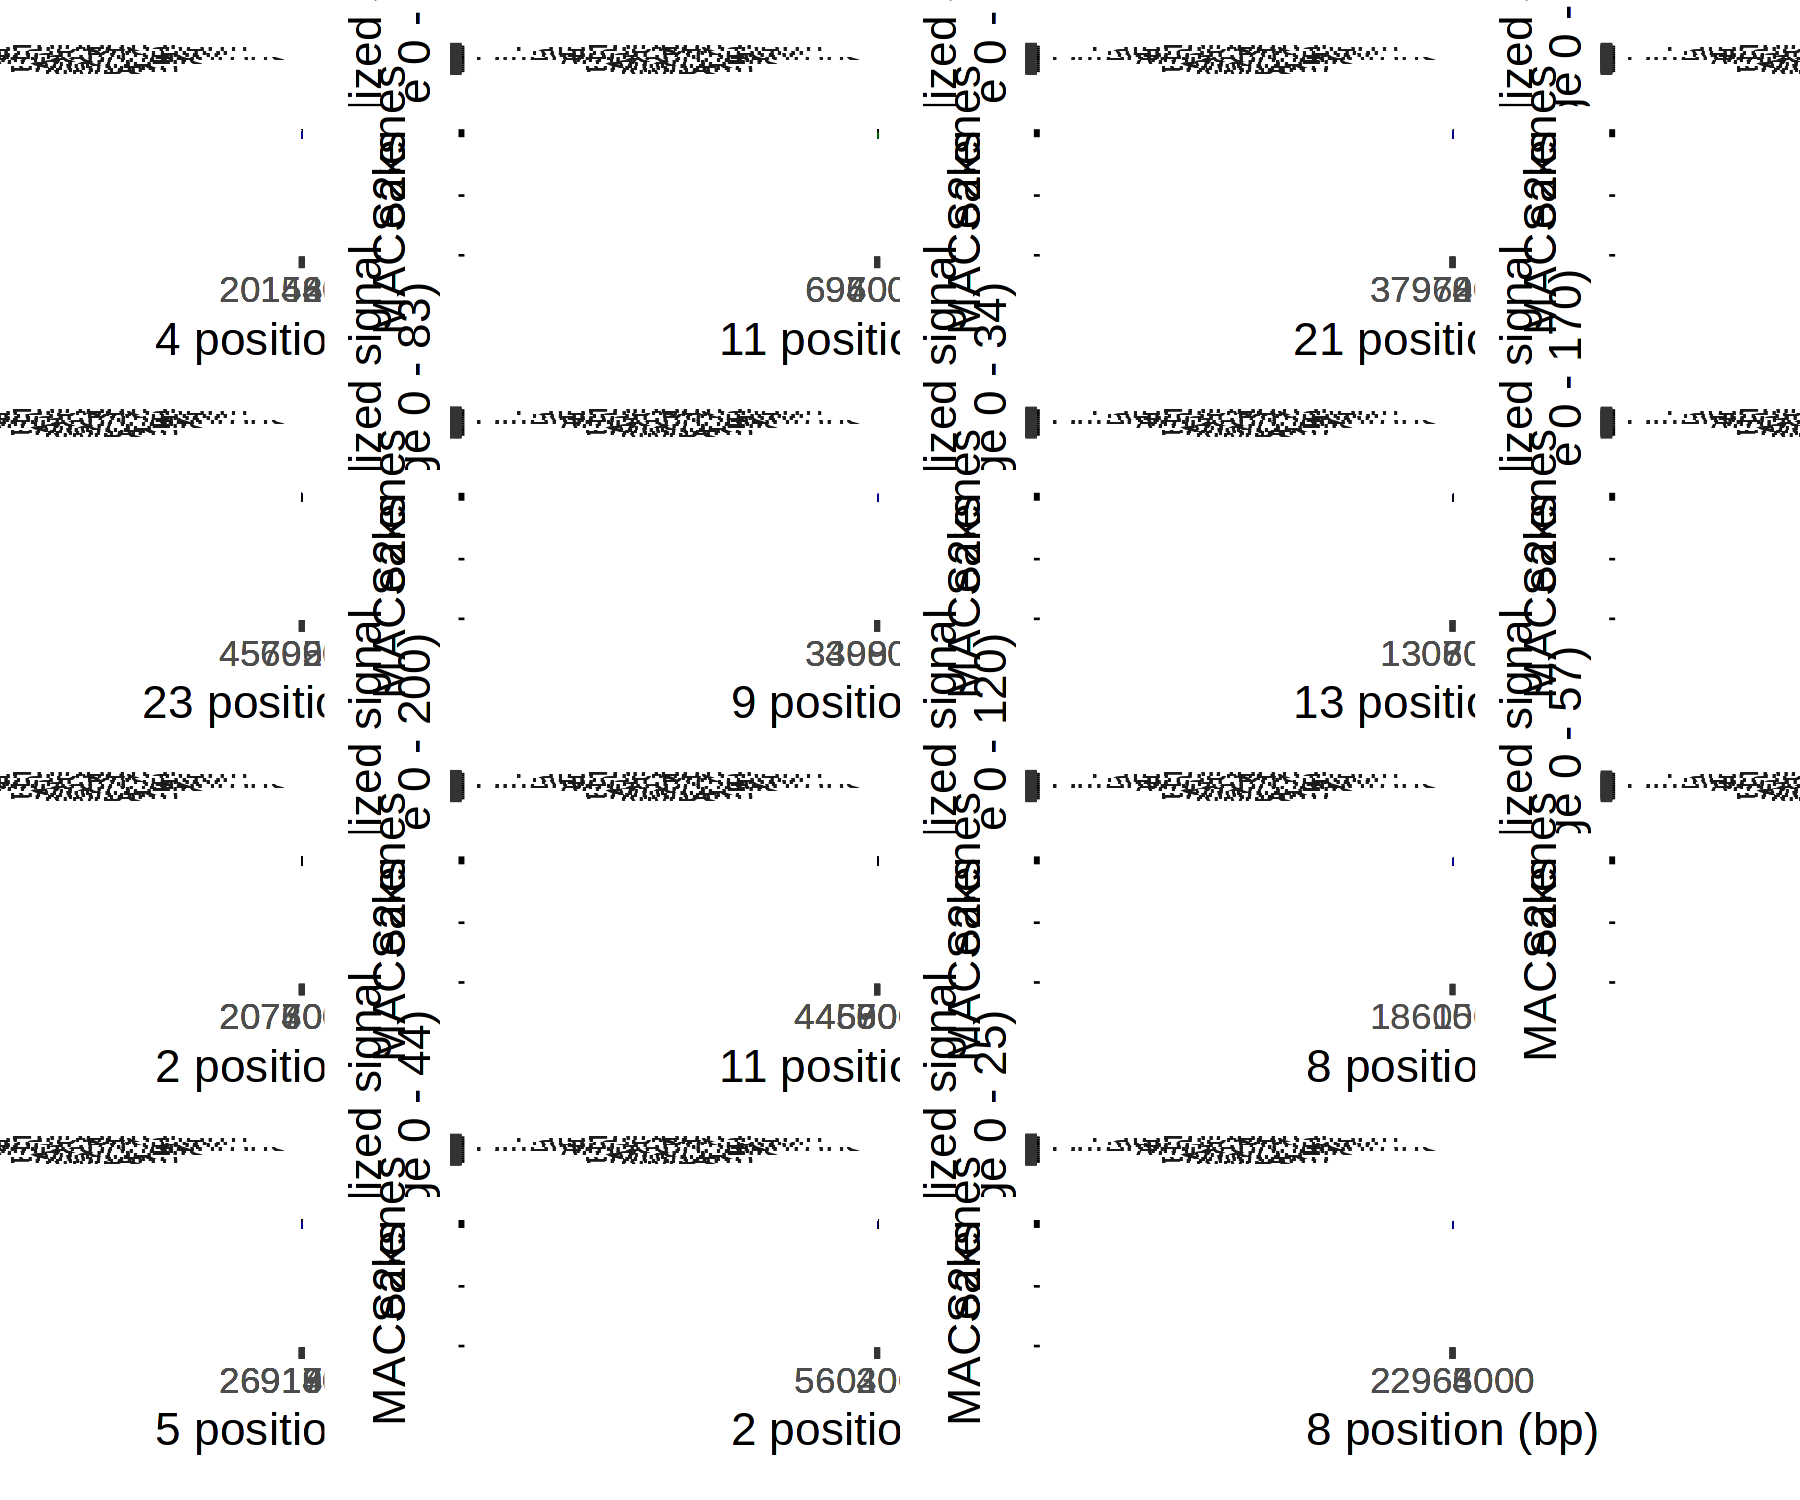

In [470]:
# Default assay - ATAC (such that we can have cellrager-arc peaks as well)

# create an empty list to store coverage plots
coverage_plots <- list()

# iterate over each marker gene
for (gene in list_genes){
    # generate the CoveragePlot for the current gene
    plot <- CoveragePlot(
      object = TDR118,
      region = gene,
      ranges = peaks,
      ranges.title = "MACS2")
    
    # add the plot to the list
    coverage_plots[[gene]] <- plot
}

# # combine the CoveragePlots into a patchwork grid (4x4)
# patchwork_plots <- wrap_plots(coverage_plots, ncol=4)

# # display the patchwork of CoveragePlots
# patchwork_plots

In [ ]:
library(patchwork)

In [ ]:
# Compare the called peaks using a Coverage Plot
cov_plot <- CoveragePlot(
  object = TDR118,
  region = "tbxta",
  annotation=FALSE,
  peaks=FALSE
  #ranges = peaks,
  #ranges.title = "MACS2"
)

# gene annotation
gene_plot <- AnnotationPlot(
  object = TDR118,
  region = "19-14188000-14191000"
)
# gene_plot


# cellranger-arc peak
peak_plot1 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$ATAC@ranges
)
# peak_plot

# cell-type-specific peak
peak_plot2 <- PeakPlot(
  object = TDR118,
  region = "19-14188000-14191000",
  peaks=TDR118@assays$peaks_celltype@ranges
)

# expression of RNA
expr_plot <- ExpressionPlot(
  object = TDR118,
  features = "tbxta",
  assay = "RNA"
)


CombineTracks(
  plotlist = list(cov_plot, peak_plot1, peak_plot2, gene_plot),
  expression.plot = expr_plot,
  heights = c(10,1,1,2),
  widths = c(10, 1)
)

In [468]:
for (gene in list_genes){
    # Check if the gene is present in the annotation
    is_present <- gene %in% annotation$gene_name

    # Print the result
    if (is_present) {
      cat(paste(gene, "is present in the annotation.\n"))
    } else {
      cat(paste(gene, "is not present in the annotation.\n"))
    }
}

lrrc17 is present in the annotation.
comp is present in the annotation.
ripply1 is present in the annotation.
crestin is present in the annotation.
ednrab is present in the annotation.
dlx2a is present in the annotation.
olig3 is present in the annotation.
hoxd4a is present in the annotation.
rxrga is present in the annotation.
prrx1 is not present in the annotation.
nid1b is present in the annotation.
cpox is present in the annotation.
gata1a is present in the annotation.
hbbe1 is not present in the annotation.
tbx3b is present in the annotation.
loxl5b is present in the annotation.
emilin3a is present in the annotation.


### IMPORTANT:

A nice vignette on generating Coverage plots (peaks, averaged reads across cells per cell type, genomic links, and genomic regions with annotation):

https://stuartlab.org/signac/articles/visualization.html

In [ ]:
# save the Seurat object

# save as RDS
saveRDS(object = pbmc, "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/pbmc_signac_example.RDS")

# save as h5Seurat
SaveH5Seurat(object = pbmc, 
             filename = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/pbmc_signac_example.h5Seurat", 
             overwrite = TRUE)

# [Already done] Step 4. ATAC data processing (for the "peaks" chosen from the above)

(link: https://stuartlab.org/signac/articles/pbmc_vignette.html)

Tasks:
- Filtering out low-quality cells using QC metrics 
- Dim reduction, computing the embedding

## Chromatin accessibility (ATAC) data processing

Here we process the DNA accessibility assay the same way we would process a scATAC-seq dataset, by performing latent semantic indexing (LSI).

In [25]:
# # change the default assay to "peaks" (cell-type-specifically called peaks)
# DefaultAssay(pbmc) <- "peaks"
# pbmc <- FindTopFeatures(pbmc, min.cutoff = 5)
# pbmc <- RunTFIDF(pbmc)
# pbmc <- RunSVD(pbmc)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



# [Already done] Step 5. Compute the joint embedding (weighted nearest neighbor)

In [486]:
# # First, we will compute the UMAPs from individual modalities
# # RNA
# pbmc <- RunUMAP(pbmc, reduction = 'pca', dims = 1:50, assay = 'SCT', 
#               reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
# # ATAC
# pbmc <- RunUMAP(pbmc, reduction = 'lsi', dims = 2:40, assay = 'peaks', 
#               reduction.name = 'atac.umap', reduction.key = 'atacUMAP_')


In [487]:
# # Then, let's compute the weighted nearest neighbors and a joint embedding (UMAP)
# pbmc <- FindMultiModalNeighbors(pbmc,reduction.list = list("pca", "lsi"), dims.list = list(1:50, 2:40))
# pbmc <- RunUMAP(pbmc, nn.name = "weighted.nn", n.neighbors = 30, 
#                 reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
# pbmc <- FindClusters(pbmc, graph.name = "wsnn", algorithm = 4, verbose = FALSE)

# DimPlot(pbmc, label = TRUE, repel = TRUE, reduction = "wnn.umap") + NoLegend()

In [488]:
# DimPlot(pbmc, label = TRUE, repel = TRUE, reduction = "wnn.umap", group.by="predicted.id") + NoLegend()

## (Optional) Curation of annotation in exCellxgene 

- convert the Seurat object to anndata for this

In [489]:
# save the seurat object, pbmc
SaveH5Seurat(object = TDR118, filename = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/TDR118_processed.h5Seurat")


Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for ATAC

Adding data for ATAC

Adding variable features for ATAC

Adding feature-level metadata for ATAC

Writing out ranges for ATAC

Writing out motifs for ATAC

Writing out fragments for ATAC

Writing out seqinfo for ATAC

Writing out annotation for ATAC

Writing out bias for ATAC

Writing out positionEnrichment for ATAC

Writing out links for ATAC

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for peaks_celltype

Adding data for peaks_celltype

Adding variable features for peaks_celltype

Adding feature-level metadata for peaks_celltype

Writing out ranges for peaks_celltype

Writing out motifs for peaks_celltype

Writing out fragments for peaks_celltype



# [Skipped] Step 6. Compute the gene-peak linkage

**Note - the gene-peak correlation can be better quantified in MetaCells (i.e. SEACells), so we will just skip this part.**

Signac: For each gene, we can find the set of peaks that may regulate the gene by computing the correlation between gene expression and accessibility at nearby peaks, and correcting for bias due to GC content, overall accessibility, and peak size. See the Signac paper for a full description of the method we use to link peaks to genes.

Running this step on the whole genome can be time consuming, so here we demonstrate peak-gene links for a subset of genes as an example. The same function can be used to find links for all genes by omitting the genes.use parameter:

### NOTE: We're restarting our analyses from here (10/11/2023)



In [3]:
# Loading the Seurat object (RDS)
TDR118 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/TDR118/TDR118_processed.rds")
TDR118

An object of class Seurat 
1055655 features across 13022 samples within 5 assays 
Active assay: ATAC (248320 features, 248320 variable features)
 4 other assays present: RNA, SCT, peaks_celltype, peaks_bulk
 8 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap, umap.pca30, lsi.cellranger, atac.umap.cellranger

In [8]:
TDR118@assays$ATAC@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"
TDR118@assays$peaks_celltype@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"
TDR118@assays$peaks_bulk@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"

In [42]:
# Check out the seqlevels
TDR118@assays$ATAC@seqinfo

Seqinfo object with 1923 sequences (1 circular) from GRCz11 genome:
  seqnames seqlengths isCircular genome
  1          59578282      FALSE GRCz11
  2          59640629      FALSE GRCz11
  3          62628489      FALSE GRCz11
  4          78093715      FALSE GRCz11
  5          72500376      FALSE GRCz11
  ...             ...        ...    ...
  NA758          2601      FALSE GRCz11
  CTG8005      153879      FALSE GRCz11
  CTG20005      37354      FALSE GRCz11
  CTG20006     161442      FALSE GRCz11
  CTG20007     159186      FALSE GRCz11

In [52]:
TDR118@assays$peaks_bulk@ranges

GRanges object with 435704 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3596-4069      *
       [2]        1         4478-6981      *
       [3]        1       11049-12897      *
       [4]        1       14695-15041      *
       [5]        1       18522-19033      *
       ...      ...               ...    ...
  [435700]        9 56455828-56456125      *
  [435701]        9 56457205-56457539      *
  [435702]        9 56459130-56459697      *
  [435703]       MT           29-3505      *
  [435704]       MT       13232-16545      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

In [62]:
library(GenomicRanges)

granges(TDR118@assays$ATAC)

GRanges object with 248320 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         2372-3057      *
       [2]        1         6507-7253      *
       [3]        1       11485-12198      *
       [4]        1       14475-15248      *
       [5]        1       16516-17393      *
       ...      ...               ...    ...
  [248316]        9 56433462-56434391      *
  [248317]        9 56437053-56437849      *
  [248318]        9 56450898-56451686      *
  [248319]        9 56452315-56452858      *
  [248320]        9 56459068-56459827      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [59]:
seqinfo(TDR118@assays$ATAC)

Seqinfo object with 1923 sequences (1 circular) from GRCz11 genome:
  seqnames seqlengths isCircular genome
  1          59578282      FALSE GRCz11
  2          59640629      FALSE GRCz11
  3          62628489      FALSE GRCz11
  4          78093715      FALSE GRCz11
  5          72500376      FALSE GRCz11
  ...             ...        ...    ...
  NA758          2601      FALSE GRCz11
  CTG8005      153879      FALSE GRCz11
  CTG20005      37354      FALSE GRCz11
  CTG20006     161442      FALSE GRCz11
  CTG20007     159186      FALSE GRCz11

In [73]:
# extract the GRanges object
gr_object <- GRanges(rownames(TDR118[["ATAC"]]))

# Subset the GRanges object
gr_subset <- gr_object[seqnames(gr_object) %in% seqnames(seqinfo(gr_object))[1:25]]
gr_subset

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘granges’ for signature ‘"character"’


In [48]:
TDR118@assays$ATAC@ranges

GRanges object with 248320 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         2372-3057      *
       [2]        1         6507-7253      *
       [3]        1       11485-12198      *
       [4]        1       14475-15248      *
       [5]        1       16516-17393      *
       ...      ...               ...    ...
  [248316]        9 56433462-56434391      *
  [248317]        9 56437053-56437849      *
  [248318]        9 56450898-56451686      *
  [248319]        9 56452315-56452858      *
  [248320]        9 56459068-56459827      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [50]:
TDR118@assays$ATAC@ranges@seqnames

factor-Rle of length 248320 with 25 runs
  Lengths: 10098  8666  9266  8824 11049 ... 13494 11199 14248  9839 11155
  Values :    1     10    11    12    13 ...    5     6     7     8     9 
Levels(25): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

In [22]:
TDR118@assays$ATAC@ranges

GRanges object with 248320 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         2372-3057      *
       [2]        1         6507-7253      *
       [3]        1       11485-12198      *
       [4]        1       14475-15248      *
       [5]        1       16516-17393      *
       ...      ...               ...    ...
  [248316]        9 56433462-56434391      *
  [248317]        9 56437053-56437849      *
  [248318]        9 56450898-56451686      *
  [248319]        9 56452315-56452858      *
  [248320]        9 56459068-56459827      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [17]:
DefaultAssay(TDR118) <- "ATAC"

# first compute the GC content for each peak
TDR118 <- RegionStats(TDR118, genome = BSgenome.Drerio.UCSC.danRer11)

# link peaks to genes
TDR118 <- LinkPeaks(
  object = TDR118,
  peak.assay = "ATAC",
  expression.assay = "SCT",
  gene.coords = gene.coords.zf,
  genes.use = c("tbxta", "sox2")
)

Warning message in RegionStats.default(object = regions, genome = genome, verbose = verbose, :
“Not all seqlevels present in supplied genome”
Testing 2 genes and 248320 peaks



ERROR: Error in density.default(x = query.feature[[featmatch]], kernel = "gaussian", : argument 'x' must be numeric


In [18]:
str(TDR118[["ATAC"]])

Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 25 levels "1","2","3","4",..: 1 10 11 12 13 14 15 16 17 18 ...
  .. .. .. .. ..@ lengths        : int [1:25] 10098 8666 9266 8824 11049 9364 9258 10708 10019 9999 ...
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:248320] 2372 6507 11485 14475 16516 17575 18455 19272 27340 32261 ...
  .. .. .. .. ..@ width          : int [1:248320] 686 747 714 774 878 624 696 409 873 661 ...
  .. .. .. .. ..@ NAMES          : NULL
  .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ stran

## NOTES (10/11/2023)

- the GC content computation is teh cause for this error. For some reason, the Granges object within this TDR118 Seurat object has some weird features?! I need to debug this further...for now, let's hold on this analysis.

# [debugging] Step 7. DA peaks and TF motif enrichment

This is still an open problem in scATAC-seq field.
We will try a couple of methods here.

- Signac (Cicero, ChromeVar)
vignette - Motif analysis with Signac: https://stuartlab.org/signac/articles/motif_vignette.html



- CellOracle - Sam Morris lab
CellOracle: Systematic TF KO simulations in zebrafish
Next, we applied CellOracle to systematically perturb TFs across zebrafish development. We made use of a 38,731-cell atlas of zebrafish embryogenesis published in a study by Farrell et al.32, comprising 25 developmental trajectories that span zygotic genome activation to early somitogenesis. We first inferred GRN configurations for the 38 cell types and states identified in the Farrell et al. study32, splitting the main branching trajectory into four sub-branches: ectoderm; axial mesoderm; other mesendoderm; and germ layer branching point (Extended Data Fig. 10a,b). In the absence of scATAC-seq data, we constructed a base GRN using promoter information from the UCSC database, obtaining information on TF-binding motifs from the Danio rerio CisBP motif database (Methods). Our benchmarking has shown that this approach produces reliable GRN inference (Extended Data Fig. 2). After preprocessing and GRN inference, we performed KO simulations for all TFs with inferred connections to at least one other gene (n = 232 ‘active’ TFs; Methods). The results of these simulations across all developmental trajectories can be explored at https://www.celloracle.org.
(Note that CellOracle is a python package).


In [502]:
library(JASPAR2020)
library(TFBSTools)
library(patchwork)




Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




## Adding motif information to the Seurat object

To add the DNA sequence motif information required for motif analyses, we can run the AddMotifs() function:

In [505]:
JASPAR2020

An object of class "JASPAR2020"
Slot "db":
[1] "/usr/local/lib/R/site-library/JASPAR2020/extdata/JASPAR2020.sqlite"


In [503]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

# add motif information
TDR118 <- AddMotifs(
  object = TDR118,
  genome = BSgenome.Drerio.UCSC.danRer11,
  pfm = pfm
)

Building motif matrix



ERROR: Error in dimnamesGets(x, value): length of Dimnames[[1]] (1) is not equal to Dim[1] (0)


To facilitate motif analysis in Signac, we have created the Motif class to store all the required information, including a list of position weight matrices (PWMs) or position frequency matrices (PFMs) and a motif occurrence matrix. Here, the AddMotifs() function constructs a Motif object and adds it to our mouse brain dataset, along with other information such as the base composition of each peak. A motif object can be added to any Seurat assay using the SetAssayData() function. See the object interaction vignette for more information.

## Finding overrepresented motifs

signac: To identify potentially important cell-type-specific regulatory sequences, we can search for DNA motifs that are overrepresented in a set of peaks that are differentially accessible between cell types.

Here, we find differentially accessible peaks between CD4 T cells and CD8 T cells. 
For sparse data (such as scATAC-seq), we find it is often necessary to lower the min.pct threshold in FindMarkers() from the default (0.1, which was designed for scRNA-seq data).

We then perform a hypergeometric test to test the probability of observing the motif at the given frequency by chance, comparing with a background set of peaks matched for GC content.

In [74]:
pbmc@assays

$RNA
Assay data with 36601 features for 11331 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 

$ATAC
ChromatinAssay data with 108377 features for 11331 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

$SCT
SCTAssay data with 24470 features for 11331 cells, and 1 SCTModel(s) 
Top 10 variable features:
 GNLY, IGKC, IGHM, PTGDS, BANK1, IGLC3, TCF4, SOX5, JCHAIN, IGLC2 

$peaks
ChromatinAssay data with 151567 features for 11331 cells
Variable features: 151443 
Genome: 
Annotation present: TRUE 
Motifs present: TRUE 
Fragment files: 1 


## Note on the DA (Differentially Accessible) peaks computation

argument in FindMarkers:

- test.use

Denotes which test to use. Available options are:

- "wilcox" : Identifies differentially expressed genes between two groups of cells using a Wilcoxon Rank Sum test (default)

- "bimod" : Likelihood-ratio test for single cell gene expression, (McDavid et al., Bioinformatics, 2013)

- "roc" : Identifies 'markers' of gene expression using ROC analysis. For each gene, evaluates (using AUC) a classifier built on that gene alone, to classify between two groups of cells. An AUC value of 1 means that expression values for this gene alone can perfectly classify the two groupings (i.e. Each of the cells in cells.1 exhibit a higher level than each of the cells in cells.2). An AUC value of 0 also means there is perfect classification, but in the other direction. A value of 0.5 implies that the gene has no predictive power to classify the two groups. Returns a 'predictive power' (abs(AUC-0.5) * 2) ranked matrix of putative differentially expressed genes.

- "t" : Identify differentially expressed genes between two groups of cells using the Student's t-test.

- "negbinom" : Identifies differentially expressed genes between two groups of cells using a negative binomial generalized linear model. Use only for UMI-based datasets

- "poisson" : Identifies differentially expressed genes between two groups of cells using a poisson generalized linear model. Use only for UMI-based datasets

- "LR" : Uses a logistic regression framework to determine differentially expressed genes. Constructs a logistic regression model predicting group membership based on each feature individually and compares this to a null model with a likelihood ratio test.

- "MAST" : Identifies differentially expressed genes between two groups of cells using a hurdle model tailored to scRNA-seq data. Utilizes the MAST package to run the DE testing.

- "DESeq2" : Identifies differentially expressed genes between two groups of cells based on a model using DESeq2 which uses a negative binomial distribution (Love et al, Genome Biology, 2014).This test does not support pre-filtering of genes based on average difference (or percent detection rate) between cell groups. However, genes may be pre-filtered based on their minimum detection rate (min.pct) across both cell groups. To use this method, please install DESeq2, using the instructions at https://bioconductor.org/packages/release/bioc/html/DESeq2.html

In [75]:
# Set the default annotation label (This part is not as straightforward as scanpy)
# Here, we will choose the "predict.id"
Idents(pbmc) <- pbmc@meta.data$predicted.id.coarse

# find the differnetially accessible peaks using "FindMarkers" (DGE function in Seurat)
da_peaks <- FindMarkers(
  object = pbmc,
  ident.1 = 'CD4 T',
  ident.2 = 'CD8 T',
  only.pos = TRUE,
  test.use = 'LR',
  min.pct = 0.05,
  latent.vars = 'nCount_peaks'
)

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005, ])

In [76]:
top.da.peak

[1] "chr1-234408392-234409658"  "chr2-112181378-112183044" 
   [3] "chr2-9781830-9782674"      "chr2-147449208-147450101" 
   [5] "chr21-45642423-45644286"   "chr10-4825470-4826865"    
   [7] "chr8-42154091-42154496"    "chr11-67884111-67885357"  
   [9] "chr11-3511417-3512663"     "chr21-36288386-36289672"  
  [11] "chr4-122577878-122579065"  "chr8-42154812-42155219"   
  [13] "chr4-86593740-86595367"    "chr8-38362561-38363782"   
  [15] "chr9-37528613-37529580"    "chr7-70787508-70788729"   
  [17] "chr6-33668475-33669344"    "chr10-5291420-5292665"    
  [19] "chr16-79598809-79601618"   "chr4-139554937-139557423" 
  [21] "chr19-50328661-50329682"   "chr6-138455301-138456599" 
  [23] "chr8-94959948-94960983"    "chr6-167119300-167120267" 
  [25] "chr10-110355918-110357165" "chr6-161076081-161076818" 
  [27] "chr7-70778398-70779686"    "chr20-52974100-52974495"  
  [29] "chr1-57306909-57307857"    "chr11-35039955-35040908"  
  [31] "chr1-154464735-154465435"  "chr3-32963699-32964321"   
  [33] "chr14-31944181-31945420"   "chr5-9545829-9546532"     
  [35] "chr6-166950937-166951579"  "chr17-59782825-59783515"  
  [37] "chr1-1216632-1217392"      "chr10-33150390-33151696"  
  [39] "chr4-142565600-142566273"  "chr5-56638405-56639808"   
  [41] "chr3-101518043-101518809"  "chr5-758859-759537"       
  [43] "chr2-55530110-55531125"    "chr12-6789083-6789726"    
  [45] "chr6-167113786-167114837"  "chr10-60727683-60728404"  
  [47] "chr9-37531495-37532230"    "chr10-5293649-5294370"    
  [49] "chr2-112187518-112188648"  "chr13-108342074-108343246"
  [51] "chr2-206530466-206531207"  "chr7-44633064-44634147"   
  [53] "chrX-41382794-41384475"    "chr4-89929343-89930082"   
  [55] "chr11-71710130-71711364"   "chr10-61992047-61994408"  
  [57] "chr2-147297516-147298200"  "chr20-13220034-13222113"  
  [59] "chr2-64213642-64214922"    "chr10-3874638-3876157"    
  [61] "chr12-12474438-12475581"   "chr12-12008985-12011035"  
  [63] "chr5-32531306-32532610"    "chr20-13230588-13231709"  
  [65] "chr3-13879366-13880875"    "chr12-110589842-110591361"
  [67] "chr6-149494631-149495717"  "chr3-42638054-42639155"   
  [69] "chr10-62050843-62051407"   "chr5-157544330-157544950" 
  [71] "chr7-74569216-74570108"    "chr13-108495386-108496877"
  [73] "chr5-56479705-56482774"    "chr3-129481607-129482363" 
  [75] "chr16-79639596-79641089"   "chr13-99314246-99315265"  
  [77] "chr12-12467236-12468135"   "chr6-167053690-167054617" 
  [79] "chr4-86544175-86545206"    "chr21-45606925-45607822"  
  [81] "chr22-46660419-46661756"   "chr1-6459635-6460922"     
  [83] "chr10-35011480-35012240"   "chr6-161079695-161080602" 
  [85] "chr4-128802852-128804193"  "chr12-6790600-6791072"    
  [87] "chr6-166942481-166943121"  "chr20-52971988-52972688"  
  [89] "chrX-57286276-57287194"    "chr3-7876538-7877300"     
  [91] "chr1-239501487-239502337"  "chr8-42245364-42246433"   
  [93] "chr14-64755522-64756306"   "chr5-157603196-157603738" 
  [95] "chr16-17396432-17397738"   "chr4-153152899-153154270" 
  [97] "chr20-21547905-21548956"   "chr10-103677679-103678582"
  [99] "chr11-128839977-128840538" "chr6-142773318-142774516" 
 [101] "chr8-124261401-124263447"  "chr16-79770024-79770878"  
 [103] "chr12-8953779-8954502"     "chr10-60732205-60733683"  
 [105] "chr3-32960485-32961532"    "chr12-22334412-22335864"  
 [107] "chr22-46673740-46675062"   "chr12-12456165-12457055"  
 [109] "chr1-193457125-193458039"  "chr2-222423646-222425557" 
 [111] "chr4-7854380-7855468"      "chr10-33114353-33114804"  
 [113] "chr19-11091498-11092495"   "chr8-141072815-141073685" 
 [115] "chr20-36998433-36999362"   "chr4-52588577-52589458"   
 [117] "chr2-100104343-100105450"  "chr1-203682082-203683100" 
 [119] "chr8-140790420-140791772"  "chr4-142703731-142704355" 
 [121] "chr20-21557065-21557991"   "chr6-149507983-149508875" 
 [123] "chr1-213670049-213670904"  "chr2-109143525-109144879" 
 [125] "chr1-111723189-111723820"  "chr19-49896634-49898146"  
 [127] "chr12-117874846-117876341"

## (Optional) Choosing a set of background peaks 


Matching the set of background peaks is essential when finding enriched DNA sequence motifs. By default, we choose a set of peaks matched for GC content, but it can be sometimes be beneficial to further restrict the background peaks to those that are accessible in the groups of cells compared when finding differentially accessible peaks.

The AccessiblePeaks() function can be used to find a set of peaks that are open in a subset of cells. We can use this function to first restrict the set of possible background peaks to those peaks that were open in the set of cells compared in FindMarkers(), and then create a GC-content-matched set of peaks from this larger set using MatchRegionStats().

In [77]:
# find peaks open in Pvalb or Sst cells
open.peaks <- AccessiblePeaks(pbmc, idents = c("CD4 T", "CD8 T"))

# match the overall GC content in the peak set
meta.feature <- GetAssayData(pbmc, assay = "peaks", slot = "meta.features")
peaks.matched <- MatchRegionStats(
  meta.feature = meta.feature[open.peaks, ],
  query.feature = meta.feature[top.da.peak, ],
  n = 50000
)

Matching GC.percent distribution



In [83]:
# test enrichment
enriched.motifs <- FindMotifs(
  object = pbmc,
  features = top.da.peak
)

enriched.motifs

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 3164 regions



motif    observed background percent.observed percent.background
MA0599.1 MA0599.1 1385     7934       43.77370         19.8350           
MA0039.4 MA0039.4 1432     8428       45.25917         21.0700           
MA1653.1 MA1653.1 1305     7344       41.24526         18.3600           
MA1513.1 MA1513.1  803     3353       25.37927          8.3825           
MA1564.1 MA1564.1  944     4442       29.83565         11.1050           
MA0746.2 MA0746.2  982     4839       31.03666         12.0975           
MA0741.1 MA0741.1 1051     5626       33.21745         14.0650           
MA0162.4 MA0162.4  800     3576       25.28445          8.9400           
MA1522.1 MA1522.1 1112     6235       35.14539         15.5875           
MA1515.1 MA1515.1 1106     6285       34.95575         15.7125           
MA1627.1 MA1627.1 1119     6491       35.36662         16.2275           
MA1107.2 MA1107.2 1245     7785       39.34893         19.4625           
MA0516.2 MA0516.2  920     4850       29.07712         12.1250           
MA0685.1 MA0685.1  814     4025       25.72693         10.0625           
MA0747.1 MA0747.1  944     5142       29.83565         12.8550           
MA0079.4 MA0079.4  895     4747       28.28698         11.8675           
MA1512.1 MA1512.1  893     4781       28.22377         11.9525           
MA0073.1 MA0073.1 1224     7935       38.68521         19.8375           
MA1511.1 MA1511.1  863     4718       27.27560         11.7950           
MA0753.2 MA0753.2  811     4290       25.63211         10.7250           
MA0471.2 MA0471.2  851     4673       26.89633         11.6825           
MA1516.1 MA1516.1  722     3639       22.81922          9.0975           
MA0493.1 MA0493.1  954     5751       30.15171         14.3775           
MA0732.1 MA0732.1  538     2318       17.00379          5.7950           
MA1650.1 MA1650.1  454     1760       14.34893          4.4000           
MA1517.1 MA1517.1  776     4266       24.52592         10.6650           
MA1102.2 MA1102.2  749     4169       23.67257         10.4225           
MA0528.2 MA0528.2 1085     7313       34.29204         18.2825           
MA0740.1 MA0740.1  639     3262       20.19595          8.1550           
MA1615.1 MA1615.1  758     4330       23.95702         10.8250           
⋮        ⋮        ⋮        ⋮          ⋮                ⋮                 
MA0461.2 MA0461.2 111       1064       3.5082174        2.6600           
MA0804.1 MA0804.1 126       1231       3.9823009        3.0775           
MA0678.1 MA0678.1 106       1021       3.3501896        2.5525           
MA0826.1 MA0826.1  97        922       3.0657396        2.3050           
MA0886.1 MA0886.1 102        983       3.2237674        2.4575           
MA0633.1 MA0633.1 186       1944       5.8786346        4.8600           
MA0668.1 MA0668.1  80        771       2.5284450        1.9275           
MA0639.1 MA0639.1 119       1211       3.7610619        3.0275           
MA1506.1 MA1506.1 116       1180       3.6662453        2.9500           
MA0874.1 MA0874.1 125       1287       3.9506953        3.2175           
MA0615.1 MA0615.1  34        292       1.0745891        0.7300           
MA0158.2 MA0158.2  96        988       3.0341340        2.4700           
MA0818.1 MA0818.1  86        876       2.7180784        2.1900           
MA0749.1 MA0749.1  23        188       0.7269279        0.4700           
MA0025.2 MA0025.2 314       3589       9.9241466        8.9725           
MA0469.3 MA0469.3  26        223       0.8217446        0.5575           
MA0776.1 MA0776.1  40        373       1.2642225        0.9325           
MA0019.1 MA0019.1 218       2448       6.8900126        6.1200           
MA1476.1 MA1476.1 113       1211       3.5714286        3.0275           
MA0833.2 MA0833.2 364       4224      11.5044248       10.5600           
MA1568.1 MA1568.1 102       1119       3.2237674        2.7975           
MA0843.1 MA0843.1 107       1288       3.3817952        3.2200           
MA0687.1 MA06

In [84]:
## Matching GC.percent distribution
# peaks.matched can then be used as the background peak set by setting background=peaks.matched in FindMotifs().

# test enrichment
enriched.motifs.bg_corrected <- FindMotifs(
  object = pbmc,
  features = top.da.peak, 
  background=peaks.matched
)

enriched.motifs.bg_corrected

Testing motif enrichment in 3164 regions



motif    observed background percent.observed percent.background
MA0599.1 MA0599.1 1385     12667      43.77370         25.334            
MA0039.4 MA0039.4 1432     13472      45.25917         26.944            
MA1653.1 MA1653.1 1305     11861      41.24526         23.722            
MA1564.1 MA1564.1  944      7624      29.83565         15.248            
MA0746.2 MA0746.2  982      8126      31.03666         16.252            
MA1513.1 MA1513.1  803      6097      25.37927         12.194            
MA0741.1 MA0741.1 1051      9245      33.21745         18.490            
MA1522.1 MA1522.1 1112     10060      35.14539         20.120            
MA0162.4 MA0162.4  800      6267      25.28445         12.534            
MA1627.1 MA1627.1 1119     10403      35.36662         20.806            
MA1515.1 MA1515.1 1106     10283      34.95575         20.566            
MA0516.2 MA0516.2  920      7938      29.07712         15.876            
MA1107.2 MA1107.2 1245     12283      39.34893         24.566            
MA0685.1 MA0685.1  814      6757      25.72693         13.514            
MA0747.1 MA0747.1  944      8396      29.83565         16.792            
MA0079.4 MA0079.4  895      7801      28.28698         15.602            
MA1512.1 MA1512.1  893      7825      28.22377         15.650            
MA0073.1 MA0073.1 1224     12196      38.68521         24.392            
MA0471.2 MA0471.2  851      7481      26.89633         14.962            
MA1511.1 MA1511.1  863      7694      27.27560         15.388            
MA0753.2 MA0753.2  811      7107      25.63211         14.214            
MA1516.1 MA1516.1  722      6079      22.81922         12.158            
MA0493.1 MA0493.1  954      9013      30.15171         18.026            
MA0732.1 MA0732.1  538      4071      17.00379          8.142            
MA1517.1 MA1517.1  776      6898      24.52592         13.796            
MA1650.1 MA1650.1  454      3286      14.34893          6.572            
MA0149.1 MA0149.1 1341     14685      42.38306         29.370            
MA0769.2 MA0769.2  608      5090      19.21618         10.180            
MA0740.1 MA0740.1  639      5461      20.19595         10.922            
MA0528.2 MA0528.2 1085     11247      34.29204         22.494            
⋮        ⋮        ⋮        ⋮          ⋮                ⋮                 
MA0874.1 MA0874.1 125       1647       3.9506953        3.294            
MA0025.2 MA0025.2 314       4448       9.9241466        8.896            
MA0648.1 MA0648.1 119       1562       3.7610619        3.124            
MA0908.1 MA0908.1 121       1599       3.8242731        3.198            
MA0833.2 MA0833.2 364       5231      11.5044248       10.462            
MA0639.1 MA0639.1 119       1578       3.7610619        3.156            
MA0804.1 MA0804.1 126       1687       3.9823009        3.374            
MA0158.2 MA0158.2  96       1259       3.0341340        2.518            
MA1506.1 MA1506.1 116       1552       3.6662453        3.104            
MA0594.2 MA0594.2  33        380       1.0429836        0.760            
MA0818.1 MA0818.1  86       1132       2.7180784        2.264            
MA0139.1 MA0139.1 789      11852      24.9367889       23.704            
MA0749.1 MA0749.1  23        257       0.7269279        0.514            
MA0024.3 MA0024.3  44        556       1.3906448        1.112            
MA0615.1 MA0615.1  34        437       1.0745891        0.874            
MA1476.1 MA1476.1 113       1616       3.5714286        3.232            
MA0864.2 MA0864.2  60        825       1.8963338        1.650            
MA0776.1 MA0776.1  40        538       1.2642225        1.076            
MA1568.1 MA1568.1 102       1473       3.2237674        2.946            
MA0043.3 MA0043.3 255       3848       8.0594185        7.696            
MA0470.2 MA0470.2  45        637       1.4222503        1.274            
MA0019.1 MA0019.1 218       3334       6.8900126        6.668            
MA0469.3 MA04

The result is "enriched.motif" dataframe, with motif name (TF name), percent of observation, background, fold-enrichment, as well as p-values.

-> See Signac paper's notebooks for which values the authors picked for plotting and quantification.

In [89]:
pbmc@assays

$RNA
Assay data with 36601 features for 11331 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 

$ATAC
ChromatinAssay data with 108377 features for 11331 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

$SCT
SCTAssay data with 24470 features for 11331 cells, and 1 SCTModel(s) 
Top 10 variable features:
 GNLY, IGKC, IGHM, PTGDS, BANK1, IGLC3, TCF4, SOX5, JCHAIN, IGLC2 

$peaks
ChromatinAssay data with 151567 features for 11331 cells
Variable features: 151443 
Genome: 
Annotation present: TRUE 
Motifs present: TRUE 
Fragment files: 1 


In [94]:
pbmc@assays$peaks@motifs

A Motif object containing 746 motifs in 151567 regions

In [ ]:
# what is the motif for CD4 TF?


In [91]:
# install.packages('ggseqlogo')

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


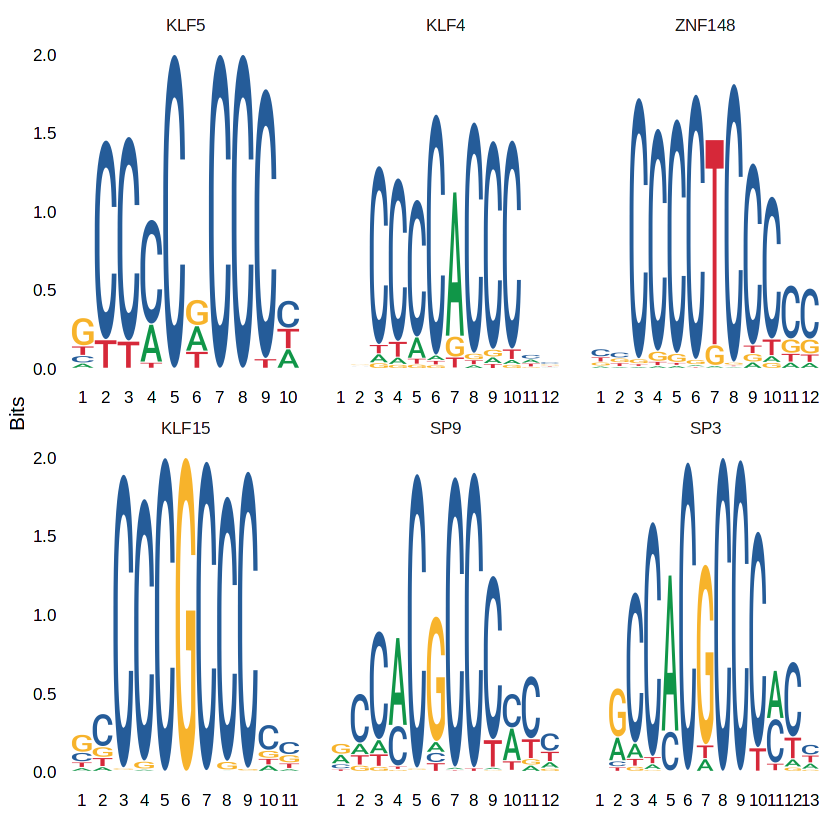

In [92]:
library(ggseqlogo)

# We can also plot the position weight matrices for the motifs, so we can visualize the different motif sequences.
MotifPlot(
  object = pbmc,
  motifs = head(rownames(enriched.motifs))
)

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


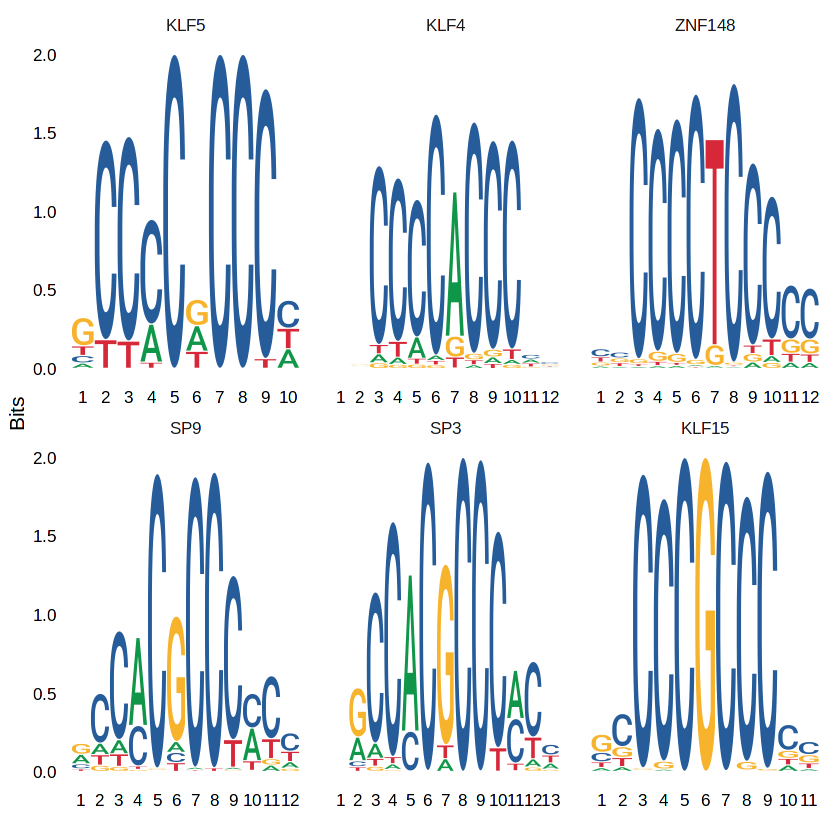

In [93]:
# We can also plot the position weight matrices for the motifs, so we can visualize the different motif sequences.
MotifPlot(
  object = pbmc,
  motifs = head(rownames(enriched.motifs.bg_corrected))
)

The identified motifs should be cross-checked with (1) references, and (2) gene expression data to see if these TFs are indeed highly expressed in the given cell type (cluster).

## Computing motif activities

Signac: We can also compute a per-cell motif activity score by running chromVAR. This allows us to visualize motif activities per cell, and also provides an alternative method of identifying differentially-active motifs between cell types.

ChromVAR identifies motifs associated with variability in chromatin accessibility between cells. See the chromVAR paper for a complete description of the method. (Schep and Greenleaf et al., Nature Methods, 2017)
https://www.nature.com/articles/nmeth.4401

In [506]:
library(chromVAR)

# Run chromVAR
TDR118 <- RunChromVAR(
  object = TDR118,
  genome = BSgenome.Drerio.UCSC.danRer11
)

DefaultAssay(TDR118) <- 'chromvar'

p1 <- DimPlot(TDR118, label=TRUE) + NoLegend()

# look at the activity of tbxta
p2 <- FeaturePlot(
  object = TDR118,
  features = "tbxta",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)
p1 + p2

ERROR: Error in GetMotifData.ChromatinAssay(object = object, slot = "data"): Motif object not present in assay


We can also directly test for differential activity scores between cell types. This tends to give similar results as performing an enrichment test on differentially accessible peaks between the cell types (shown above).

When performing differential testing on the chromVAR z-score, we can set mean.fxn=rowMeans and fc.name="avg_diff" in the FindMarkers() function so that the fold-change calculation computes the average difference in z-score between the groups.

In [106]:
differential.activity <- FindMarkers(
  object = pbmc,
  ident.1 = 'CD4 T',
  ident.2 = 'CD8 T',
  only.pos = TRUE,
  mean.fxn = rowMeans,
  fc.name = "avg_diff"
)

MotifPlot(
  object = pbmc,
  motifs = head(rownames(differential.activity)),
  assay = 'peaks'
)

ERROR: Error in length(split)/num_pos: non-numeric argument to binary operator


In [116]:
# save the Seurat object

# save as RDS
saveRDS(object = pbmc, "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/pbmc_signac_example.RDS")

# save as h5Seurat
SaveH5Seurat(object = pbmc, 
             filename = "/data/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/pbmc_signac_example.h5Seurat", 
             overwrite = TRUE)

# Step 8. Identifying gene regulatory network (Cicero)

- Cicero: an R package from Cole Trapnell's lab.
Vignette in Signac: https://stuartlab.org/signac/articles/cicero.html

In this vignette we will demonstrate how to find cis-co-accessible networks with Cicero using single-cell ATAC-seq data. Please see the Cicero website for information about Cicero.

To facilitate conversion between the Seurat (used by Signac) and CellDataSet (used by Cicero) formats, we will use a conversion function in the SeuratWrappers package available on GitHub.


Cicero: Cicero can help you perform two main types of analysis:

Constructing and analysing cis-regulatory networks. Cicero analyzes co-accessibility to identify putative cis-regulatory interactions, and uses various techniques to visualize and analyze them.
General single-cell chromatin accessibility analysis . Cicero also extends the software package Monocle to allow for identification of differential accessibility, clustering, visualization, and trajectory reconstruction using single-cell chromatin accessibility data.
